# 1. Data Preparation

### Loading Packages

In [10]:
import os
import sys
import time
import logging
import warnings
from collections import defaultdict, Counter
from tqdm import tqdm
import sqlite3 as sql
from sqlalchemy import create_engine
import pyarrow.parquet as pq
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import SelectFromModel, SelectKBest, VarianceThreshold
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold, cross_validate, GridSearchCV, BaseCrossValidator
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix

import pingouin as pg
from scipy.stats import f_oneway, shapiro, kruskal
import scikit_posthocs as posthocs
from statsmodels.multivariate.manova import MANOVA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from skbio.stats.distance import permanova
from skbio.diversity import beta_diversity

from esda import Moran, Moran_Local
from libpysal.weights import DistanceBand, KNN, spatial_lag
# also install necessary dependencies of the excel plugin of pandas

### Loading Functions

In [11]:
# function for getting a dataframes' column list
def get_columns(df: pd.DataFrame):
    return df.columns.to_list()

# function for moving a column to a new position
def move_column(df, col_name, new_position):
    temp_col = df[col_name]
    df = df.drop(columns=[col_name])
    df.insert(new_position, col_name, temp_col)
    return df

# function for converting a column to numeric
def convert_to_numeric(df):
    for col in df.columns:
        # Attempt to convert the column to numeric, setting errors='ignore' keeps the original data if conversion fails
        df[col] = pd.to_numeric(df[col], errors='ignore')
    return df

# function for getting the memory size of an object
def memory_size(bytes_size: int) -> str:
    for unit in ['Bytes', 'KB', 'MB', 'GB', 'TB']:
        if bytes_size < 1024:
            return f"{bytes_size:.2f} {unit}"
        bytes_size /= 1024
    return f"{bytes_size:.2f} PB"

In [12]:
# funtion for retrieving the sql database connector
def get_db_conn(db_path: str):
    try:
        conn = sql.connect(db_path) # connect to the SQLite database
        return conn
    except sql.Error as e:
        print(f"An error occurred while accessing the database: {e}")
        pass

# function for connecting a database object and returning its connector cursor
def get_db_cursor(db_path: str):
    try:
        conn = sql.connect(db_path) # connect to the SQLite database
        cursor = conn.cursor() # create a cursor object to execute SQL queries
        return cursor
    except sql.Error as e:
        print(f"An error occurred while accessing the database: {e}")
        pass

# function for viewing the available database tables
def get_db_tables(cursor: sql.Cursor):
    try:
        cursor.execute("SELECT name FROM sqlite_master WHERE type='table';") # cursor execution for retrieving the list of all tables
        db_tables = cursor.fetchall() # fetch the command output in a list object

        # view the list of tables
        temp = []
        for table in db_tables:
            temp.append(table[0])
        
        db_tables = temp
        return db_tables
    
    except sql.Error as e:
        print(f"An error occurred while accessing the database: {e}")
        return []

# function for extracting all available table columns in a dictionary
def get_db_columns(cursor: sql.Cursor):
    db_columns = {}
    
    for table in get_db_tables(cursor=cursor):
        cursor.execute(f"PRAGMA table_info({table});") # cursor call for retrieving table information
        cursor_output = cursor.fetchall() # cursor fetch operation to retrieve the SQL command output
        columns = [col[1] for col in cursor_output]
        db_columns[table] = columns

    for table in db_columns:
        print(f'{table}: {len(db_columns[table])} Columns')
        print(f'{table}: {db_columns[table]} Columns\n')

    return db_columns

# function for printing out the database table sizes
def get_db_size(cursor: sql.Cursor):
    for table in get_db_tables(cursor=cursor):
        # cursor call for executing SQL command 
        cursor.execute(f"SELECT COUNT(*) FROM {table};") 
        # fetch the first element of the cursor call output
        row_count = cursor.fetchone()[0] 
        
        # cursor command for retrieving column information
        cursor.execute(f"PRAGMA table_info({table});") 
        column_count = len(cursor.fetchall())
        
        # print the dimension and size information of each table
        print(f"{table} | Rows: {row_count} | Columns: {column_count} | Datapoints: {(row_count * column_count / 1000000):.1f}M")

def add_id_info(dataframes: dict):
    for table in dataframes.keys():
        if table == 'Image':
            # Split the FileName column into well information and picture number
            dataframes[table]['WellID'] = dataframes[table]['Image_FileName_CellOutlines'].str.split('--').str[0].str.split('_').str[0]
            dataframes[table]['FieldID'] = dataframes[table]['Image_FileName_CellOutlines'].str.split('--').str[0].str.split('_').str[1]
        else:
            # adding well ID and field ID to other tables
            dataframes[table] = dataframes[table].merge(dataframes['Image'][['TableNumber', 'WellID', 'FieldID']], on='TableNumber', how='left')
    
    return dataframes

def fix_columns(dataframes: dict):
    for table in dataframes:
        # change TableNumber to tableID in all of the tables
        dataframes[table].drop('TableNumber', axis=1, inplace=True)
        # dataframes[table].rename(columns={'TableNumber': 'TableID'}, inplace=True)

        # fix the order of the newly added columns
        dataframes[table] = move_column(dataframes[table], 'PlateID', 0)
        dataframes[table] = move_column(dataframes[table], 'WellID', 1)
        dataframes[table] = move_column(dataframes[table], 'FieldID', 2)

        # convert all numeric columns to float
        if table in ['Cells', 'Cytoplasm', 'Nuclei']:
            for eachColumn in dataframes[table].columns:
                if 'AreaShape' in eachColumn:
                    try:
                        # replace 'nan' strings with np.nan
                        pd.set_option('future.no_silent_downcasting', True)
                        dataframes[table][eachColumn] = dataframes[table][eachColumn].replace('nan', np.nan)
                        # attempt to convert the column to numeric type
                        dataframes[table][eachColumn] = pd.to_numeric(dataframes[table][eachColumn])
                        # print(f"Converted column '{eachColumn}' in table '{table}' to numeric.")
                    except ValueError:
                        # if conversion fails, leave the column unchanged
                        print(f"Could not convert column '{eachColumn}' in table '{table}'. Leaving it unchanged.")
    return dataframes

## Data: Bray et al. (2017)

The Cell Image Library has a “Human U2OS Cell: Compound Cell-Painting Experiment” project data that contains the images of 375 plates in 384-well format (More details: https://www.cellimagelibrary.org/pages/project_20269): 

- The images are of U2OS cells treated with each of over 30,000 known bioactive compounds.
- These cells are labeled with 6 labels that characterize seven organelles (the cell-painting assay).
- The data set is comprised of 988,994 fields of view.
- Each field was imaged in five channels (detection wavelengths), and each channel is stored as a separate, grayscale image file.
- As a result, there are approximately 5 million image files in 16-bit TIFF format.

Bray et al. (2017)’s research uses the raw image data of, and includes highly multiplexed measurements of cellular morphology of the tested compounds from the above Human U2OS Cell research. It includes:

- data files containing morphological features derived from each cell in each image (both at the single-cell level and population-averaged, i.e. per-well level),
- the image analysis workflows that generated the morphological features,
- quality-control metrics are provided as metadata,
- chemical annotations for the applied compound treatments.

- Description and files: http://gigadb.org/dataset/view/id/100351/Files_page/1
- Codebase: https://github.com/gigascience/paper-bray2017/tree/master


### Understanding Feature Categories

This won't be a problem with Mimetas' in-house data, but the CellProfiler extracts (from Bray et al's 2017) too much features that it requires a categorical understanding. Feature selection and importance (SHAP) analysis will be applied afterwards.

In [13]:
db_tables = get_db_tables(get_db_cursor(db_path='../Data/bray2017/sqlite/24278/extracted_features/24278.sqlite'))
db_columns = get_db_columns(get_db_cursor(db_path='../Data/bray2017/sqlite/24278/extracted_features/24278.sqlite'))
feature_categories = []

for table_name, columns in db_columns.items():
    for col in columns:
        parts = col.split(sep='_', maxsplit=2)
        if len(parts) == 3:
            feature_categories.append({
                'Table': parts[0],
                'Category': parts[1],
                'Column': col})

db_features = pd.DataFrame(feature_categories)
db_features.groupby(['Table', 'Category']).count().sort_values(by=['Table', 'Column'], ascending=False)

Image: 636 Columns
Image: ['TableNumber', 'Image_Count_Cells', 'Image_Count_Cytoplasm', 'Image_Count_Nuclei', 'Image_ExecutionTime_01LoadData', 'Image_ExecutionTime_02CorrectIlluminationApply', 'Image_ExecutionTime_03MeasureImageQuality', 'Image_ExecutionTime_04MeasureImageQuality', 'Image_ExecutionTime_06IdentifyPrimaryObjects', 'Image_ExecutionTime_07IdentifySecondaryObjects', 'Image_ExecutionTime_08IdentifyTertiaryObjects', 'Image_ExecutionTime_09MeasureCorrelation', 'Image_ExecutionTime_10MeasureGranularity', 'Image_ExecutionTime_11MeasureObjectIntensity', 'Image_ExecutionTime_12MeasureObjectNeighbors', 'Image_ExecutionTime_13MeasureObjectNeighbors', 'Image_ExecutionTime_14MeasureObjectNeighbors', 'Image_ExecutionTime_15MeasureObjectIntensityDistribution', 'Image_ExecutionTime_16MeasureObjectSizeShape', 'Image_ExecutionTime_17MeasureTexture', 'Image_ExecutionTime_18OverlayOutlines', 'Image_ExecutionTime_19OverlayOutlines', 'Image_ExecutionTime_20SaveImages', 'Image_ExecutionTime_21

Column
Table     Category                  
Nuclei    Texture                210
          Correlation            100
          Granularity             80
          Intensity               75
          RadialDistribution      60
          AreaShape               48
          Location                22
          Neighbors                7
          Children                 2
          Number                   1
Image     ImageQuality           212
          Texture                210
          Granularity             80
          ExecutionTime           20
          ModuleError             20
          FileName                12
          PathName                12
          URL                     12
          Height                  10
          MD5Digest               10
          Scaling                 10
          Width                   10
          Threshold                8
          Count                    3
          Metadata                 3
          Group                    2
Cytoplasm Texture                210
          Correlation            100
          Intensity               75
          Granularity             64
          RadialDistribution      60
          AreaShape               48
          Location                22
          Parent                   2
          Number                   1
Cells     Texture                210
          Correlation            100
          Intensity               75
          Granularity             64
          RadialDistribution      60
          AreaShape               48
          Location                22
          Neighbors               14
          Children                 1
          Number                   1
          Parent                   1

The features/columns inside 'Image' table won't be considered, as they're mostly related to CellProfiler operations and not morphological features.

In [14]:
feature_columns_df = db_features[db_features['Table'] != 'Image']
feature_columns_df.groupby('Category').size()

Category
AreaShape             144
Children                3
Correlation           300
Granularity           208
Intensity             225
Location               66
Neighbors              21
Number                  3
Parent                  3
RadialDistribution    180
Texture               630
dtype: int64

At this point inspecting each of the feature categories to understand the meaning of the full features might bring some benefit.

In [15]:
feature_columns_df[feature_columns_df['Category'] == 'Texture']

,Table,Category,Column
1029,Nuclei,Texture,Nuclei_Texture_AngularSecondMoment_AGP_10_0
1030,Nuclei,Texture,Nuclei_Texture_AngularSecondMoment_AGP_3_0
1031,Nuclei,Texture,Nuclei_Texture_AngularSecondMoment_AGP_5_0
1032,Nuclei,Texture,Nuclei_Texture_AngularSecondMoment_DNA_10_0
1033,Nuclei,Texture,Nuclei_Texture_AngularSecondMoment_DNA_3_0
...,...,...,...
2412,Cells,Texture,Cells_Texture_Variance_Mito_3_0
2413,Cells,Texture,Cells_Texture_Variance_Mito_5_0
2414,Cells,Texture,Cells_Texture_Variance_RNA_10_0
2415,Cells,Texture,Cells_Texture_Variance_RNA_3_0


In [16]:
feature_columns_df[feature_columns_df['Category'] == 'Correlation'].head(50)

,Table,Category,Column
684,Nuclei,Correlation,Nuclei_Correlation_Correlation_DNA_AGP
685,Nuclei,Correlation,Nuclei_Correlation_Correlation_DNA_ER
686,Nuclei,Correlation,Nuclei_Correlation_Correlation_DNA_Mito
687,Nuclei,Correlation,Nuclei_Correlation_Correlation_DNA_RNA
688,Nuclei,Correlation,Nuclei_Correlation_Correlation_ER_AGP
689,Nuclei,Correlation,Nuclei_Correlation_Correlation_ER_RNA
690,Nuclei,Correlation,Nuclei_Correlation_Correlation_Mito_AGP
691,Nuclei,Correlation,Nuclei_Correlation_Correlation_Mito_ER
692,Nuclei,Correlation,Nuclei_Correlation_Correlation_Mito_RNA
693,Nuclei,Correlation,Nuclei_Correlation_Correlation_RNA_AGP


In [17]:
feature_columns_df[feature_columns_df['Category'] == 'Location'].head(60)

,Table,Category,Column
939,Nuclei,Location,Nuclei_Location_CenterMassIntensity_X_AGP
940,Nuclei,Location,Nuclei_Location_CenterMassIntensity_X_DNA
941,Nuclei,Location,Nuclei_Location_CenterMassIntensity_X_ER
942,Nuclei,Location,Nuclei_Location_CenterMassIntensity_X_Mito
943,Nuclei,Location,Nuclei_Location_CenterMassIntensity_X_RNA
944,Nuclei,Location,Nuclei_Location_CenterMassIntensity_Y_AGP
945,Nuclei,Location,Nuclei_Location_CenterMassIntensity_Y_DNA
946,Nuclei,Location,Nuclei_Location_CenterMassIntensity_Y_ER
947,Nuclei,Location,Nuclei_Location_CenterMassIntensity_Y_Mito
948,Nuclei,Location,Nuclei_Location_CenterMassIntensity_Y_RNA


In [18]:
feature_columns_df[feature_columns_df['Category'] == 'AreaShape'].head(60)

,Table,Category,Column
634,Nuclei,AreaShape,Nuclei_AreaShape_Area
635,Nuclei,AreaShape,Nuclei_AreaShape_Center_X
636,Nuclei,AreaShape,Nuclei_AreaShape_Center_Y
637,Nuclei,AreaShape,Nuclei_AreaShape_Compactness
638,Nuclei,AreaShape,Nuclei_AreaShape_Eccentricity
639,Nuclei,AreaShape,Nuclei_AreaShape_EulerNumber
640,Nuclei,AreaShape,Nuclei_AreaShape_Extent
641,Nuclei,AreaShape,Nuclei_AreaShape_FormFactor
642,Nuclei,AreaShape,Nuclei_AreaShape_MajorAxisLength
643,Nuclei,AreaShape,Nuclei_AreaShape_MaxFeretDiameter


### Loading Databases

In [ ]:
warnings.filterwarnings("ignore")

plate_list = {'test1': [24279],
              'test3': [24279, 24280, 24293],
              'test5': [24279, 24280, 24293, 24294, 24295],
              'test10': [24279, 24280, 24293, 24294, 24295, 24296, 24300, 24301, 24302, 24303]}

def load_dataframes(plate_list: list, chunk_size=100000):

    # dictionary of lists to collect chunks per table
    data_chunks = defaultdict(list)

    for plate in tqdm(plate_list, desc="Loading SQLite Databases", unit="database"):
        t1 = time.time()

        # path to the SQLite database
        db_path = f'../Data/bray2017/sqlite/{plate}/extracted_features/{plate}.sqlite'
        conn = get_db_conn(db_path=db_path)
        cursor = get_db_cursor(db_path=db_path)

        for table in get_db_tables(cursor):
            # number of rows in the table
            row_count_query = f"SELECT COUNT(*) FROM {table};"
            cursor.execute(row_count_query)
            total_rows = int(cursor.fetchone()[0])

            # load the complete data by iterating between chunks
            for start in range(0, total_rows, chunk_size):
                t2 = time.time()

                # set up the query and execute df loading using the query
                query = f"SELECT * FROM {table} LIMIT {chunk_size} OFFSET {start};"
                temp = pd.read_sql_query(query, conn)

                # add plateID as identifier
                temp['PlateID'] = plate

                # add the modified data chunk to the chunk list
                data_chunks[table].append(temp)

                print(f"{plate}_{table}_{start}_{start + chunk_size}: processed ({time.time() - t2:.2f}s)")

        print(f"{plate}: processed ({time.time() - t1:.2f}s)")

        # close the database connection
        conn.close()

    # concatenate all chunks for each table
    dataframes = {}
    for table, chunks in data_chunks.items():
        dataframes[table] = pd.concat(chunks, ignore_index=True)
        print(f"Concatenated {len(chunks)} chunks for table '{table}'. Total rows: {len(dataframes[table])}")
    
    for df in dataframes.keys():
        # if identifier columns exist, convert them to categorical columns
        identifier_columns = {'TableNumber', 'PlateID', 'ImageNumber', 'ObjectNumber'}
        if identifier_columns.issubset(dataframes[df].columns):
            dataframes[df][list(identifier_columns)] = dataframes[df][list(identifier_columns)].astype('category')
        
        # identify the 'object' dtype columns within the table features and delete the instances that have 'str' as value
        table_features = feature_columns_df[feature_columns_df['Table'] == df]['Column']
        # select object-type columns from table_features
        object_cols = dataframes[df][table_features].select_dtypes(include=['object']).columns
        # create a boolean mask where any of the object columns contain a string
        mask = dataframes[df][object_cols].applymap(lambda x: isinstance(x, str)).any(axis=1)
        # remove rows where the mask is True (i.e., rows with string values in object columns)
        dataframes[df] = dataframes[df][~mask]

        # convert the previously-object-dtype columns to numerical
        for col in object_cols:
            # # keep a copy of the original column
            # original = dataframes[df][col].copy()
            
            # attempt to convert to numeric, coercing errors to NaN
            dataframes[df][col] = pd.to_numeric(dataframes[df][col], errors='coerce')
            
            # # identify rows where conversion failed (NaN after conversion but original was not NaN)
            # failed_conversion = dataframes[df][col].isna() & original.notna()
            # num_failed = failed_conversion.sum()
            
            # if num_failed > 0:
            #     print(f"Warning: {num_failed} entries in column '{col}' could not be converted to numeric and were left as is.")
                
            #     # Revert failed conversions back to original string values
            #     dataframes[df].loc[failed_conversion, col] = original[failed_conversion]

    # Add wellID and fieldID information to all dataframes
    # dataframes = add_id_info(dataframes)

    return dataframes

dataframes = load_dataframes(plate_list=plate_list['test1'], chunk_size=100000)
warnings.filterwarnings("default")

Loading SQLite Databases:   0%|          | 0/1 [00:00<?, ?database/s]

24279_Image_0_100000: processed (0.56s)
24279_Nuclei_0_100000: processed (23.26s)
24279_Nuclei_100000_200000: processed (23.17s)
24279_Nuclei_200000_300000: processed (7.84s)
24279_Cytoplasm_0_100000: processed (22.98s)
24279_Cytoplasm_100000_200000: processed (26.21s)
24279_Cytoplasm_200000_300000: processed (8.57s)
24279_Cells_0_100000: processed (26.74s)
24279_Cells_100000_200000: processed (29.10s)


Loading SQLite Databases: 100%|██████████| 1/1 [02:56<00:00, 176.01s/database]

24279_Cells_200000_300000: processed (7.55s)
24279: processed (176.01)
Concatenated 1 chunks for table 'Image'. Total rows: 2285


Concatenated 3 chunks for table 'Nuclei'. Total rows: 236239
Concatenated 3 chunks for table 'Cytoplasm'. Total rows: 236239
Concatenated 3 chunks for table 'Cells'. Total rows: 236239


In [26]:
dataframes['Image'].select_dtypes(include=['object']).columns

Index(['TableNumber', 'Image_FileName_CellOutlines', 'Image_FileName_IllumAGP',
       'Image_FileName_IllumDNA', 'Image_FileName_IllumER',
       'Image_FileName_IllumMito', 'Image_FileName_IllumRNA',
       'Image_FileName_NucleiOutlines', 'Image_FileName_OrigAGP',
       'Image_FileName_OrigDNA', 'Image_FileName_OrigER',
       'Image_FileName_OrigMito', 'Image_FileName_OrigRNA',
       'Image_MD5Digest_IllumAGP', 'Image_MD5Digest_IllumDNA',
       'Image_MD5Digest_IllumER', 'Image_MD5Digest_IllumMito',
       'Image_MD5Digest_IllumRNA', 'Image_MD5Digest_OrigAGP',
       'Image_MD5Digest_OrigDNA', 'Image_MD5Digest_OrigER',
       'Image_MD5Digest_OrigMito', 'Image_MD5Digest_OrigRNA',
       'Image_Metadata_Well', 'Image_PathName_CellOutlines',
       'Image_PathName_IllumAGP', 'Image_PathName_IllumDNA',
       'Image_PathName_IllumER', 'Image_PathName_IllumMito',
       'Image_PathName_IllumRNA', 'Image_PathName_NucleiOutlines',
       'Image_PathName_OrigAGP', 'Image_PathName_OrigD

In [47]:
# Select columns with dtype 'object'
object_cols = dataframes['Cells'].select_dtypes(include=['object']).columns

# Iterate over each object column and display the type counts
for col in object_cols:
    print(f"Column: {col}")
    print(dataframes['Cells'][col].map(type).value_counts())
    print("\n")

Column: TableNumber
TableNumber
<class 'str'>    236239
Name: count, dtype: int64


Column: Cells_AreaShape_Compactness
Cells_AreaShape_Compactness
<class 'float'>    236232
<class 'str'>           7
Name: count, dtype: int64


Column: Cells_AreaShape_Eccentricity
Cells_AreaShape_Eccentricity
<class 'float'>    236232
<class 'str'>           7
Name: count, dtype: int64


Column: Cells_AreaShape_FormFactor
Cells_AreaShape_FormFactor
<class 'float'>    236232
<class 'str'>           7
Name: count, dtype: int64


Column: Cells_AreaShape_MajorAxisLength
Cells_AreaShape_MajorAxisLength
<class 'float'>    236232
<class 'str'>           7
Name: count, dtype: int64


Column: Cells_AreaShape_MinorAxisLength
Cells_AreaShape_MinorAxisLength
<class 'float'>    236232
<class 'str'>           7
Name: count, dtype: int64


Column: Cells_AreaShape_Orientation
Cells_AreaShape_Orientation
<class 'float'>    236232
<class 'str'>           7
Name: count, dtype: int64


Column: Cells_Correlation_Correlatio

In [49]:
# 1. Identify Object-Type Columns with Mixed Data Types
object_cols = dataframes['Cells'].select_dtypes(include=['object']).columns
mixed_type_cols = [col for col in object_cols if dataframes['Cells'][col].map(type).nunique() > 1]

print("Mixed-Type Columns:")
for col in mixed_type_cols:
    print(f"- {col}")

# 2. Extract and Display Rows with `str` Types in Mixed Columns
for col in mixed_type_cols:
    print(f"---\nColumn: {col}\n---")
    
    # Create a boolean mask for rows where the cell is of type 'str'
    str_mask = dataframes['Cells'][col].map(lambda x: isinstance(x, str))
    
    # Extract the subset of rows with string types in the current column
    str_rows = dataframes['Cells'][str_mask][col]
    
    # Display the subset
    print(str_rows)
    print("\n")

Mixed-Type Columns:
- Cells_AreaShape_Compactness
- Cells_AreaShape_Eccentricity
- Cells_AreaShape_FormFactor
- Cells_AreaShape_MajorAxisLength
- Cells_AreaShape_MinorAxisLength
- Cells_AreaShape_Orientation
- Cells_Correlation_Correlation_DNA_AGP
- Cells_Correlation_Correlation_DNA_ER
- Cells_Correlation_Correlation_DNA_Mito
- Cells_Correlation_Correlation_DNA_RNA
- Cells_Correlation_Correlation_ER_AGP
- Cells_Correlation_Correlation_ER_RNA
- Cells_Correlation_Correlation_Mito_AGP
- Cells_Correlation_Correlation_Mito_ER
- Cells_Correlation_Correlation_Mito_RNA
- Cells_Correlation_Correlation_RNA_AGP
- Cells_Correlation_Costes_AGP_DNA
- Cells_Correlation_Costes_AGP_ER
- Cells_Correlation_Costes_AGP_Mito
- Cells_Correlation_Costes_AGP_RNA
- Cells_Correlation_Costes_DNA_AGP
- Cells_Correlation_Costes_DNA_ER
- Cells_Correlation_Costes_DNA_Mito
- Cells_Correlation_Costes_DNA_RNA
- Cells_Correlation_Costes_ER_AGP
- Cells_Correlation_Costes_ER_DNA
- Cells_Correlation_Costes_ER_Mito
- Cells_C

In [31]:
dataframes['Cells'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 182027 entries, 12 to 236238
Columns: 600 entries, TableNumber to PlateID
dtypes: category(4), float64(588), int64(8)
memory usage: 830.5 MB


In [45]:
dataframes['Cells'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236239 entries, 0 to 236238
Columns: 600 entries, TableNumber to PlateID
dtypes: float64(372), int64(11), object(217)
memory usage: 1.1+ GB


In [40]:
dataframes['Nuclei'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236239 entries, 0 to 236238
Columns: 610 entries, PlateID to Nuclei_Texture_Variance_RNA_5_0
dtypes: float64(583), int64(9), object(18)
memory usage: 1.1+ GB


In [46]:
dataframes['Cytoplasm'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236239 entries, 0 to 236238
Columns: 586 entries, TableNumber to PlateID
dtypes: float64(366), int64(7), object(213)
memory usage: 1.0+ GB


In [39]:
dataframes['Cells'].dtypes.value_counts()

float64    378
object     212
int64       11
Name: count, dtype: int64

In [ ]:
def get_df_dtype_memory(df: pd.DataFrame):

    # memory usage for each column
    memory_usage = df.memory_usage(deep=True)

    # data types for each column
    dtypes = df.dtypes

    # dataframe combining memory usage and dtypes
    memory_dtype_df = pd.DataFrame({
        'memory_usage': memory_usage,
        'dtype': dtypes
    })

    # group by dtype and sum the memory usage
    memory_by_dtype = memory_dtype_df.groupby('dtype')['memory_usage'].sum()

    # convert bytes to a more readable format (e.g., MB)
    memory_by_dtype_mb = memory_by_dtype / (1024 ** 2)

    return memory_by_dtype_mb

dtype
int64        19.825966
float64     681.292282
object     1538.392064
Name: memory_usage, dtype: float64


In [17]:
# currently available plateIDs
plate_list = {'live': [24279, 24280, 24293, 24294, 24295, 24296, 24300, 24301, 24302, 24303],
              'test': [24279]}

def load_dataframes(analysis_mode: str, chunk_size=100000):

    # create a blank dictionary to save each table as a dataframe
    dataframes = {}

    for plate in tqdm(plate_list[analysis_mode], desc="Loading SQLite Databases", unit="database"):

        t1 = time.time()

        # update path to the sqlite database
        db_path = f'../Data/bray2017/{str(plate)}/extracted_features/{str(plate)}.sqlite'
        conn = get_db_conn(db_path=db_path)
        cursor = get_db_cursor(db_path=db_path)

        for table in get_db_tables(cursor):
            row_count_query = f"SELECT COUNT(*) FROM {table};"
            cursor.execute(row_count_query)
            total_rows = int(cursor.fetchone()[0])

            for start in range(0, total_rows, chunk_size):
                query = f"SELECT * FROM {table} LIMIT {chunk_size} OFFSET {start};"
                temp = pd.read_sql_query(query, conn)

                # add plateID information to the newly extracted dataframe
                temp['PlateID'] = plate

                # append the chunk to the main dataframe
                if table not in dataframes:
                    dataframes[table] = temp
                else:
                    dataframes[table] = pd.concat([dataframes[table], temp], ignore_index=True)
                
                # if dataframes[table].empty:
                #     dataframes[table] = temp
                # else:
                #     dataframes[table] = pd.concat([dataframes[table], temp], ignore_index=True)

                print(f"Processed rows {start} to {start + chunk_size} for table {table} (PlateID {plate}).")

        t2 = time.time() - t1
        print(f"Processed Plate: {plate} in {t2:.2f} seconds.")

        # close the connection after processing the current plate
        conn.close()

    # add wellID and fieldID information to all dataframes
    dataframes = add_id_info(dataframes)

    # fix the column orders and data types
    dataframes = fix_columns(dataframes)

    return dataframes

dataframes = load_dataframes(analysis_mode='live')

Loading SQLite Databases:   0%|          | 0/10 [00:00<?, ?database/s]

Processed rows 0 to 100000 for table Image (PlateID 24279).
Processed rows 0 to 100000 for table Nuclei (PlateID 24279).
Processed rows 100000 to 200000 for table Nuclei (PlateID 24279).
Processed rows 200000 to 300000 for table Nuclei (PlateID 24279).
Processed rows 0 to 100000 for table Cytoplasm (PlateID 24279).
Processed rows 100000 to 200000 for table Cytoplasm (PlateID 24279).
Processed rows 200000 to 300000 for table Cytoplasm (PlateID 24279).
Processed rows 0 to 100000 for table Cells (PlateID 24279).
Processed rows 100000 to 200000 for table Cells (PlateID 24279).


Loading SQLite Databases:  10%|█         | 1/10 [02:57<26:37, 177.47s/database]

Processed rows 200000 to 300000 for table Cells (PlateID 24279).
Processed Plate: 24279 in 177.46 seconds.
Processed rows 0 to 100000 for table Image (PlateID 24280).
Processed rows 0 to 100000 for table Nuclei (PlateID 24280).
Processed rows 100000 to 200000 for table Nuclei (PlateID 24280).
Processed rows 200000 to 300000 for table Nuclei (PlateID 24280).
Processed rows 0 to 100000 for table Cytoplasm (PlateID 24280).
Processed rows 100000 to 200000 for table Cytoplasm (PlateID 24280).
Processed rows 200000 to 300000 for table Cytoplasm (PlateID 24280).
Processed rows 0 to 100000 for table Cells (PlateID 24280).
Processed rows 100000 to 200000 for table Cells (PlateID 24280).


Loading SQLite Databases:  20%|██        | 2/10 [42:15<3:14:40, 1460.02s/database]

Processed rows 200000 to 300000 for table Cells (PlateID 24280).
Processed Plate: 24280 in 2357.78 seconds.
Processed rows 0 to 100000 for table Image (PlateID 24293).
Processed rows 0 to 100000 for table Nuclei (PlateID 24293).
Processed rows 100000 to 200000 for table Nuclei (PlateID 24293).
Processed rows 200000 to 300000 for table Nuclei (PlateID 24293).
Processed rows 0 to 100000 for table Cytoplasm (PlateID 24293).
Processed rows 100000 to 200000 for table Cytoplasm (PlateID 24293).
Processed rows 200000 to 300000 for table Cytoplasm (PlateID 24293).


Loading SQLite Databases:  20%|██        | 2/10 [1:40:26<6:41:47, 3013.46s/database]


KeyboardInterrupt: 

In [13]:
import gc

# currently available plateIDs
plate_list = {'live': [24279, 24280, 24293, 24294, 24295, 24296, 24300, 24301, 24302, 24303],
              'test': [24279]}

def load_parquet_dataframes(file_dir: str, analysis_mode: str) -> dict:
    # Create an empty dictionary to store dataframes
    dataframes = {}

    # Loop through the plates
    for plate in tqdm(plate_list[analysis_mode], desc="Loading Plate Files", unit="plate"):
        t1 = time.time()

        # Loop through each table
        for table in db_tables:
            # Filename pattern assumes all files are in the same directory
            parquet_filename = f"{plate}_{table}.parquet"  # Example: "24279_Image.parquet"
            parquet_path = os.path.join(file_dir, parquet_filename)
            
            if not os.path.exists(parquet_path):
                print(f"Parquet file {plate}-{table} does not exist. Skipping.")
                continue

            # Load the Parquet file into a dataframe
            temp = pd.read_parquet(parquet_path)
            t2 = time.time() - t1
            print(f"Successfully loaded {plate}-{table} in {t2:.2f} seconds.")
            
            # Add PlateID information to the dataframe
            temp['PlateID'] = plate

            # Initialize the table in the dictionary if it doesn't exist
            if table not in dataframes:
                dataframes[table] = temp
                t3 = time.time() - t1
                print(f"Successfully concatenated {plate}-{table} in {t3:.2f} seconds.")
            else:
                # Append to the corresponding table in the dictionary
                dataframes[table] = pd.concat([dataframes[table], temp], ignore_index=True)
                t3 = time.time() - t1
                print(f"Successfully concatenated {plate}-{table} in {t3:.2f} seconds.")
            
            # clear memory and execute garbage collection
            del temp
            gc.collect()

        t4 = time.time() - t1
        print(f"Successfully processed {plate} in {t4:.2f} seconds.")

    # Add wellID and fieldID information to all dataframes
    dataframes = add_id_info(dataframes)

    # Fix the column orders and data types
    dataframes = fix_columns(dataframes)

    return dataframes

# Example Usage
dataframes = load_parquet_dataframes(file_dir="parquet_files", analysis_mode='test')

Loading Plate Files:   0%|          | 0/1 [00:00<?, ?plate/s]

Successfully loaded 24279-Image in 0.13 seconds.
Successfully concatenated 24279-Image in 0.14 seconds.
Successfully loaded 24279-Nuclei in 13.70 seconds.
Successfully concatenated 24279-Nuclei in 13.70 seconds.
Successfully loaded 24279-Cytoplasm in 28.51 seconds.
Successfully concatenated 24279-Cytoplasm in 28.51 seconds.


Loading Plate Files: 100%|██████████| 1/1 [00:44<00:00, 44.77s/plate]

Successfully loaded 24279-Cells in 44.62 seconds.
Successfully concatenated 24279-Cells in 44.63 seconds.
Successfully processed 24279 in 44.76 seconds.


In [9]:
# list of plate IDs being extracted
analysis_mode = 'live'
plate_list = {'live': [24279, 24280, 24293, 24294, 24295, 24296, 24300, 24301, 24302, 24303],
              'test': [24279, 24280, 24293]}

# dictionary of required columns inside each of the sqlite database tables
df_columns = {}
df_columns['Image'] = ['TableNumber', 'Image_Count_Cells', 'Image_Count_Cytoplasm', 'Image_Count_Nuclei', 'Image_ExecutionTime_01LoadData', 'Image_ExecutionTime_02CorrectIlluminationApply', 'Image_ExecutionTime_03MeasureImageQuality', 'Image_ExecutionTime_04MeasureImageQuality', 'Image_ExecutionTime_06IdentifyPrimaryObjects', 'Image_ExecutionTime_07IdentifySecondaryObjects', 'Image_ExecutionTime_08IdentifyTertiaryObjects', 'Image_ExecutionTime_09MeasureCorrelation', 'Image_ExecutionTime_10MeasureGranularity', 'Image_ExecutionTime_11MeasureObjectIntensity', 'Image_ExecutionTime_12MeasureObjectNeighbors', 'Image_ExecutionTime_13MeasureObjectNeighbors', 'Image_ExecutionTime_14MeasureObjectNeighbors', 'Image_ExecutionTime_15MeasureObjectIntensityDistribution', 'Image_ExecutionTime_16MeasureObjectSizeShape', 'Image_ExecutionTime_17MeasureTexture', 'Image_ExecutionTime_18OverlayOutlines', 'Image_ExecutionTime_19OverlayOutlines', 'Image_ExecutionTime_20SaveImages', 'Image_ExecutionTime_21SaveImages', 'Image_FileName_CellOutlines', 'Image_FileName_IllumAGP', 'Image_FileName_IllumDNA', 'Image_FileName_IllumER', 'Image_FileName_IllumMito', 'Image_FileName_IllumRNA', 'Image_FileName_NucleiOutlines', 'Image_FileName_OrigAGP', 'Image_FileName_OrigDNA', 'Image_FileName_OrigER', 'Image_FileName_OrigMito', 'Image_FileName_OrigRNA']
df_columns['Nuclei'] = ['TableNumber', 'ImageNumber', 'ObjectNumber', 'Nuclei_AreaShape_Area', 'Nuclei_AreaShape_Center_X', 'Nuclei_AreaShape_Center_Y', 'Nuclei_AreaShape_Compactness', 'Nuclei_AreaShape_Eccentricity', 'Nuclei_AreaShape_EulerNumber', 'Nuclei_AreaShape_Extent', 'Nuclei_AreaShape_FormFactor', 'Nuclei_AreaShape_MajorAxisLength', 'Nuclei_AreaShape_MaxFeretDiameter', 'Nuclei_AreaShape_MaximumRadius', 'Nuclei_AreaShape_MeanRadius', 'Nuclei_AreaShape_MedianRadius', 'Nuclei_AreaShape_MinFeretDiameter', 'Nuclei_AreaShape_MinorAxisLength', 'Nuclei_AreaShape_Orientation', 'Nuclei_AreaShape_Perimeter', 'Nuclei_AreaShape_Solidity']
df_columns['Cytoplasm'] = ['TableNumber', 'ImageNumber', 'ObjectNumber', 'Cytoplasm_AreaShape_Area', 'Cytoplasm_AreaShape_Center_X', 'Cytoplasm_AreaShape_Center_Y', 'Cytoplasm_AreaShape_Compactness', 'Cytoplasm_AreaShape_Eccentricity', 'Cytoplasm_AreaShape_EulerNumber', 'Cytoplasm_AreaShape_Extent', 'Cytoplasm_AreaShape_FormFactor', 'Cytoplasm_AreaShape_MajorAxisLength', 'Cytoplasm_AreaShape_MaxFeretDiameter', 'Cytoplasm_AreaShape_MaximumRadius', 'Cytoplasm_AreaShape_MeanRadius', 'Cytoplasm_AreaShape_MedianRadius', 'Cytoplasm_AreaShape_MinFeretDiameter', 'Cytoplasm_AreaShape_MinorAxisLength', 'Cytoplasm_AreaShape_Orientation', 'Cytoplasm_AreaShape_Perimeter', 'Cytoplasm_AreaShape_Solidity']
df_columns['Cells'] = ['TableNumber', 'ImageNumber', 'ObjectNumber', 'Cells_AreaShape_Area', 'Cells_AreaShape_Center_X', 'Cells_AreaShape_Center_Y', 'Cells_AreaShape_Compactness', 'Cells_AreaShape_Eccentricity', 'Cells_AreaShape_EulerNumber', 'Cells_AreaShape_Extent', 'Cells_AreaShape_FormFactor', 'Cells_AreaShape_MajorAxisLength', 'Cells_AreaShape_MaxFeretDiameter', 'Cells_AreaShape_MaximumRadius', 'Cells_AreaShape_MeanRadius', 'Cells_AreaShape_MedianRadius', 'Cells_AreaShape_MinFeretDiameter', 'Cells_AreaShape_MinorAxisLength', 'Cells_AreaShape_Orientation', 'Cells_AreaShape_Perimeter', 'Cells_AreaShape_Solidity']

def load_dataframes(analysis_mode: str):

    # create a blank dictionary to save each table as a dataframe
    dataframes = {}
    # initialize the dictionary with creating each table with specified columns + plateID column
    for table in df_columns.keys():
        dataframes[table] = pd.DataFrame(columns=df_columns[table] + ['PlateID'])

    for plate in tqdm(plate_list[analysis_mode], desc="Loading SQLite Databases", unit="database"):
    # for plate, lap in list(zip(plate_list[analysis_mode], range(len(plate_list[analysis_mode])))):

        t1 = time.time()

        # update path to the sqlite database
        db_path = f'../Data/bray2017/{str(plate)}/extracted_features/{str(plate)}.sqlite'
        # update db connector and cursor
        conn = get_db_conn(db_path=db_path)
        cursor = get_db_cursor(db_path=db_path)

        # for table in tqdm(get_db_tables(cursor), desc="Loading Database Tables", unit="table"):
        for table in get_db_tables(cursor):
            
            # update the query with the next table name and column information
            query = f"SELECT {', '.join(df_columns[table])} FROM {table};"
            
            # extract the dataframe using query
            temp = pd.read_sql_query(query, conn)

            # add plateID information to newly extracted dataframe
            temp['PlateID'] = plate

            # append the fresh dataframe with the existing dataframe
            if dataframes[table].empty:
                dataframes[table] = temp
            else:
                dataframes[table] = pd.concat([dataframes[table], temp], ignore_index=True)
            
            # print(f"PlateID: {plate} - Table: {table} | Success")
        
        t2 = time.time() - t1
        # print(f"Plate: {plate}, ETC: {(t2 * (len(plate_list[analysis_mode]) - lap)) / 60:.0f}m")

        # close the connection when the sqlite database processing is done
        conn.close()

    # add wellID and fieldID information to all dataframes
    dataframes = add_id_info(dataframes)

    # fix the column orders and data types
    dataframes = fix_columns(dataframes)

    return dataframes

dataframes = load_dataframes(analysis_mode)

Loading SQLite Databases:   0%|          | 0/10 [00:00<?, ?database/s]

Loading SQLite Databases:   0%|          | 0/10 [00:10<?, ?database/s]


KeyboardInterrupt: 

### Parquet Conversion

In [27]:
db_path = f'../Data/bray2017/24303/extracted_features/24303.sqlite'
conn = get_db_conn(db_path=db_path)
cursor = get_db_cursor(db_path=db_path)
temp = pd.read_sql_query(f"SELECT * FROM Cells LIMIT 100000", conn)
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Columns: 599 entries, TableNumber to Cells_Texture_Variance_RNA_5_0
dtypes: float64(376), int64(10), object(213)
memory usage: 457.0+ MB


In [28]:
db_path = f'../Data/bray2017/24303/extracted_features/24303.sqlite'
conn = get_db_conn(db_path=db_path)
cursor = get_db_cursor(db_path=db_path)
temp2 = pd.read_sql_query(f"SELECT * FROM Cells LIMIT 200000", conn)
temp2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 599 entries, TableNumber to Cells_Texture_Variance_RNA_5_0
dtypes: float64(376), int64(10), object(213)
memory usage: 914.0+ MB


In [29]:
db_path = f'../Data/bray2017/24303/extracted_features/24303.sqlite'
conn = get_db_conn(db_path=db_path)
cursor = get_db_cursor(db_path=db_path)
temp3 = pd.read_sql_query(f"SELECT * FROM Cells LIMIT 200000 OFFSET 100000", conn)
temp3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129026 entries, 0 to 129025
Columns: 599 entries, TableNumber to Cells_Texture_Variance_RNA_5_0
dtypes: float64(376), int64(10), object(213)
memory usage: 589.6+ MB


In [22]:
for col in temp.columns:
                    if temp[col].apply(type).nunique() > 1:  # Check for mixed types
                        print(f"Mixed-type column detected: {col}. Converting to string.")
                        temp[col] = temp[col].astype(str)
temp.to_parquet(os.path.join("./parquet_files", f"temp.parquet"), index=False, engine='pyarrow')

Mixed-type column detected: Cells_AreaShape_Compactness. Converting to string.
Mixed-type column detected: Cells_AreaShape_Eccentricity. Converting to string.
Mixed-type column detected: Cells_AreaShape_FormFactor. Converting to string.
Mixed-type column detected: Cells_AreaShape_MajorAxisLength. Converting to string.
Mixed-type column detected: Cells_AreaShape_MinorAxisLength. Converting to string.
Mixed-type column detected: Cells_AreaShape_Orientation. Converting to string.
Mixed-type column detected: Cells_Correlation_Correlation_DNA_AGP. Converting to string.
Mixed-type column detected: Cells_Correlation_Correlation_DNA_ER. Converting to string.
Mixed-type column detected: Cells_Correlation_Correlation_DNA_Mito. Converting to string.
Mixed-type column detected: Cells_Correlation_Correlation_DNA_RNA. Converting to string.
Mixed-type column detected: Cells_Correlation_Correlation_ER_AGP. Converting to string.
Mixed-type column detected: Cells_Correlation_Correlation_ER_RNA. Converti

In [23]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229026 entries, 0 to 229025
Columns: 599 entries, TableNumber to Cells_Texture_Variance_RNA_5_0
dtypes: float64(376), int64(10), object(213)
memory usage: 1.0+ GB


In [24]:
if temp.isnull().values.any():
    print(f"Null/NaN values detected in temp. Removing rows with missing data.")
    temp = temp.dropna()

# Convert columns to numeric where possible
for col in temp.columns:
    try:
        temp[col] = pd.to_numeric(temp[col], errors='coerce')
    except Exception as e:
        print(f"Error converting column {col} to numeric: {e}")

# Drop any rows that became invalid during conversion
temp = temp.dropna()

temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Columns: 599 entries, TableNumber to Cells_Texture_Variance_RNA_5_0
dtypes: float64(589), int64(10)
memory usage: 0.0 bytes


In [8]:
# function to load SQLite database and save as Parquet
def export_parquet(analysis_mode: str, output_dir: str):
    # check the validity of the output directory
    os.makedirs(output_dir, exist_ok=True)

    for plate in tqdm(plate_list[analysis_mode], desc="Loading SQLite Databases", unit="database"):
        t1 = time.time()

        # Update path to the SQLite database
        db_path = f'../Data/bray2017/{plate}/extracted_features/{plate}.sqlite'
        conn = get_db_conn(db_path=db_path)
        cursor = get_db_cursor(db_path=db_path)

        # Iterate over each table in the database
        for table in get_db_tables(cursor):
            t2 = time.time()

            # Construct the path for the output Parquet file
            parquet_path = os.path.join(output_dir, f"{plate}_{table}.parquet")

            # Check if the file already exists
            if os.path.exists(parquet_path):
                print(f"Skipping Plate: {plate}, Table: {table} - File already exists at '{parquet_path}'")
                continue

            try:
                # Load the entire table (all columns) from the database
                query = f"SELECT * FROM {table};"
                temp = pd.read_sql_query(query, conn)

                # Add PlateID column
                temp['PlateID'] = plate

                # Save the table as a Parquet file
                temp.astype(str).to_parquet(parquet_path, index=False, engine='pyarrow')
                print(f"Plate: {plate}, Table: {table} saved to '{parquet_path}' in {time.time() - t2:.2f} seconds")

                # Clear the temp DataFrame from memory
                del temp
            except Exception as e:
                print(f"Error processing Plate: {plate}, Table: {table} - {str(e)}")

        t3 = time.time() - t1
        print(f"Processed plate {plate} in {t3:.2f} seconds")

        # Close the SQLite connection for this plate
        conn.close()

# list of plate IDs being extracted
analysis_mode = 'live'
plate_list = {'live': [24279, 24280, 24293, 24294, 24295, 24296, 24300, 24301, 24302, 24303],
              'test': [24279, 24280, 24293]}

output_directory = "./parquet_files"
dataframes = export_parquet(analysis_mode='live', output_dir=output_directory)

Loading SQLite Databases:   0%|          | 0/10 [00:00<?, ?database/s]

Skipping Plate: 24279, Table: Image - File already exists at './parquet_files/24279_Image.parquet'
Skipping Plate: 24279, Table: Nuclei - File already exists at './parquet_files/24279_Nuclei.parquet'
Skipping Plate: 24279, Table: Cytoplasm - File already exists at './parquet_files/24279_Cytoplasm.parquet'
Skipping Plate: 24279, Table: Cells - File already exists at './parquet_files/24279_Cells.parquet'
Processed plate 24279 in 0.00 seconds
Skipping Plate: 24280, Table: Image - File already exists at './parquet_files/24280_Image.parquet'
Skipping Plate: 24280, Table: Nuclei - File already exists at './parquet_files/24280_Nuclei.parquet'
Skipping Plate: 24280, Table: Cytoplasm - File already exists at './parquet_files/24280_Cytoplasm.parquet'
Skipping Plate: 24280, Table: Cells - File already exists at './parquet_files/24280_Cells.parquet'
Processed plate 24280 in 0.00 seconds
Skipping Plate: 24293, Table: Image - File already exists at './parquet_files/24293_Image.parquet'
Skipping Plat

Loading SQLite Databases:  50%|█████     | 5/10 [25:30<25:30, 306.01s/database]

Plate: 24295, Table: Cells saved to './parquet_files/24295_Cells.parquet' in 1519.49 seconds
Processed plate 24295 in 1530.03 seconds
Plate: 24296, Table: Image saved to './parquet_files/24296_Image.parquet' in 1.38 seconds
Plate: 24296, Table: Nuclei saved to './parquet_files/24296_Nuclei.parquet' in 943.44 seconds
Plate: 24296, Table: Cytoplasm saved to './parquet_files/24296_Cytoplasm.parquet' in 837.54 seconds


Loading SQLite Databases:  60%|██████    | 6/10 [1:11:42<56:56, 854.22s/database]

Plate: 24296, Table: Cells saved to './parquet_files/24296_Cells.parquet' in 979.97 seconds
Processed plate 24296 in 2772.91 seconds
Plate: 24300, Table: Image saved to './parquet_files/24300_Image.parquet' in 1.44 seconds
Plate: 24300, Table: Nuclei saved to './parquet_files/24300_Nuclei.parquet' in 470.10 seconds
Plate: 24300, Table: Cytoplasm saved to './parquet_files/24300_Cytoplasm.parquet' in 1522.17 seconds


Loading SQLite Databases:  70%|███████   | 7/10 [2:12:00<1:16:00, 1520.07s/database]

Plate: 24300, Table: Cells saved to './parquet_files/24300_Cells.parquet' in 1604.00 seconds
Processed plate 24300 in 3617.47 seconds
Plate: 24301, Table: Image saved to './parquet_files/24301_Image.parquet' in 1.48 seconds
Plate: 24301, Table: Cytoplasm saved to './parquet_files/24301_Cytoplasm.parquet' in 1188.85 seconds
Plate: 24301, Table: Nuclei saved to './parquet_files/24301_Nuclei.parquet' in 274.42 seconds


Loading SQLite Databases:  80%|████████  | 8/10 [3:06:30<1:05:36, 1968.13s/database]

Plate: 24301, Table: Cells saved to './parquet_files/24301_Cells.parquet' in 1788.59 seconds
Processed plate 24301 in 3269.72 seconds
Plate: 24302, Table: Image saved to './parquet_files/24302_Image.parquet' in 1.45 seconds
Plate: 24302, Table: Cytoplasm saved to './parquet_files/24302_Cytoplasm.parquet' in 1165.40 seconds
Plate: 24302, Table: Nuclei saved to './parquet_files/24302_Nuclei.parquet' in 246.30 seconds


Loading SQLite Databases:  90%|█████████ | 9/10 [3:50:38<35:50, 2150.34s/database]  

Plate: 24302, Table: Cells saved to './parquet_files/24302_Cells.parquet' in 1221.66 seconds
Processed plate 24302 in 2648.38 seconds
Plate: 24303, Table: Image saved to './parquet_files/24303_Image.parquet' in 1.46 seconds
Plate: 24303, Table: Nuclei saved to './parquet_files/24303_Nuclei.parquet' in 305.31 seconds
Plate: 24303, Table: Cytoplasm saved to './parquet_files/24303_Cytoplasm.parquet' in 1431.24 seconds


Loading SQLite Databases: 100%|██████████| 10/10 [4:42:30<00:00, 1695.02s/database]

Plate: 24303, Table: Cells saved to './parquet_files/24303_Cells.parquet' in 1360.21 seconds
Processed plate 24303 in 3111.57 seconds


### Combining Dataframes

In [23]:
# merge three morphological feature dataframes
morph_df = pd.merge(pd.merge(dataframes['Cells'],
                                     dataframes['Nuclei'].drop(columns=['ImageNumber']),
                                     on=['PlateID', 'WellID', 'FieldID', 'ObjectNumber'],
                                     how='inner'),
                                     dataframes['Cytoplasm'].drop(columns=['ImageNumber']),
                                     on=['PlateID', 'WellID', 'FieldID', 'ObjectNumber'],
                                     how='inner')
morph_df

,PlateID,WellID,FieldID,ImageNumber,ObjectNumber,Cells_AreaShape_Area,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,...,Cytoplasm_Texture_Variance_DNA_5_0,Cytoplasm_Texture_Variance_ER_10_0,Cytoplasm_Texture_Variance_ER_3_0,Cytoplasm_Texture_Variance_ER_5_0,Cytoplasm_Texture_Variance_Mito_10_0,Cytoplasm_Texture_Variance_Mito_3_0,Cytoplasm_Texture_Variance_Mito_5_0,Cytoplasm_Texture_Variance_RNA_10_0,Cytoplasm_Texture_Variance_RNA_3_0,Cytoplasm_Texture_Variance_RNA_5_0
0,24279,a01,s1,1,1,1671,220.0,0.0,1.320862,0.848385,...,2.404351,4.287198,4.220406,4.228435,2.491192,2.749177,2.752334,1.997104,3.262548,2.789600
1,24279,a01,s1,1,2,1349,45.0,20.0,1.045094,0.558345,...,1.475382,1.047676,3.254091,2.469286,1.485770,3.002254,2.782035,2.158417,2.990256,2.373799
2,24279,a01,s1,1,3,1672,179.0,0.0,1.107739,0.660926,...,2.281557,6.010528,4.621257,5.204366,4.079733,3.089938,3.530525,0.577578,1.036328,0.850639
3,24279,a01,s1,1,4,1465,486.0,22.0,1.093044,0.585346,...,2.318412,4.409543,4.397648,4.546970,2.489992,3.275753,3.286096,3.628212,3.085229,3.207515
4,24279,a01,s1,1,5,1244,111.0,51.0,1.363284,0.890779,...,0.518437,2.479733,1.918022,2.116339,3.223641,3.013310,3.082065,3.576827,3.329540,3.322653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236234,24279,p24,s6,2304,134,1816,113.0,485.0,1.571802,0.921612,...,1.594757,2.054195,1.863697,1.794162,1.739753,1.328704,1.389559,3.693068,2.873417,3.069187
236235,24279,p24,s6,2304,135,1347,599.0,486.0,1.148320,0.753701,...,1.908821,3.429370,3.525937,3.622168,3.507566,3.131750,3.207331,2.516590,2.923167,3.110101
236236,24279,p24,s6,2304,136,1297,399.0,491.0,1.279551,0.865304,...,1.484162,7.411771,4.337645,4.875683,5.902290,2.908632,3.323083,6.774390,3.586689,4.324278
236237,24279,p24,s6,2304,137,1417,367.0,489.0,1.133558,0.771968,...,1.540182,0.989679,2.493531,2.008101,2.166635,3.625177,3.117118,1.136590,1.840658,1.630652


In [10]:
areashape_features = [col for col in morph_df.columns if 'AreaShape' in col]
areashape_features

['Cells_AreaShape_Area',
 'Cells_AreaShape_Center_X',
 'Cells_AreaShape_Center_Y',
 'Cells_AreaShape_Compactness',
 'Cells_AreaShape_Eccentricity',
 'Cells_AreaShape_EulerNumber',
 'Cells_AreaShape_Extent',
 'Cells_AreaShape_FormFactor',
 'Cells_AreaShape_MajorAxisLength',
 'Cells_AreaShape_MaxFeretDiameter',
 'Cells_AreaShape_MaximumRadius',
 'Cells_AreaShape_MeanRadius',
 'Cells_AreaShape_MedianRadius',
 'Cells_AreaShape_MinFeretDiameter',
 'Cells_AreaShape_MinorAxisLength',
 'Cells_AreaShape_Orientation',
 'Cells_AreaShape_Perimeter',
 'Cells_AreaShape_Solidity',
 'Nuclei_AreaShape_Area',
 'Nuclei_AreaShape_Center_X',
 'Nuclei_AreaShape_Center_Y',
 'Nuclei_AreaShape_Compactness',
 'Nuclei_AreaShape_Eccentricity',
 'Nuclei_AreaShape_EulerNumber',
 'Nuclei_AreaShape_Extent',
 'Nuclei_AreaShape_FormFactor',
 'Nuclei_AreaShape_MajorAxisLength',
 'Nuclei_AreaShape_MaxFeretDiameter',
 'Nuclei_AreaShape_MaximumRadius',
 'Nuclei_AreaShape_MeanRadius',
 'Nuclei_AreaShape_MedianRadius',
 'Nuc

### Dataframe Inspection

In [11]:
print(dataframes['Image'].info())
dataframes['Image']
# print(dataframes['Image'].isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22927 entries, 0 to 22926
Data columns (total 38 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   PlateID                                                   22927 non-null  int64  
 1   WellID                                                    22927 non-null  object 
 2   FieldID                                                   22927 non-null  object 
 3   Image_Count_Cells                                         22927 non-null  float64
 4   Image_Count_Cytoplasm                                     22927 non-null  float64
 5   Image_Count_Nuclei                                        22927 non-null  float64
 6   Image_ExecutionTime_01LoadData                            22927 non-null  float64
 7   Image_ExecutionTime_02CorrectIlluminationApply            22927 non-null  float64
 8   Image_ExecutionT

,PlateID,WellID,FieldID,Image_Count_Cells,Image_Count_Cytoplasm,Image_Count_Nuclei,Image_ExecutionTime_01LoadData,Image_ExecutionTime_02CorrectIlluminationApply,Image_ExecutionTime_03MeasureImageQuality,Image_ExecutionTime_04MeasureImageQuality,...,Image_FileName_IllumDNA,Image_FileName_IllumER,Image_FileName_IllumMito,Image_FileName_IllumRNA,Image_FileName_NucleiOutlines,Image_FileName_OrigAGP,Image_FileName_OrigDNA,Image_FileName_OrigER,Image_FileName_OrigMito,Image_FileName_OrigRNA
0,24279,a01,s1,108.0,108.0,108.0,4.33,0.05,6.78,0.12,...,24279_IllumDNA.mat,24279_IllumER.mat,24279_IllumMito.mat,24279_IllumRNA.mat,a01_s1--nuclei_outlines.png,cdp2bioactives_a01_s1_w4b692e80d-7135-493b-a8e...,cdp2bioactives_a01_s1_w158c0d4fd-bdf2-4cd8-8c8...,cdp2bioactives_a01_s1_w2259ab177-e287-4573-96f...,cdp2bioactives_a01_s1_w519e2cf90-6757-4e5d-8c4...,cdp2bioactives_a01_s1_w3b6cef070-8d6b-4405-a90...
1,24279,a01,s2,85.0,85.0,85.0,4.44,0.04,7.43,0.12,...,24279_IllumDNA.mat,24279_IllumER.mat,24279_IllumMito.mat,24279_IllumRNA.mat,a01_s2--nuclei_outlines.png,cdp2bioactives_a01_s2_w4bf53f9a6-e58e-4948-888...,cdp2bioactives_a01_s2_w1e4863351-5e8c-419a-850...,cdp2bioactives_a01_s2_w20de06b65-35a2-413d-a4b...,cdp2bioactives_a01_s2_w500a68dcb-0652-4c7d-a36...,cdp2bioactives_a01_s2_w309068268-4286-43e3-b84...
2,24279,a01,s3,71.0,71.0,71.0,3.76,0.04,5.91,0.09,...,24279_IllumDNA.mat,24279_IllumER.mat,24279_IllumMito.mat,24279_IllumRNA.mat,a01_s3--nuclei_outlines.png,cdp2bioactives_a01_s3_w4798a8ead-cb54-4181-b06...,cdp2bioactives_a01_s3_w1969d35c0-4d37-4664-92c...,cdp2bioactives_a01_s3_w24e4b74b9-2b70-4f9b-b14...,cdp2bioactives_a01_s3_w58a03c55a-f98b-44cb-93b...,cdp2bioactives_a01_s3_w337b2e029-8665-4bc5-85c...
3,24279,a01,s4,84.0,84.0,84.0,3.77,0.04,5.88,0.12,...,24279_IllumDNA.mat,24279_IllumER.mat,24279_IllumMito.mat,24279_IllumRNA.mat,a01_s4--nuclei_outlines.png,cdp2bioactives_a01_s4_w492ed6097-ef63-4045-be0...,cdp2bioactives_a01_s4_w16006c0fc-6934-4283-859...,cdp2bioactives_a01_s4_w220ef0406-94b0-4a93-b54...,cdp2bioactives_a01_s4_w58b6c6b79-2a84-4845-b38...,cdp2bioactives_a01_s4_w3e0e93260-0dde-44e6-986...
4,24279,a01,s5,81.0,81.0,81.0,3.89,0.04,4.83,0.09,...,24279_IllumDNA.mat,24279_IllumER.mat,24279_IllumMito.mat,24279_IllumRNA.mat,a01_s5--nuclei_outlines.png,cdp2bioactives_a01_s5_w4e211557a-6121-4497-872...,cdp2bioactives_a01_s5_w1ce77fe7b-1d90-4be4-aca...,cdp2bioactives_a01_s5_w2147cdb67-b115-44b5-a4b...,cdp2bioactives_a01_s5_w5978b5dd6-e6ee-46e8-af5...,cdp2bioactives_a01_s5_w3cdf9b912-1b43-45e2-b92...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22922,24303,p24,s2,89.0,89.0,89.0,4.04,0.05,5.94,0.13,...,24303_IllumDNA.mat,24303_IllumER.mat,24303_IllumMito.mat,24303_IllumRNA.mat,p24_s2--nuclei_outlines.png,cdp2bioactives_p24_s2_w4bcc87ca6-ad21-4781-b5a...,cdp2bioactives_p24_s2_w166f2a520-d1d7-42b3-a8f...,cdp2bioactives_p24_s2_w2e95be122-2959-4f3d-a5f...,cdp2bioactives_p24_s2_w5f89fa493-95b7-4e9a-84a...,cdp2bioactives_p24_s2_w341872826-a5ac-4eb9-9a0...
22923,24303,p24,s3,109.0,109.0,109.0,4.19,0.04,6.61,0.13,...,24303_IllumDNA.mat,24303_IllumER.mat,24303_IllumMito.mat,24303_IllumRNA.mat,p24_s3--nuclei_outlines.png,cdp2bioactives_p24_s3_w448a16262-8174-4f48-8e8...,cdp2bioactives_p24_s3_w17925ff2c-9094-44ae-ad4...,cdp2bioactives_p24_s3_w219564082-89b4-47e7-879...,cdp2bioactives_p24_s3_w5619a8aea-e62b-477a-848...,cdp2bioactives_p24_s3_w30232b19a-d0d3-415d-933...
22924,24303,p24,s4,88.0,88.0,88.0,4.20,0.05,6.20,0.11,...,24303_IllumDNA.mat,24303_IllumER.mat,24303_IllumMito.mat,24303_IllumRNA.mat,p24_s4--nuclei_outlines.png,cdp2bioactives_p24_s4_w41de3281a-67b0-428d-984...,cdp2bioactives_p24_s4_w1c229f769-79ed-400b-ae4...,cdp2bioactives_p24_s4_w2b795ff4b-1658-4409-817...,cdp2bioactives_p24_s4_w51fd15cc6-3bb7-48b6-863...,cdp2bioactives_p24_s4_w307bc7426-2d97-475c-9d0...
22925,24303,p24,s5,95.0,95.0,95.0,4.22,0.04,7.26,0.13,...,24303_IllumDNA.mat,24303_IllumER.mat,24303_IllumMito.mat,24303_IllumRNA.mat,p24_s5

In [12]:
print(dataframes['Cells'].info())
dataframes['Cells']
# print(dataframes['Cells'].isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2382382 entries, 0 to 2382381
Data columns (total 23 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   PlateID                           int64  
 1   WellID                            object 
 2   FieldID                           object 
 3   ImageNumber                       int64  
 4   ObjectNumber                      int64  
 5   Cells_AreaShape_Area              int64  
 6   Cells_AreaShape_Center_X          float64
 7   Cells_AreaShape_Center_Y          float64
 8   Cells_AreaShape_Compactness       float64
 9   Cells_AreaShape_Eccentricity      float64
 10  Cells_AreaShape_EulerNumber       float64
 11  Cells_AreaShape_Extent            float64
 12  Cells_AreaShape_FormFactor        float64
 13  Cells_AreaShape_MajorAxisLength   float64
 14  Cells_AreaShape_MaxFeretDiameter  float64
 15  Cells_AreaShape_MaximumRadius     float64
 16  Cells_AreaShape_MeanRadius        fl

,PlateID,WellID,FieldID,ImageNumber,ObjectNumber,Cells_AreaShape_Area,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,...,Cells_AreaShape_MajorAxisLength,Cells_AreaShape_MaxFeretDiameter,Cells_AreaShape_MaximumRadius,Cells_AreaShape_MeanRadius,Cells_AreaShape_MedianRadius,Cells_AreaShape_MinFeretDiameter,Cells_AreaShape_MinorAxisLength,Cells_AreaShape_Orientation,Cells_AreaShape_Perimeter,Cells_AreaShape_Solidity
0,24279,a01,s1,1,1,1671,220.0,0.0,1.320862,0.848385,...,66.206195,75.716577,17.204651,7.242049,6.708204,37.467049,35.048248,-41.735695,221.980,0.889303
1,24279,a01,s1,1,2,1349,45.0,20.0,1.045094,0.558345,...,46.101933,47.707442,17.464249,7.193267,6.708204,37.830553,38.246565,86.030000,164.904,0.920505
2,24279,a01,s1,1,3,1672,179.0,0.0,1.107739,0.660926,...,54.898208,65.115282,20.591260,8.310686,7.615773,41.318874,41.198415,-52.526000,194.458,0.893879
3,24279,a01,s1,1,4,1465,486.0,22.0,1.093044,0.585346,...,49.581640,56.586217,17.464249,7.010790,6.324555,38.647774,40.199988,82.289142,184.458,0.867634
4,24279,a01,s1,1,5,1244,111.0,51.0,1.363284,0.890779,...,59.793360,59.841457,13.000000,5.378160,5.000000,29.584427,27.172260,68.355923,164.012,0.888571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2382377,24303,p24,s6,2304,114,3011,382.0,481.0,1.206769,0.756010,...,80.392006,86.833173,22.472205,7.443621,6.403124,58.863912,52.621401,42.049720,434.820,0.781064
2382378,24303,p24,s6,2304,115,1430,56.0,483.0,1.495481,0.908388,...,68.027799,74.846510,12.369317,4.829001,4.123106,31.785375,28.444306,16.341224,254.878,0.814583
2382379,24303,p24,s6,2304,116,1543,116.0,486.0,1.287290,0.836868,...,62.341759,63.953108,14.317821,5.511198,5.000000,38.907583,34.126214,9.419775,233.566,0.829793
2382380,24303,p24,s6,2304,117,2135,228.0,500.0,1.746721,0.911662,...,90.025095,85.234969,16.763055,5.771290,5.099020,44.870011,36.995021,61.168896,298.330,0.752158


In [13]:
print(dataframes['Nuclei'].info())
dataframes['Nuclei']
# print(dataframes['Nuclei'].isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2382382 entries, 0 to 2382381
Data columns (total 23 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   PlateID                            int64  
 1   WellID                             object 
 2   FieldID                            object 
 3   ImageNumber                        int64  
 4   ObjectNumber                       int64  
 5   Nuclei_AreaShape_Area              int64  
 6   Nuclei_AreaShape_Center_X          float64
 7   Nuclei_AreaShape_Center_Y          float64
 8   Nuclei_AreaShape_Compactness       float64
 9   Nuclei_AreaShape_Eccentricity      float64
 10  Nuclei_AreaShape_EulerNumber       float64
 11  Nuclei_AreaShape_Extent            float64
 12  Nuclei_AreaShape_FormFactor        float64
 13  Nuclei_AreaShape_MajorAxisLength   float64
 14  Nuclei_AreaShape_MaxFeretDiameter  float64
 15  Nuclei_AreaShape_MaximumRadius     float64
 16  Nuclei_AreaShape_M

,PlateID,WellID,FieldID,ImageNumber,ObjectNumber,Nuclei_AreaShape_Area,Nuclei_AreaShape_Center_X,Nuclei_AreaShape_Center_Y,Nuclei_AreaShape_Compactness,Nuclei_AreaShape_Eccentricity,...,Nuclei_AreaShape_MajorAxisLength,Nuclei_AreaShape_MaxFeretDiameter,Nuclei_AreaShape_MaximumRadius,Nuclei_AreaShape_MeanRadius,Nuclei_AreaShape_MedianRadius,Nuclei_AreaShape_MinFeretDiameter,Nuclei_AreaShape_MinorAxisLength,Nuclei_AreaShape_Orientation,Nuclei_AreaShape_Perimeter,Nuclei_AreaShape_Solidity
0,24279,a01,s1,1,1,728,205.0,22.0,1.127143,0.790258,...,38.989849,38.078866,11.661904,4.864477,4.472136,23.306304,23.891959,-67.351303,106.974,0.949153
1,24279,a01,s1,1,2,507,48.0,24.0,1.002999,0.381632,...,26.458294,25.961510,12.000000,4.551340,4.000000,23.000000,24.455779,-86.928772,82.420,0.962049
2,24279,a01,s1,1,3,863,179.0,20.0,1.121519,0.782660,...,42.153135,41.048752,13.038405,5.270531,5.000000,25.455844,26.238216,-52.509394,114.700,0.957293
3,24279,a01,s1,1,4,842,490.0,26.0,1.051742,0.658802,...,37.959323,37.696154,14.000000,5.431949,5.000000,27.000000,28.557422,8.464802,110.318,0.961736
4,24279,a01,s1,1,5,609,103.0,34.0,1.183093,0.819366,...,37.180347,37.483330,10.816654,4.263577,4.000000,21.973728,21.314399,-82.501136,101.732,0.918552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2382377,24303,p24,s6,2304,114,801,370.0,483.0,1.346628,0.839363,...,46.044545,43.289722,10.295630,4.178874,4.000000,26.867911,25.028497,0.478549,128.114,0.864544
2382378,24303,p24,s6,2304,115,549,69.0,485.0,1.128556,0.792183,...,33.932193,32.984845,10.000000,4.310725,4.000000,20.056676,20.708249,12.197494,92.834,0.945736
2382379,24303,p24,s6,2304,116,539,117.0,488.0,1.084384,0.743570,...,32.099887,31.384710,10.770330,4.369595,4.000000,21.019039,21.463858,25.021531,90.490,0.946444
2382380,24303,p24,s6,2304,117,668,237.0,498.0,1.242405,0.858213,...,40.910021,39.408121,10.000000,4.437127,4.123106,20.101790,20.998847,40.143287,104.216,0.962536


In [14]:
print(dataframes['Cytoplasm'].info())
dataframes['Cytoplasm']
# print(dataframes['Cytoplasm'].isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2382382 entries, 0 to 2382381
Data columns (total 23 columns):
 #   Column                                Dtype  
---  ------                                -----  
 0   PlateID                               int64  
 1   WellID                                object 
 2   FieldID                               object 
 3   ImageNumber                           int64  
 4   ObjectNumber                          int64  
 5   Cytoplasm_AreaShape_Area              int64  
 6   Cytoplasm_AreaShape_Center_X          float64
 7   Cytoplasm_AreaShape_Center_Y          float64
 8   Cytoplasm_AreaShape_Compactness       float64
 9   Cytoplasm_AreaShape_Eccentricity      float64
 10  Cytoplasm_AreaShape_EulerNumber       float64
 11  Cytoplasm_AreaShape_Extent            float64
 12  Cytoplasm_AreaShape_FormFactor        float64
 13  Cytoplasm_AreaShape_MajorAxisLength   float64
 14  Cytoplasm_AreaShape_MaxFeretDiameter  float64
 15  Cytoplasm_AreaS

,PlateID,WellID,FieldID,ImageNumber,ObjectNumber,Cytoplasm_AreaShape_Area,Cytoplasm_AreaShape_Center_X,Cytoplasm_AreaShape_Center_Y,Cytoplasm_AreaShape_Compactness,Cytoplasm_AreaShape_Eccentricity,...,Cytoplasm_AreaShape_MajorAxisLength,Cytoplasm_AreaShape_MaxFeretDiameter,Cytoplasm_AreaShape_MaximumRadius,Cytoplasm_AreaShape_MeanRadius,Cytoplasm_AreaShape_MedianRadius,Cytoplasm_AreaShape_MinFeretDiameter,Cytoplasm_AreaShape_MinorAxisLength,Cytoplasm_AreaShape_Orientation,Cytoplasm_AreaShape_Perimeter,Cytoplasm_AreaShape_Solidity
0,24279,a01,s1,1,1,1068,226.0,0.0,2.558095,0.890230,...,75.830024,75.716577,12.529964,3.618276,3.000000,37.467049,34.541500,-44.544363,321.884,0.568387
1,24279,a01,s1,1,2,938,42.0,0.0,1.829240,0.547550,...,50.670097,47.707442,13.341664,3.746856,3.000000,37.830553,42.399353,-84.010757,241.668,0.640055
2,24279,a01,s1,1,3,949,169.0,0.0,2.628430,0.677300,...,64.143207,65.115282,10.630146,3.254621,2.828427,41.318874,47.190589,-52.665624,302.674,0.507351
3,24279,a01,s1,1,4,751,482.0,0.0,2.821092,0.692110,...,59.516128,56.586217,14.560220,3.952490,3.000000,38.647774,42.958275,-84.475452,289.120,0.444773
4,24279,a01,s1,1,5,755,115.0,59.0,1.855410,0.850489,...,52.841038,59.841457,10.198039,3.730092,3.000000,29.584427,27.794047,73.790450,257.846,0.539286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2382377,24303,p24,s6,2304,114,2364,404.0,498.0,1.829777,0.777145,...,88.715389,86.833173,12.083046,3.775260,3.162278,58.863912,55.830550,44.819343,557.278,0.613230
2382378,24303,p24,s6,2304,115,986,87.0,493.0,2.888248,0.915834,...,78.941836,74.846510,7.810250,2.548488,2.236068,31.785375,31.699708,16.244996,340.056,0.561663
2382379,24303,p24,s6,2304,116,1109,142.0,490.0,2.097727,0.820955,...,66.784949,63.953108,10.198039,2.996980,2.236068,38.907583,38.133713,9.941202,316.572,0.596397
2382380,24303,p24,s6,2304,117,1593,217.0,473.0,2.516100,0.925514,...,94.358005,85.234969,10.295630,3.901708,3.605551,44.870011,35.734593,67.425415,396.304,0.561212


In [15]:
# view columns with null counts
print(morph_df.isnull().sum()[morph_df.isnull().sum() > 0])

Cells_AreaShape_Compactness            91
Cells_AreaShape_Eccentricity           91
Cells_AreaShape_FormFactor             91
Cells_AreaShape_MajorAxisLength        91
Cells_AreaShape_MinorAxisLength        91
Cells_AreaShape_Orientation            91
Cytoplasm_AreaShape_Compactness        91
Cytoplasm_AreaShape_Eccentricity       91
Cytoplasm_AreaShape_FormFactor         91
Cytoplasm_AreaShape_MajorAxisLength    91
Cytoplasm_AreaShape_MinorAxisLength    91
Cytoplasm_AreaShape_Orientation        91
dtype: int64


In [16]:
morph_df.columns[morph_df.isnull().any()].tolist()

['Cells_AreaShape_Compactness',
 'Cells_AreaShape_Eccentricity',
 'Cells_AreaShape_FormFactor',
 'Cells_AreaShape_MajorAxisLength',
 'Cells_AreaShape_MinorAxisLength',
 'Cells_AreaShape_Orientation',
 'Cytoplasm_AreaShape_Compactness',
 'Cytoplasm_AreaShape_Eccentricity',
 'Cytoplasm_AreaShape_FormFactor',
 'Cytoplasm_AreaShape_MajorAxisLength',
 'Cytoplasm_AreaShape_MinorAxisLength',
 'Cytoplasm_AreaShape_Orientation']

In [17]:
# subset the dataframe that has null values in any row
morph_df[morph_df.isnull().any(axis=1)]

,PlateID,WellID,FieldID,ImageNumber,ObjectNumber,Cells_AreaShape_Area,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,...,Cytoplasm_AreaShape_MajorAxisLength,Cytoplasm_AreaShape_MaxFeretDiameter,Cytoplasm_AreaShape_MaximumRadius,Cytoplasm_AreaShape_MeanRadius,Cytoplasm_AreaShape_MedianRadius,Cytoplasm_AreaShape_MinFeretDiameter,Cytoplasm_AreaShape_MinorAxisLength,Cytoplasm_AreaShape_Orientation,Cytoplasm_AreaShape_Perimeter,Cytoplasm_AreaShape_Solidity
1930,24279,a05,s2,26,10,0,0.0,0.0,NaN,NaN,...,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0
49057,24279,d09,s5,485,100,0,0.0,0.0,NaN,NaN,...,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0
62099,24279,e06,s5,611,14,0,0.0,0.0,NaN,NaN,...,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0
123570,24279,i08,s5,1199,117,0,0.0,0.0,NaN,NaN,...,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0
138743,24279,j09,s4,1348,57,0,0.0,0.0,NaN,NaN,...,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2352866,24303,n22,s5,2003,35,0,0.0,0.0,NaN,NaN,...,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0
2366523,24303,o22,s2,2144,13,0,0.0,0.0,NaN,NaN,...,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0
2366528,24303,o22,s2,2144,18,0,0.0,0.0,NaN,NaN,...,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0
2370358,24303,p04,s6,2184,24,0,0.0,0.0,NaN,NaN,...,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0


In [18]:
# finally remove the instances that have null values
morph_df = morph_df.dropna()

print(morph_df.isnull().sum()[morph_df.isnull().sum() > 0])
morph_df[morph_df.isnull().any(axis=1)]

Series([], dtype: int64)


,PlateID,WellID,FieldID,ImageNumber,ObjectNumber,Cells_AreaShape_Area,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,...,Cytoplasm_AreaShape_MajorAxisLength,Cytoplasm_AreaShape_MaxFeretDiameter,Cytoplasm_AreaShape_MaximumRadius,Cytoplasm_AreaShape_MeanRadius,Cytoplasm_AreaShape_MedianRadius,Cytoplasm_AreaShape_MinFeretDiameter,Cytoplasm_AreaShape_MinorAxisLength,Cytoplasm_AreaShape_Orientation,Cytoplasm_AreaShape_Perimeter,Cytoplasm_AreaShape_Solidity


## Data: Seal et al. (2024)

Ola linked the compounds identified in the BioMorph study with the metadata of the Cell Painting dataset. She linked 603 compounds, which results in 5025 wells spread over 94 different plates.
- CPD_NAME: specific compounds
- Metadata_Plate: specific plates
- Metadata_Well: specific wells

### Endpoint Definitions

1. Apoptosis Up:
- Apoptosis is the process of programmed cell death, where cells die in a controlled manner as part of normal development or in response to damage.
- "**Apoptosis up**" means an increase in the rate of apoptosis in response to a compound, suggesting the compound is inducing cell death via the apoptotic pathway. This could be important in cancer treatments, where the goal is to promote the death of harmful cells.
 2. Cytotoxicity BLA:
- Cytotoxicity refers to the toxic effect a compound has on cells, leading to cell damage or death.
- BLA stands for Beta-Lactamase assay, a biochemical assay often used to detect cytotoxicity. The "**Cytotoxicity BLA**" endpoint indicates cell death or damage measured through the Beta-Lactamase assay.
 3. Cytotoxicity SRB:
- Similar to Cytotoxicity BLA, this measures cell toxicity, but using a different assay.
- SRB stands for Sulforhodamine B, a dye that binds to cellular proteins, and it’s commonly used to measure cell density and viability. The "**Cytotoxicity SRB**" endpoint measures the cytotoxic effect of compounds based on the amount of protein-bound SRB dye, indicating cell death or reduced viability.
 4. ER Stress:
- ER stress refers to stress in the Endoplasmic Reticulum (ER), a cell organelle involved in protein folding and secretion. When misfolded proteins accumulate, ER stress triggers the Unfolded Protein Response (UPR).
- The "ER stress" endpoint indicates that a compound is causing stress in the ER, potentially leading to apoptosis or other cellular dysfunctions.
 5. Heat Shock:
- Heat shock refers to the stress response of cells to elevated temperatures, which results in the production of heat shock proteins (HSPs) that help protect cells from damage.
- The "Heat Shock" endpoint suggests the compound is inducing a cellular response similar to what happens when cells are exposed to heat or other stresses, typically leading to the production of HSPs.
 6. Microtubule Up:
- Microtubules are part of the cell's cytoskeleton and are crucial for cell division and intracellular transport.
- "Microtubule up" indicates an increase in microtubule stabilization or polymerization due to the compound. Compounds that affect microtubules can disrupt cell division, making this endpoint important in cancer research (e.g., chemotherapy drugs like taxanes target microtubules).
 7. Mitochondrial Disruption Up:
- Mitochondria are the energy-producing organelles in cells, and mitochondrial disruption can lead to cell death or dysfunction.
- "Mitochondrial disruption up" indicates an increase in mitochondrial dysfunction, which can lead to cellular energy depletion and apoptosis. This endpoint is used to measure the impact of a compound on mitochondrial health.
 8. Oxidative Stress Up:
- Oxidative stress occurs when there is an imbalance between the production of reactive oxygen species (ROS) and the cell’s ability to detoxify them, leading to cellular damage.
- "Oxidative stress up" means the compound is causing an increase in oxidative stress, which can damage DNA, proteins, and lipids, potentially leading to cell death.
 9. Proliferation Decrease:
- Proliferation refers to the growth and division of cells. A decrease in proliferation means that the cells are dividing more slowly or not at all.
- "Proliferation decrease" indicates that the compound is inhibiting cell growth. This endpoint is often used in cancer research to evaluate the efficacy of treatments designed to slow or stop the growth of tumor cells.

### Loading & Cleaning

In [19]:
# read the xlsx file
biomorph = pd.read_excel("../Data/olaBiomorph/603_compounds_metadata.xlsx")

# choose the important columns
biomorph_columns = ['Metadata_Plate',	
                    'Metadata_Well',	
                    'CPD_NAME',	'CPD_SAMPLE_ID',	
                    'apoptosis up',	
                    'cytotoxicity BLA',
                    'cytotoxicity SRB',	
                    'ER stress',	
                    'heat shock',	
                    'microtubule up',	
                    'mitochondrial disruption up',	
                    'oxidative stress up', 
                    'proliferation decrease']

# list of toxicity endpoints
endpoint_columns = ['apoptosis up', 'cytotoxicity BLA', 'cytotoxicity SRB', 'ER stress', 
                    'heat shock', 'microtubule up', 'mitochondrial disruption up', 
                    'oxidative stress up', 'proliferation decrease']

# remove the unnecessary columns
biomorph = biomorph.loc[:, biomorph_columns]

# improve the column names
biomorph.rename(columns={'Metadata_Plate': 'PlateID'}, inplace=True)
biomorph.rename(columns={'Metadata_Well': 'WellID'}, inplace=True)

# remove the unused plate information
biomorph = biomorph[biomorph.PlateID.isin(plate_list[analysis_mode])]

# create a column with total endpoint sum
biomorph['total_endpoints'] = biomorph[endpoint_columns].sum(axis=1)

# add a column with a tuple list of total endpoint activities
biomorph['endpoint_combination'] = biomorph[endpoint_columns].apply(tuple, axis=1)

# quick inspection
print(biomorph.shape)
print(biomorph.info())

# print the snippet of the cleaned dataset
biomorph

(850, 15)
<class 'pandas.core.frame.DataFrame'>
Index: 850 entries, 202 to 1139
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   PlateID                      850 non-null    int64 
 1   WellID                       850 non-null    object
 2   CPD_NAME                     850 non-null    object
 3   CPD_SAMPLE_ID                850 non-null    object
 4   apoptosis up                 850 non-null    int64 
 5   cytotoxicity BLA             850 non-null    int64 
 6   cytotoxicity SRB             850 non-null    int64 
 7   ER stress                    850 non-null    int64 
 8   heat shock                   850 non-null    int64 
 9   microtubule up               850 non-null    int64 
 10  mitochondrial disruption up  850 non-null    int64 
 11  oxidative stress up          850 non-null    int64 
 12  proliferation decrease       850 non-null    int64 
 13  total_endpoints            

,PlateID,WellID,CPD_NAME,CPD_SAMPLE_ID,apoptosis up,cytotoxicity BLA,cytotoxicity SRB,ER stress,heat shock,microtubule up,mitochondrial disruption up,oxidative stress up,proliferation decrease,total_endpoints,endpoint_combination
202,24279,a03,olmesartan medoxomil,SA59556,0,0,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0)"
203,24279,a06,citropten,SA59278,0,0,0,0,0,0,1,0,0,1,"(0, 0, 0, 0, 0, 0, 1, 0, 0)"
204,24279,a09,bromperidol,SA83338,0,0,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0)"
205,24279,a10,leflunomide,SA792771,1,1,0,1,1,0,0,1,0,5,"(1, 1, 0, 1, 1, 0, 0, 1, 0)"
206,24279,a11,suxibuzone,SA58544,0,0,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135,24303,p06,bifonazole,SA59850,1,1,0,1,1,0,0,0,0,4,"(1, 1, 0, 1, 1, 0, 0, 0, 0)"
1136,24303,p07,bucladesine,SA82230,0,0,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0)"
1137,24303,p10,metaxalone,SA59546,0,0,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0)"
1138,24303,p17,nisoxetine,SA792281,0,0,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0)"


### Merging Endpoints & Cell Stats

In [20]:
# merge morphological features with annotations... 
biomorph_cell_stats = morph_df.merge(biomorph,
                                     on=['PlateID', 'WellID'],
                                     how='right') # ...but only keeps the wells that appear in biomorph annotation

# combine plateID and wellID to create a groupID for stratified folding
biomorph_cell_stats['GroupID'] = biomorph_cell_stats['PlateID'].astype(str) + '_' + biomorph_cell_stats['WellID'].astype(str)
biomorph_cell_stats = move_column(biomorph_cell_stats, 'GroupID', 2)

biomorph_cell_stats

,PlateID,WellID,GroupID,FieldID,ImageNumber,ObjectNumber,Cells_AreaShape_Area,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,...,cytotoxicity BLA,cytotoxicity SRB,ER stress,heat shock,microtubule up,mitochondrial disruption up,oxidative stress up,proliferation decrease,total_endpoints,endpoint_combination
0,24279,a03,24279_a03,s1,13,1,2794,121.0,0.0,2.308547,...,0,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0)"
1,24279,a03,24279_a03,s1,13,2,3864,365.0,0.0,1.206172,...,0,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0)"
2,24279,a03,24279_a03,s1,13,3,953,414.0,28.0,1.246423,...,0,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0)"
3,24279,a03,24279_a03,s1,13,4,2349,695.0,25.0,1.397739,...,0,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0)"
4,24279,a03,24279_a03,s1,13,5,1802,311.0,34.0,1.260998,...,0,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534284,24303,p18,24303_p18,s6,2268,120,1123,165.0,495.0,1.100898,...,0,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0)"
534285,24303,p18,24303_p18,s6,2268,121,2387,536.0,496.0,1.108895,...,0,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0)"
534286,24303,p18,24303_p18,s6,2268,122,1232,198.0,501.0,1.163976,...,0,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0)"
534287,24303,p18,24303_p18,s6,2268,123,1287,498.0,519.0,1.181055,...,0,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0)"


In [21]:
print(list(areashape_features))

['Cells_AreaShape_Area', 'Cells_AreaShape_Center_X', 'Cells_AreaShape_Center_Y', 'Cells_AreaShape_Compactness', 'Cells_AreaShape_Eccentricity', 'Cells_AreaShape_EulerNumber', 'Cells_AreaShape_Extent', 'Cells_AreaShape_FormFactor', 'Cells_AreaShape_MajorAxisLength', 'Cells_AreaShape_MaxFeretDiameter', 'Cells_AreaShape_MaximumRadius', 'Cells_AreaShape_MeanRadius', 'Cells_AreaShape_MedianRadius', 'Cells_AreaShape_MinFeretDiameter', 'Cells_AreaShape_MinorAxisLength', 'Cells_AreaShape_Orientation', 'Cells_AreaShape_Perimeter', 'Cells_AreaShape_Solidity', 'Nuclei_AreaShape_Area', 'Nuclei_AreaShape_Center_X', 'Nuclei_AreaShape_Center_Y', 'Nuclei_AreaShape_Compactness', 'Nuclei_AreaShape_Eccentricity', 'Nuclei_AreaShape_EulerNumber', 'Nuclei_AreaShape_Extent', 'Nuclei_AreaShape_FormFactor', 'Nuclei_AreaShape_MajorAxisLength', 'Nuclei_AreaShape_MaxFeretDiameter', 'Nuclei_AreaShape_MaximumRadius', 'Nuclei_AreaShape_MeanRadius', 'Nuclei_AreaShape_MedianRadius', 'Nuclei_AreaShape_MinFeretDiameter'

In [22]:
print(list(biomorph_cell_stats.columns))

['PlateID', 'WellID', 'GroupID', 'FieldID', 'ImageNumber', 'ObjectNumber', 'Cells_AreaShape_Area', 'Cells_AreaShape_Center_X', 'Cells_AreaShape_Center_Y', 'Cells_AreaShape_Compactness', 'Cells_AreaShape_Eccentricity', 'Cells_AreaShape_EulerNumber', 'Cells_AreaShape_Extent', 'Cells_AreaShape_FormFactor', 'Cells_AreaShape_MajorAxisLength', 'Cells_AreaShape_MaxFeretDiameter', 'Cells_AreaShape_MaximumRadius', 'Cells_AreaShape_MeanRadius', 'Cells_AreaShape_MedianRadius', 'Cells_AreaShape_MinFeretDiameter', 'Cells_AreaShape_MinorAxisLength', 'Cells_AreaShape_Orientation', 'Cells_AreaShape_Perimeter', 'Cells_AreaShape_Solidity', 'Nuclei_AreaShape_Area', 'Nuclei_AreaShape_Center_X', 'Nuclei_AreaShape_Center_Y', 'Nuclei_AreaShape_Compactness', 'Nuclei_AreaShape_Eccentricity', 'Nuclei_AreaShape_EulerNumber', 'Nuclei_AreaShape_Extent', 'Nuclei_AreaShape_FormFactor', 'Nuclei_AreaShape_MajorAxisLength', 'Nuclei_AreaShape_MaxFeretDiameter', 'Nuclei_AreaShape_MaximumRadius', 'Nuclei_AreaShape_MeanRad

### Dataframe Inspection

In [23]:
# view columns with null counts
print(biomorph_cell_stats.isnull().sum()[biomorph_cell_stats.isnull().sum() > 0])

Series([], dtype: int64)


In [24]:
# remove the rows that have null values
biomorph_cell_stats = biomorph_cell_stats.dropna()

# inspect the columns again
print(biomorph_cell_stats.isnull().sum()[biomorph_cell_stats.isnull().sum() > 0])

Series([], dtype: int64)


# 2. Explatory Data Analysis

## 2.1. Descriptive Statistics

### Well & Field Stats

In [25]:
# grouped aggregation for each field (grouped by PlateID, WellID, and FieldID)
field_stats = biomorph_cell_stats.groupby(['PlateID', 'WellID', 'FieldID'])[areashape_features].agg(['mean', 'std']).reset_index()

# grouped aggregation for each well (grouped by PlateID and WellID)
well_stats = biomorph_cell_stats.groupby(['PlateID', 'WellID'])[areashape_features].agg(['mean', 'std']).reset_index()

# rename the columns for better readability (e.g., Cells_AreaShape_Area_mean, Cells_AreaShape_Area_std)
field_stats.columns = ['_'.join(col).strip() if col[1] else col[0] for col in field_stats.columns]
well_stats.columns = ['_'.join(col).strip() if col[1] else col[0] for col in well_stats.columns]

print(list(field_stats.columns))
print(list(well_stats.columns))

['PlateID', 'WellID', 'FieldID', 'Cells_AreaShape_Area_mean', 'Cells_AreaShape_Area_std', 'Cells_AreaShape_Center_X_mean', 'Cells_AreaShape_Center_X_std', 'Cells_AreaShape_Center_Y_mean', 'Cells_AreaShape_Center_Y_std', 'Cells_AreaShape_Compactness_mean', 'Cells_AreaShape_Compactness_std', 'Cells_AreaShape_Eccentricity_mean', 'Cells_AreaShape_Eccentricity_std', 'Cells_AreaShape_EulerNumber_mean', 'Cells_AreaShape_EulerNumber_std', 'Cells_AreaShape_Extent_mean', 'Cells_AreaShape_Extent_std', 'Cells_AreaShape_FormFactor_mean', 'Cells_AreaShape_FormFactor_std', 'Cells_AreaShape_MajorAxisLength_mean', 'Cells_AreaShape_MajorAxisLength_std', 'Cells_AreaShape_MaxFeretDiameter_mean', 'Cells_AreaShape_MaxFeretDiameter_std', 'Cells_AreaShape_MaximumRadius_mean', 'Cells_AreaShape_MaximumRadius_std', 'Cells_AreaShape_MeanRadius_mean', 'Cells_AreaShape_MeanRadius_std', 'Cells_AreaShape_MedianRadius_mean', 'Cells_AreaShape_MedianRadius_std', 'Cells_AreaShape_MinFeretDiameter_mean', 'Cells_AreaShape_

In [26]:
well_stats

,PlateID,WellID,Cells_AreaShape_Area_mean,Cells_AreaShape_Area_std,Cells_AreaShape_Center_X_mean,Cells_AreaShape_Center_X_std,Cells_AreaShape_Center_Y_mean,Cells_AreaShape_Center_Y_std,Cells_AreaShape_Compactness_mean,Cells_AreaShape_Compactness_std,...,Cytoplasm_AreaShape_MinFeretDiameter_mean,Cytoplasm_AreaShape_MinFeretDiameter_std,Cytoplasm_AreaShape_MinorAxisLength_mean,Cytoplasm_AreaShape_MinorAxisLength_std,Cytoplasm_AreaShape_Orientation_mean,Cytoplasm_AreaShape_Orientation_std,Cytoplasm_AreaShape_Perimeter_mean,Cytoplasm_AreaShape_Perimeter_std,Cytoplasm_AreaShape_Solidity_mean,Cytoplasm_AreaShape_Solidity_std
0,24279,a03,2819.551155,1244.936354,348.399340,193.294754,250.074257,143.953181,1.389197,0.310683,...,49.817279,12.700982,49.018457,12.260347,-0.716429,50.305619,408.302977,102.332344,0.614961,0.083123
1,24279,a06,2867.075646,1382.125199,329.151292,192.641151,252.411439,141.998967,1.401067,0.355199,...,50.036707,12.751942,49.148246,12.330268,3.157065,51.416605,413.062841,108.209940,0.621667,0.078891
2,24279,a09,2759.120141,1542.465241,342.337456,197.679192,259.621908,145.318357,1.316239,0.254566,...,49.736047,13.335309,49.483226,12.694051,-1.782109,53.236069,409.371134,136.586336,0.592151,0.088105
3,24279,a10,2743.187285,1325.546709,341.953608,194.538873,256.467354,136.652863,1.319033,0.275721,...,49.764824,13.333475,49.604085,13.429471,0.416494,52.520882,407.581993,114.706458,0.596662,0.085077
4,24279,a11,2309.964286,1067.978195,346.064286,191.313239,263.918571,141.931517,1.306339,0.253962,...,46.494603,11.668147,46.075733,11.103696,-4.058044,54.238263,378.774271,100.896378,0.559310,0.092092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
845,24303,p06,2225.185581,1036.020850,351.403204,193.559910,266.120160,141.427289,1.296773,0.235204,...,46.068768,12.148102,45.729737,11.933102,-2.504463,52.709564,378.848686,97.822249,0.560374,0.088390
846,24303,p07,2726.045752,1245.487871,354.413399,188.011188,255.754902,142.369056,1.381299,0.345055,...,49.410296,12.763526,48.395627,12.187250,-8.428007,52.697691,416.724183,131.904074,0.612622,0.069862
847,24303,p10,2417.003145,1198.063389,343.976415,195.280645,266.396226,138.203115,1.333029,0.258294,...,47.368884,13.497653,46.765467,12.931770,-4.040474,53.774310,412.182248,117.444617,0.564446,0.079610
848,24303,p17,2394.437186,1107.053489,363.157454,195.819827,254.142379,138.278782,1.388628,0.371295,...,46.476890,11.301491,45.856154,10.901340,-1.223770,52.930244,395.837454,103.766814,0.578455,0.077424


In [27]:
field_stats

,PlateID,WellID,FieldID,Cells_AreaShape_Area_mean,Cells_AreaShape_Area_std,Cells_AreaShape_Center_X_mean,Cells_AreaShape_Center_X_std,Cells_AreaShape_Center_Y_mean,Cells_AreaShape_Center_Y_std,Cells_AreaShape_Compactness_mean,...,Cytoplasm_AreaShape_MinFeretDiameter_mean,Cytoplasm_AreaShape_MinFeretDiameter_std,Cytoplasm_AreaShape_MinorAxisLength_mean,Cytoplasm_AreaShape_MinorAxisLength_std,Cytoplasm_AreaShape_Orientation_mean,Cytoplasm_AreaShape_Orientation_std,Cytoplasm_AreaShape_Perimeter_mean,Cytoplasm_AreaShape_Perimeter_std,Cytoplasm_AreaShape_Solidity_mean,Cytoplasm_AreaShape_Solidity_std
0,24279,a03,s1,2629.943925,1170.772442,380.261682,184.776833,235.906542,138.219850,1.406135,...,47.789038,12.499598,47.157217,11.612704,9.848844,52.091265,397.879944,105.356369,0.590879,0.102745
1,24279,a03,s2,2498.822034,1148.257957,348.889831,194.618662,252.974576,137.745614,1.321503,...,48.612173,12.997782,48.406780,13.211597,-6.212075,51.719373,390.758864,104.204869,0.576794,0.084585
2,24279,a03,s3,2720.053571,1215.061455,337.294643,189.480021,230.794643,151.569931,1.389608,...,48.663288,11.958446,47.490865,10.928393,-3.885913,51.172094,400.948357,104.606243,0.605735,0.073503
3,24279,a03,s4,2964.170213,1267.757937,331.829787,196.918390,264.319149,146.415759,1.398101,...,51.508303,14.575340,50.537673,14.108631,-4.896643,52.021605,421.916681,96.297511,0.632589,0.073216
4,24279,a03,s5,3073.384615,1466.327027,301.208791,200.183889,266.593407,145.324922,1.407812,...,51.471590,13.190076,50.627401,12.688364,-1.263282,44.247243,421.248791,110.014948,0.646896,0.059042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5086,24303,p18,s2,3109.423077,1379.339250,316.923077,170.066585,298.833333,138.847802,1.514465,...,51.084701,13.727984,49.611965,12.893435,10.942535,48.602165,437.312538,120.330135,0.615175,0.073797
5087,24303,p18,s3,2578.938596,1350.536919,397.631579,179.732114,234.429825,140.623326,1.389115,...,47.613640,12.327711,46.703452,11.463370,4.012973,58.099710,401.394368,130.815114,0.581232,0.076123
5088,24303,p18,s4,3708.552632,2219.205089,273.631579,187.451532,260.815789,146.848305,1.466416,...,56.166062,16.846479,54.070571,15.458926,-6.683184,54.900167,475.273947,149.930429,0.656333,0.061376
5089,24303,p18,s5,2543.876190,1415.528963,401.152381,187.574846,257.504762,133.502386,1.324628,...,48.402705,14.355449,48.002399,14.336117,3.291146,56.521192,435.146552,156.530224,0.569785,0.070414


### Adding Cell Counts

In [28]:
# calculate the cells counts of each plate, each well and each field
cells_per_plate = dataframes['Cells'].groupby('PlateID').size().reset_index(name='Cell_Count')
cells_per_well = dataframes['Cells'].groupby(['PlateID', 'WellID']).size().reset_index(name='Cell_Count')
cells_per_field = dataframes['Cells'].groupby(['PlateID', 'WellID', 'FieldID']).size().reset_index(name='Cell_Count')

# merge cell counts with respective field_stats and well_stats dataframes
well_stats = well_stats.merge(
    right=cells_per_well[['PlateID', 'WellID', 'Cell_Count']],
    on=['PlateID', 'WellID'],
    how='left'
)

field_stats = field_stats.merge(
    right=cells_per_field[['PlateID', 'WellID', 'FieldID', 'Cell_Count']],
    on=['PlateID', 'WellID', 'FieldID'],
    how='left'
)

well_stats[['PlateID', 'WellID', 'Cell_Count']]

,PlateID,WellID,Cell_Count
0,24279,a03,606
1,24279,a06,542
2,24279,a09,566
3,24279,a10,582
4,24279,a11,700
...,...,...,...
845,24303,p06,749
846,24303,p07,612
847,24303,p10,636
848,24303,p17,597


In [29]:
field_stats[['PlateID', 'WellID', 'FieldID', 'Cell_Count']]

,PlateID,WellID,FieldID,Cell_Count
0,24279,a03,s1,107
1,24279,a03,s2,118
2,24279,a03,s3,112
3,24279,a03,s4,94
4,24279,a03,s5,91
...,...,...,...,...
5086,24303,p18,s2,78
5087,24303,p18,s3,114
5088,24303,p18,s4,38
5089,24303,p18,s5,105


### Adding Endpoints

In [30]:
# combine well stats with endpoints, but only keep the wellIDs that have endpoint annotation
biomorph_well_stats = well_stats.merge(
    right=biomorph,
    on=['PlateID', 'WellID'],
    how='right'
)

biomorph_well_stats

,PlateID,WellID,Cells_AreaShape_Area_mean,Cells_AreaShape_Area_std,Cells_AreaShape_Center_X_mean,Cells_AreaShape_Center_X_std,Cells_AreaShape_Center_Y_mean,Cells_AreaShape_Center_Y_std,Cells_AreaShape_Compactness_mean,Cells_AreaShape_Compactness_std,...,cytotoxicity BLA,cytotoxicity SRB,ER stress,heat shock,microtubule up,mitochondrial disruption up,oxidative stress up,proliferation decrease,total_endpoints,endpoint_combination
0,24279,a03,2819.551155,1244.936354,348.399340,193.294754,250.074257,143.953181,1.389197,0.310683,...,0,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0)"
1,24279,a06,2867.075646,1382.125199,329.151292,192.641151,252.411439,141.998967,1.401067,0.355199,...,0,0,0,0,0,1,0,0,1,"(0, 0, 0, 0, 0, 0, 1, 0, 0)"
2,24279,a09,2759.120141,1542.465241,342.337456,197.679192,259.621908,145.318357,1.316239,0.254566,...,0,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0)"
3,24279,a10,2743.187285,1325.546709,341.953608,194.538873,256.467354,136.652863,1.319033,0.275721,...,1,0,1,1,0,0,1,0,5,"(1, 1, 0, 1, 1, 0, 0, 1, 0)"
4,24279,a11,2309.964286,1067.978195,346.064286,191.313239,263.918571,141.931517,1.306339,0.253962,...,0,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
845,24303,p06,2225.185581,1036.020850,351.403204,193.559910,266.120160,141.427289,1.296773,0.235204,...,1,0,1,1,0,0,0,0,4,"(1, 1, 0, 1, 1, 0, 0, 0, 0)"
846,24303,p07,2726.045752,1245.487871,354.413399,188.011188,255.754902,142.369056,1.381299,0.345055,...,0,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0)"
847,24303,p10,2417.003145,1198.063389,343.976415,195.280645,266.396226,138.203115,1.333029,0.258294,...,0,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0)"
848,24303,p17,2394.437186,1107.053489,363.157454,195.819827,254.142379,138.278782,1.388628,0.371295,...,0,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0)"


In [31]:
# combine field stats with endpoints, but only keep the wellIDs that have endpoint annotation
biomorph_field_stats = field_stats.merge(
    right=biomorph.merge(dataframes['Cells'][['PlateID', 'WellID', 'FieldID']].drop_duplicates(),
                         on=['PlateID', 'WellID'], 
                         how='left'),
    on=['PlateID', 'WellID', 'FieldID'],
    how='right'
)

biomorph_field_stats

,PlateID,WellID,FieldID,Cells_AreaShape_Area_mean,Cells_AreaShape_Area_std,Cells_AreaShape_Center_X_mean,Cells_AreaShape_Center_X_std,Cells_AreaShape_Center_Y_mean,Cells_AreaShape_Center_Y_std,Cells_AreaShape_Compactness_mean,...,cytotoxicity BLA,cytotoxicity SRB,ER stress,heat shock,microtubule up,mitochondrial disruption up,oxidative stress up,proliferation decrease,total_endpoints,endpoint_combination
0,24279,a03,s1,2629.943925,1170.772442,380.261682,184.776833,235.906542,138.219850,1.406135,...,0,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0)"
1,24279,a03,s2,2498.822034,1148.257957,348.889831,194.618662,252.974576,137.745614,1.321503,...,0,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0)"
2,24279,a03,s3,2720.053571,1215.061455,337.294643,189.480021,230.794643,151.569931,1.389608,...,0,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0)"
3,24279,a03,s4,2964.170213,1267.757937,331.829787,196.918390,264.319149,146.415759,1.398101,...,0,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0)"
4,24279,a03,s5,3073.384615,1466.327027,301.208791,200.183889,266.593407,145.324922,1.407812,...,0,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5086,24303,p18,s2,3109.423077,1379.339250,316.923077,170.066585,298.833333,138.847802,1.514465,...,0,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0)"
5087,24303,p18,s3,2578.938596,1350.536919,397.631579,179.732114,234.429825,140.623326,1.389115,...,0,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0)"
5088,24303,p18,s4,3708.552632,2219.205089,273.631579,187.451532,260.815789,146.848305,1.466416,...,0,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0)"
5089,24303,p18,s5,2543.876190,1415.528963,401.152381,187.574846,257.504762,133.502386,1.324628,...,0,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0)"


### Compound & Endpoint Combination

In [32]:
print(f"The number of samples with no endpoint activity: {biomorph[biomorph['total_endpoints'] == 0].shape[0]}")
print(f"The number of samples with a singular endpoint activity: {biomorph[biomorph['total_endpoints'] == 1].shape[0]}")
print(f"The number of samples with a multiple endpoint activities: {biomorph[biomorph['total_endpoints'] > 1].shape[0]}")

The number of samples with no endpoint activity: 521
The number of samples with a singular endpoint activity: 152
The number of samples with a multiple endpoint activities: 177


In [33]:
# retrieve the occurrence counts of endpoint activities
endpoint_combination_counts = biomorph['endpoint_combination'].value_counts()

# group by endpoint combination and then count unique compounds in each group
endpoint_compound_counts = biomorph.groupby('endpoint_combination')['CPD_NAME'].nunique()
endpoint_compound_counts = endpoint_compound_counts.sort_values(ascending=False)

print(f'Endpoint Combination Counts:\n{endpoint_combination_counts}\n')
print(f'Endpoint Compound Counts:\n{endpoint_compound_counts}')

Endpoint Combination Counts:
endpoint_combination
(0, 0, 0, 0, 0, 0, 0, 0, 0)    521
(0, 1, 0, 0, 0, 0, 0, 0, 0)     56
(1, 0, 0, 0, 0, 0, 0, 0, 0)     53
(0, 0, 0, 0, 0, 0, 0, 1, 0)     19
(1, 1, 0, 0, 0, 0, 0, 0, 0)     19
(1, 1, 0, 1, 1, 0, 0, 0, 0)     16
(0, 0, 0, 0, 0, 0, 1, 0, 0)      9
(1, 1, 1, 1, 1, 0, 1, 1, 1)      8
(1, 1, 0, 1, 0, 0, 0, 0, 0)      7
(1, 0, 0, 0, 0, 0, 1, 1, 1)      6
(1, 0, 0, 0, 1, 0, 0, 0, 0)      6
(0, 0, 0, 0, 0, 0, 0, 0, 1)      6
(1, 0, 1, 1, 0, 0, 0, 1, 1)      6
(0, 0, 0, 1, 0, 0, 0, 1, 0)      6
(0, 0, 0, 0, 1, 0, 0, 0, 0)      5
(0, 0, 0, 0, 0, 0, 0, 1, 1)      4
(1, 1, 1, 1, 1, 1, 0, 1, 1)      4
(0, 0, 0, 0, 0, 0, 1, 0, 1)      4
(1, 0, 1, 1, 0, 1, 0, 1, 1)      4
(1, 1, 1, 1, 1, 0, 0, 1, 1)      4
(1, 0, 1, 0, 0, 0, 1, 1, 1)      4
(1, 0, 0, 1, 0, 0, 0, 0, 0)      4
(0, 0, 1, 0, 0, 0, 0, 1, 1)      4
(1, 1, 0, 1, 1, 0, 0, 1, 0)      4
(1, 1, 1, 1, 1, 1, 1, 1, 1)      4
(1, 1, 0, 0, 1, 0, 0, 0, 0)      4
(1, 1, 0, 1, 1, 0, 1, 1, 1)      3
(1, 0

In [34]:
# all of the compounds only results in a single endpoint combination
for eachCompound in biomorph['CPD_NAME'].unique():
    if len(biomorph[biomorph['CPD_NAME'] == eachCompound]['endpoint_combination'].unique()) != 1:
        print(f"{eachCompound} has multiple occurring endpoint combinations")

In [24]:
# calculate total occurrences of each compound
compound_counts = biomorph['CPD_NAME'].value_counts().reset_index()
compound_counts.columns = ['CPD_NAME', 'Total_Occurrences']

# find the most frequent endpoint combination for each compound
most_common_combinations = biomorph.groupby(['CPD_NAME', 'endpoint_combination']).size().reset_index(name='Count')
most_common_combinations = most_common_combinations.sort_values(['CPD_NAME', 'Count'], ascending=[True, False])

# get the top combination for each compound
most_common_combinations = most_common_combinations.drop_duplicates(subset='CPD_NAME', keep='first')

# merge with total occurrences and calculate decimal percentage
compound_summary = pd.merge(compound_counts, most_common_combinations, on='CPD_NAME')
compound_summary['Decimal_Percentage'] = compound_summary['Count'] / compound_summary['Total_Occurrences']

# rename columns for clarity
compound_summary.columns = ['CPD_NAME', 'Total_Occurrences', 'Most_Common_Combination', 'Occurrence_with_Combination', 'Decimal_Percentage']

# sort by total occurrences in descending order
compound_summary = compound_summary.sort_values(by='Total_Occurrences', ascending=False).reset_index(drop=True)
compound_summary

,CPD_NAME,Total_Occurrences,Most_Common_Combination,Occurrence_with_Combination,Decimal_Percentage
0,bucladesine,9,"(0, 0, 0, 0, 0, 0, 0, 0, 0)",9,1.0
1,anabasine,7,"(0, 0, 0, 0, 0, 0, 0, 0, 0)",7,1.0
2,ondansetron,6,"(0, 0, 0, 0, 0, 0, 0, 0, 0)",6,1.0
3,propranolol,6,"(0, 0, 0, 0, 0, 0, 0, 0, 0)",6,1.0
4,dihydroergocristine,6,"(0, 0, 0, 0, 0, 0, 0, 0, 0)",6,1.0
...,...,...,...,...,...
329,deoxycorticosterone acetate,1,"(1, 0, 0, 0, 0, 0, 0, 0, 0)",1,1.0
330,levcromakalim,1,"(0, 0, 0, 0, 0, 0, 0, 0, 0)",1,1.0
331,paraxanthine,1,"(0, 0, 0, 0, 0, 0, 0, 0, 0)",1,1.0
332,coumarin,1,"(0, 0, 0, 0, 0, 0, 1, 0, 1)",1,1.0


## 2.2. Statistical Heterogeneity Testing

**What's our problem?**
- We need to understand whether **every site for a well** is as representative for the *end-points* as the next, or if there’s a good deal of heterogeneity if we were to consider the data on a site-level vs a well level.
- Therefore, the goal is to measure **heterogeneity across fields** within each well.
- If there is high variability across fields, it suggests that a single well-level average may not capture all the underlying variability, which could justify a more granular analysis at the site level.

**How to proceed?**
1. **Test for normality:** Assess if each feature within each site follows a normal distribution, which impacts the choice of parametric vs. non-parametric tests.
    - Shapiro-Wilk test for univariate, Henze-Zirkler's test for multivariate normality if using multiple features
    - Count the number of features that pass/fail normality across fields and wells to evaluate if parametric assumptions hold.
2. **Statistical Testing for Differences Across Sites:** Determine if the observed variability across sites within each well is statistically significant by proceeding with a parametric or non-parametric tests based on normality results.
	- **MANOVA (parametric, for multivariate data)** if normality holds across fields within a well.
	- **PERMANOVA (non-parametric, for multivariate data)** if normality does not hold.
	- **ANOVA or Kruskal-Wallis** for univariate data (for each feature separately).

**What are the options?**
1. I can use **ANOVA (Analysis of Variance)** test to see whether there are statistically significant differences in the means of a variable (in this case, cell metrics like area) across multiple groups (fields within each well).
    - I could have compared the cell-feature means of each field inside a well, but then I'd have very few number of instances (at most 6) for statistical tests.
    - That's why I directly used single-cell metrics instead of field-level aggregates for ANOVA, which helps to improve the statistical power of the test.
    - ***Adding endpoint/compound into the test***: Since the endpoint combination is the same across all fields in each well, it won’t vary within the well. This makes it less relevant for ANOVA, as I'm not *comparing across different endpoint labels* but rather *testing consistency within the fields assigned the same endpoint*.
        - If, however, **significant heterogeneity within fields** for wells labeled with the same endpoint combination is observed, this would indicate that some fields may not represent that endpoint as consistently as others. In such cases, I should follow up by **examining whether certain endpoint combinations show more heterogeneity** across fields than others, which could highlight specific conditions that are less consistent across fields.
    - **Interpretation**: Low p-value (< 0.05) indicates statistically significant differences in a feature between fields within a well. This suggests that field-level heterogeneity exists, supporting the need for site- or single-cell level analysis. High p-value suggests that field-level averages are more similar, implying less heterogeneity across fields within the well.

### Normality Testing

Although **MANOVA** has **multivariate normality** requirement, which means that the distribution of each feature and all combinations of features should be normally distributed within each group (in your case, within each field in a well). This assumption ensures accurate results in MANOVA, as it affects the validity of p-values.

This requirement can be tested by:
- **Univariate Normality: Shapiro-Wilk Test** test each feature individually within each field. It tests normality, but don’t capture interactions between features.

- **Multivariate Normality: Henze-Zirkler test** is more suited for testing multivariate normality across features simultaneously, making it ideal before applying MANOVA. It has a good overall power against alternatives to normality and works for any dimension and sample size.

#### Univariate Normality: Shapiro-Wilk

- The Shapiro-Wilk test can be applied to each field’s feature data within each well to check for **univariate normality** on a per-feature basis.
- The p-value indicates the likelihood of observing the given data if it were normally distributed. 
    - **High p-value** indicates that there's no strong evidence to reject the null hypothesis that the data follows a normal distribution.
    - **Low p-value** causes the null hypothesis of normality to be rejected, suggesting that the data deviates significantly from a normal distribution.

In [546]:
# list to store shapiro-wilk test results
shapiro_results = []
lap_counter = 0

# iterate over each plate and well combination
for plate_id, well_id in dataframes['Cells'][['PlateID', 'WellID']].drop_duplicates().values:

    well_start_time = time.time()
    lap_counter += 1
    
    # subset the respective cell and nuclei data
    well_data_cells = dataframes['Cells'][(dataframes['Cells']['PlateID'] == plate_id) & 
                                          (dataframes['Cells']['WellID'] == well_id)]
    well_data_nuclei = dataframes['Nuclei'][(dataframes['Nuclei']['PlateID'] == plate_id) & 
                                            (dataframes['Nuclei']['WellID'] == well_id)]
    
    # merge cell and nuclei data with an outer join
    well_data = well_data_cells.merge(well_data_nuclei, on=['TableID', 'PlateID', 'WellID', 'FieldID', 'ImageNumber', 'ObjectNumber'], how='outer')
    
    # define the features to include in MANOVA and Mardia's test
    features = ['Cells_AreaShape_Area', 'Cells_AreaShape_Compactness', 'Nuclei_AreaShape_Area', 'Nuclei_AreaShape_Compactness']
    
    # iterate over each field within this well
    for field_id in well_data['FieldID'].unique():
        
        # subset the feature data for the current field
        field_data = well_data[well_data['FieldID'] == field_id][['Cells_AreaShape_Area',
                                                                  'Cells_AreaShape_Compactness',
                                                                  'Nuclei_AreaShape_Area',
                                                                  'Nuclei_AreaShape_Compactness']].dropna()
        
        # only perform shapiro-wilk test if there is enough data
        if len(field_data) > 3:
            for feature in field_data.columns:

                # perform shapiro-wilk test for the current feature
                stat, p_value = shapiro(field_data[feature])
                
                # append the results together
                shapiro_results.append({
                    'PlateID': plate_id,
                    'WellID': well_id,
                    'FieldID': field_id,
                    'Feature': feature,
                    'Shapiro_stat': stat,
                    'Shapiro_p_value': p_value,
                    'Normality': p_value > 0.05  # True if the feature data is normal
                })
    
    well_end_time = time.time() - well_start_time
    print(f"Plate: {plate_id}, Well: {well_id}, ETC: {(well_end_time * (len(dataframes['Cells'][['PlateID', 'WellID']].drop_duplicates())
                                                                         - lap_counter)) / 60:.0f}m")

# convert results to df
shapiro_results_df = pd.DataFrame(shapiro_results)
print("Shapiro-Wilk Test Results for Each Field's Feature Data:")
shapiro_results_df

Plate: 24278, Well: a01, ETC: 2m
Plate: 24278, Well: a02, ETC: 2m
Plate: 24278, Well: a03, ETC: 2m
Plate: 24278, Well: a04, ETC: 2m
Plate: 24278, Well: a05, ETC: 2m
Plate: 24278, Well: a06, ETC: 2m
Plate: 24278, Well: a07, ETC: 2m
Plate: 24278, Well: a08, ETC: 2m
Plate: 24278, Well: a09, ETC: 2m
Plate: 24278, Well: a10, ETC: 2m
Plate: 24278, Well: a11, ETC: 2m
Plate: 24278, Well: a12, ETC: 2m
Plate: 24278, Well: a13, ETC: 2m
Plate: 24278, Well: a14, ETC: 2m
Plate: 24278, Well: a15, ETC: 2m
Plate: 24278, Well: a16, ETC: 2m
Plate: 24278, Well: a17, ETC: 2m
Plate: 24278, Well: a18, ETC: 2m
Plate: 24278, Well: a19, ETC: 2m
Plate: 24278, Well: a20, ETC: 2m
Plate: 24278, Well: a21, ETC: 2m
Plate: 24278, Well: a22, ETC: 2m
Plate: 24278, Well: a23, ETC: 2m
Plate: 24278, Well: a24, ETC: 2m
Plate: 24278, Well: b01, ETC: 2m
Plate: 24278, Well: b02, ETC: 2m
Plate: 24278, Well: b03, ETC: 2m
Plate: 24278, Well: b04, ETC: 2m
Plate: 24278, Well: b05, ETC: 2m
Plate: 24278, Well: b06, ETC: 2m
Plate: 242

,PlateID,WellID,FieldID,Feature,Shapiro_Stat,Shapiro_p_value,Normality
0,24278,a01,s1,Cells_AreaShape_Area,0.524586,1.995330e-12,False
1,24278,a01,s1,Cells_AreaShape_Compactness,0.908840,3.564252e-04,False
2,24278,a01,s1,Nuclei_AreaShape_Area,0.462340,2.962369e-13,False
3,24278,a01,s1,Nuclei_AreaShape_Compactness,0.848451,3.766189e-06,False
4,24278,a01,s4,Cells_AreaShape_Area,0.501347,2.138397e-12,False
...,...,...,...,...,...,...,...
27287,24280,p24,s5,Nuclei_AreaShape_Compactness,0.814072,6.618734e-09,False
27288,24280,p24,s4,Cells_AreaShape_Area,0.932374,3.719401e-03,False
27289,24280,p24,s4,Cells_AreaShape_Compactness,0.796479,2.304788e-07,False
27290,24280,p24,s4,Nuclei_AreaShape_Area,0.819737,8.705807e-07,False


In [579]:
# subset the tests that result in not rejecting normality
true_normality = shapiro_results_df[shapiro_results_df['Normality']]
# group the normality counts by each plateID and feature
shapiro_summary1 = (true_normality.groupby(['PlateID', 'Feature'])
                    .size()
                    .unstack(fill_value=0))

# count the total number of fields for each plateID and add as a column
shapiro_summary1 = shapiro_summary1.merge(shapiro_results_df.groupby('PlateID')['FieldID'].count().reset_index(name='Field_Count'),
                                          on='PlateID',
                                          how='left')
shapiro_summary1 = move_column(shapiro_summary1, 'Field_Count', 1)

print("Shapiro-Wilk Test Results Summary:\nUnivariate Normality Counts per Feature")
shapiro_summary1

Shapiro-Wilk Test Results Summary:
Univariate Normality Counts per Feature


,PlateID,Field_Count,Cells_AreaShape_Area,Cells_AreaShape_Compactness,Nuclei_AreaShape_Area,Nuclei_AreaShape_Compactness
0,24278,9076,112,16,43,25
1,24279,9104,76,11,28,13
2,24280,9112,52,8,19,10


#### Multivariate Normality: Henze-Zirkler

The Henze-Zirkler test is more suited for testing multivariate normality across features simultaneously, making it ideal before applying MANOVA. It has a good overall power against alternatives to normality and works for any dimension and sample size.

In [551]:
# list to store MANOVA results
henze_results = []
lap_counter = 0

# parse through each well & plate combination
for plate_id, well_id in dataframes['Cells'][['PlateID', 'WellID']].drop_duplicates().values:

    well_start_time = time.time()
    lap_counter += 1

    # subset the respective cell and nuclei data
    well_data_cells = dataframes['Cells'][(dataframes['Cells']['PlateID'] == plate_id) & 
                                          (dataframes['Cells']['WellID'] == well_id)]
    well_data_nuclei = dataframes['Nuclei'][(dataframes['Nuclei']['PlateID'] == plate_id) & 
                                            (dataframes['Nuclei']['WellID'] == well_id)]
    
    # merge cell and nuclei data with an outer join
    well_data = well_data_cells.merge(well_data_nuclei, on=['PlateID', 'WellID', 'FieldID', 'ImageNumber', 'ObjectNumber'], how='outer')
    
    # define the features to include in MANOVA and Mardia's test
    features = ['Cells_AreaShape_Area', 'Cells_AreaShape_Compactness', 'Nuclei_AreaShape_Area', 'Nuclei_AreaShape_Compactness']

    # ensure well_data has non-empty data for all required features before proceeding
    if well_data[features].dropna().shape[0] > 0:
        
        # iterate over each field within this well
        for field_id in well_data['FieldID'].unique():

            # subset the feature data for HZ's test
            field_data = well_data[well_data['FieldID'] == field_id][features].dropna()
            
            # only proceed with HZ's test if we have enough data
            if len(field_data) > 3:

                # execute HZ's multivariate normality test
                henze_test = pg.multivariate_normality(field_data, alpha=0.05)
                # extract normality result
                henze_stat = henze_test.hz
                henze_p_value = henze_test.pval
                henze_normal = henze_test.normal

                # append combined results to the list
                henze_results.append({
                    'PlateID': plate_id,
                    'WellID': well_id,
                    'FieldID': field_id,
                    'Henze_stat': henze_stat,
                    'Henze_p_value': henze_p_value,
                    'Normality': henze_normal,
                })
    else:
        print(f"Skipping henze-wirkler test for PlateID: {plate_id}, WellID: {well_id} due to insufficient data.")
    
    well_end_time = time.time() - well_start_time
    print(f"Plate: {plate_id}, Well: {well_id}, ETC: {(well_end_time * (len(dataframes['Cells'][['PlateID', 'WellID']].drop_duplicates())
                                                                         - lap_counter)) / 60:.0f} minutes")

# convert results to dataframe
henze_results_df = pd.DataFrame(henze_results)
henze_results_df

Plate: 24278, Well: a01, ETC: 2 minutes
Plate: 24278, Well: a02, ETC: 2 minutes
Plate: 24278, Well: a03, ETC: 2 minutes
Plate: 24278, Well: a04, ETC: 2 minutes
Plate: 24278, Well: a05, ETC: 2 minutes
Plate: 24278, Well: a06, ETC: 2 minutes
Plate: 24278, Well: a07, ETC: 2 minutes
Plate: 24278, Well: a08, ETC: 2 minutes
Plate: 24278, Well: a09, ETC: 2 minutes
Plate: 24278, Well: a10, ETC: 2 minutes
Plate: 24278, Well: a11, ETC: 2 minutes
Plate: 24278, Well: a12, ETC: 2 minutes
Plate: 24278, Well: a13, ETC: 2 minutes
Plate: 24278, Well: a14, ETC: 2 minutes
Plate: 24278, Well: a15, ETC: 2 minutes
Plate: 24278, Well: a16, ETC: 2 minutes
Plate: 24278, Well: a17, ETC: 2 minutes
Plate: 24278, Well: a18, ETC: 2 minutes
Plate: 24278, Well: a19, ETC: 2 minutes
Plate: 24278, Well: a20, ETC: 2 minutes
Plate: 24278, Well: a21, ETC: 2 minutes
Plate: 24278, Well: a22, ETC: 2 minutes
Plate: 24278, Well: a23, ETC: 2 minutes
Plate: 24278, Well: a24, ETC: 2 minutes
Plate: 24278, Well: b01, ETC: 2 minutes


,PlateID,WellID,FieldID,Henze_stat,Henze_p_value,Normality
0,24278,a01,s1,2.968566,6.189672e-24,False
1,24278,a01,s2,1.410125,2.554677e-06,False
2,24278,a01,s3,1.258537,5.721446e-05,False
3,24278,a01,s4,3.555454,5.979282e-30,False
4,24278,a01,s5,0.883602,5.037093e-02,True
...,...,...,...,...,...,...
6818,24280,p24,s2,3.489236,3.846633e-32,False
6819,24280,p24,s3,3.902385,2.537495e-39,False
6820,24280,p24,s4,1.730779,8.750810e-10,False
6821,24280,p24,s5,5.576559,8.194577e-53,False


In [577]:
# create a short summary of henze-zirkler test results
henze_results_summary = henze_results_df.groupby('PlateID')['FieldID'].count().reset_index(name='Field_Count').merge(
    henze_results_df[henze_results_df['Normality']].groupby('PlateID').size().reset_index(name='Multivariate_Normality'),
    on='PlateID',
    how='left'
)

print(f"Henze-Zirkler Multivariate Test Results: Field Counts with MV Normality")
henze_results_summary

Henze-Zirkler Multivariate Test Results: Field Counts with MV Normality


,PlateID,Field_Count,Multivariate_Normality
0,24278,2269,19
1,24279,2276,10
2,24280,2278,11


### Non-parametric Testing

The results of univariate and multivariate normality tests show **very weak signs** of gaussian distribution. As a result it is better to continue with non-parametric tests that doesn't require normality pre-condition.

#### Univariate: Kruskal-Wallis

A non-parametric test for differences across groups, suitable if you have multiple groups (fields).

In [631]:
# list to store kruskal-wallis results
kruskal_results = []
lap_counter = 0

# parse over each well & plate combination
for plate_id, well_id in dataframes['Cells'][['PlateID', 'WellID']].drop_duplicates().values:

    well_start_time = time.time()
    lap_counter += 1
    
    # subset the respective cell and nuclei data
    well_data_cells = dataframes['Cells'][(dataframes['Cells']['PlateID'] == plate_id) & 
                                          (dataframes['Cells']['WellID'] == well_id)]
    well_data_nuclei = dataframes['Nuclei'][(dataframes['Nuclei']['PlateID'] == plate_id) & 
                                            (dataframes['Nuclei']['WellID'] == well_id)]
    
    # merge cell and nuclei data with outer join
    well_data = well_data_cells.merge(well_data_nuclei, on=['PlateID', 'WellID', 'FieldID', 'ImageNumber', 'ObjectNumber'], how='outer')
    
    features = ['Cells_AreaShape_Area', 'Cells_AreaShape_Compactness', 
                'Nuclei_AreaShape_Area', 'Nuclei_AreaShape_Compactness']
    
    # iterate over each feature
    for feature in features:

        # prepare data for the kruskal-wallis test across fields within the well
        groups = [well_data[well_data['FieldID'] == field][feature].dropna() for field in well_data['FieldID'].unique()]
        
        # proceed only if there’s enough data
        if all(len(group) > 3 for group in groups):
            # kurskal-wallis test
            stat, p_value = kruskal(*groups)
            
            kruskal_results.append({
                'PlateID': plate_id,
                'WellID': well_id,
                'Feature': feature,
                'Kruskal_Stat': stat,
                'Kruskal_p_value': p_value,
                'Heterogeneity': p_value < 0.05
            })
    
    well_end_time = time.time() - well_start_time
    print(f"Plate: {plate_id}, Well: {well_id}, ETC: {(well_end_time * (len(dataframes['Cells'][['PlateID', 'WellID']].drop_duplicates())
                                                                         - lap_counter)) / 60:.0f}m")

kruskal_results_df = pd.DataFrame(kruskal_results)
kruskal_results_df

Plate: 24278, Well: a01, ETC: 2m
Plate: 24278, Well: a02, ETC: 3m
Plate: 24278, Well: a03, ETC: 2m
Plate: 24278, Well: a04, ETC: 2m
Plate: 24278, Well: a05, ETC: 2m
Plate: 24278, Well: a06, ETC: 2m
Plate: 24278, Well: a07, ETC: 2m
Plate: 24278, Well: a08, ETC: 2m
Plate: 24278, Well: a09, ETC: 2m
Plate: 24278, Well: a10, ETC: 2m
Plate: 24278, Well: a11, ETC: 2m
Plate: 24278, Well: a12, ETC: 2m
Plate: 24278, Well: a13, ETC: 2m
Plate: 24278, Well: a14, ETC: 2m
Plate: 24278, Well: a15, ETC: 2m
Plate: 24278, Well: a16, ETC: 2m
Plate: 24278, Well: a17, ETC: 2m
Plate: 24278, Well: a18, ETC: 2m
Plate: 24278, Well: a19, ETC: 2m
Plate: 24278, Well: a20, ETC: 2m
Plate: 24278, Well: a21, ETC: 2m
Plate: 24278, Well: a22, ETC: 2m
Plate: 24278, Well: a23, ETC: 2m
Plate: 24278, Well: a24, ETC: 2m
Plate: 24278, Well: b01, ETC: 2m
Plate: 24278, Well: b02, ETC: 2m
Plate: 24278, Well: b03, ETC: 3m
Plate: 24278, Well: b04, ETC: 2m
Plate: 24278, Well: b05, ETC: 2m
Plate: 24278, Well: b06, ETC: 2m
Plate: 242

,PlateID,WellID,Feature,Kruskal_Stat,Kruskal_p_value,Heterogeneity
0,24278,a01,Cells_AreaShape_Area,5.781568,3.280569e-01,False
1,24278,a01,Cells_AreaShape_Compactness,2.027772,8.452891e-01,False
2,24278,a01,Nuclei_AreaShape_Area,3.431292,6.338086e-01,False
3,24278,a01,Nuclei_AreaShape_Compactness,3.536971,6.178009e-01,False
4,24278,a02,Cells_AreaShape_Area,31.407216,7.783263e-06,True
...,...,...,...,...,...,...
4519,24280,p23,Nuclei_AreaShape_Compactness,16.727017,5.047698e-03,True
4520,24280,p24,Cells_AreaShape_Area,144.003630,2.520019e-29,True
4521,24280,p24,Cells_AreaShape_Compactness,7.529101,1.841687e-01,False
4522,24280,p24,Nuclei_AreaShape_Area,14.361427,1.346947e-02,True


In [667]:
def get_kruskal_summary(df):

    # total number of wells per plate
    wells_per_plate = df.groupby('PlateID')['WellID'].nunique()
    
    # table of significant tests
    significance_summary = df.pivot_table(
        index='PlateID',
        columns='Feature',
        values='Heterogeneity').round(2)
    
    # add total wells column
    significance_summary['Well_Count'] = wells_per_plate
    
    # put well count first
    significance_summary = move_column(significance_summary, 'Well_Count', 0)
    
    return significance_summary

plate_feature_summary = get_kruskal_summary(kruskal_results_df)
print(f"Percentage of Significant Well-Heterogeneity per Feature by Plate:")
plate_feature_summary

Percentage of Significant Well-Heterogeneity per Feature by Plate:


Feature,Well_Count,Cells_AreaShape_Area,Cells_AreaShape_Compactness,Nuclei_AreaShape_Area,Nuclei_AreaShape_Compactness
PlateID,,,,,
24278,375,0.94,0.38,0.53,0.29
24279,377,0.95,0.37,0.56,0.34
24280,379,0.95,0.33,0.54,0.28


#### [WIP] Multivariate: Permutational Manova

Permutational multivariate analysis of variance (PERMANOVA), is a non-parametric multivariate statistical permutation test that is used to compare groups of objects and test the null hypothesis that the centroids and dispersion of the groups as defined by measure space are equivalent for all groups.

In [583]:
# import numpy as np
# import pandas as pd
# import time
# from scipy.spatial.distance import pdist, squareform
# from sklearn.preprocessing import StandardScaler
# import itertools
# from scipy.stats import f_oneway

# def permanova_test(X, groups, n_perms=999):
#     """
#     Perform PERMANOVA test on the data
    
#     Parameters:
#     X: array-like, shape (n_samples, n_features)
#         The multivariate data
#     groups: array-like, shape (n_samples,)
#         Group labels for each sample
#     n_perms: int
#         Number of permutations for the test
    
#     Returns:
#     F_stat: float
#         The F statistic
#     p_value: float
#         The p-value from permutation test
#     """
#     # Calculate distance matrix
#     dist_matrix = squareform(pdist(X, metric='euclidean'))
    
#     # Calculate actual F statistic
#     F_stat = _calculate_f_stat(dist_matrix, groups)
    
#     # Permutation test
#     perm_F_stats = []
#     for _ in range(n_perms):
#         perm_groups = np.random.permutation(groups)
#         perm_F = _calculate_f_stat(dist_matrix, perm_groups)
#         perm_F_stats.append(perm_F)
    
#     # Calculate p-value
#     p_value = sum(perm_F_stats >= F_stat) / (n_perms + 1)
    
#     return F_stat, p_value

# def _calculate_f_stat(dist_matrix, groups):
#     """Helper function to calculate F statistic for PERMANOVA"""
#     unique_groups = np.unique(groups)
#     n = len(groups)
    
#     # Calculate total sum of squares
#     total_ss = np.sum(dist_matrix ** 2) / (2 * n)
    
#     # Calculate within-group sum of squares
#     within_ss = 0
#     for group in unique_groups:
#         mask = groups == group
#         if sum(mask) > 1:  # Only calculate if group has more than one sample
#             group_dist = dist_matrix[mask][:, mask]
#             within_ss += np.sum(group_dist ** 2) / (2 * sum(mask))
    
#     # Calculate F statistic
#     between_ss = total_ss - within_ss
#     df_between = len(unique_groups) - 1
#     df_within = n - len(unique_groups)
    
#     F_stat = (between_ss / df_between) / (within_ss / df_within)
#     return F_stat

# # list to store PERMANOVA results
# permanova_results = []
# lap_counter = 0

# # parse over each well & plate combination
# for plate_id, well_id in dataframes['Cells'][['PlateID', 'WellID']].drop_duplicates().values:
#     well_start_time = time.time()
#     lap_counter += 1
    
#     # subset the respective cell and nuclei data
#     well_data_cells = dataframes['Cells'][
#         (dataframes['Cells']['PlateID'] == plate_id) & 
#         (dataframes['Cells']['WellID'] == well_id)
#     ]
#     well_data_nuclei = dataframes['Nuclei'][
#         (dataframes['Nuclei']['PlateID'] == plate_id) & 
#         (dataframes['Nuclei']['WellID'] == well_id)
#     ]
    
#     # merge cell and nuclei data with outer join
#     well_data = well_data_cells.merge(
#         well_data_nuclei,
#         on=['PlateID', 'WellID', 'FieldID', 'ImageNumber', 'ObjectNumber'],
#         how='outer'
#     )
    
#     features = [
#         'Cells_AreaShape_Area',
#         'Cells_AreaShape_Compactness',
#         'Nuclei_AreaShape_Area',
#         'Nuclei_AreaShape_Compactness'
#     ]
    
#     # Prepare data for PERMANOVA
#     X = well_data[features].dropna()
#     if len(X) > 3:  # Ensure enough data points
#         # Standardize features
#         scaler = StandardScaler()
#         X_scaled = scaler.fit_transform(X)
        
#         # Get group labels (FieldID)
#         groups = well_data.loc[X.index, 'FieldID']
        
#         if len(np.unique(groups)) > 1:  # Ensure more than one group
#             # Perform PERMANOVA
#             F_stat, p_value = permanova_test(X_scaled, groups, n_perms=999)
            
#             permanova_results.append({
#                 'PlateID': plate_id,
#                 'WellID': well_id,
#                 'F_statistic': F_stat,
#                 'p_value': p_value,
#                 'Significance': p_value < 0.05
#             })
    
#     well_end_time = time.time() - well_start_time
#     print(f"Plate: {plate_id}, Well: {well_id}, ETC: {(well_end_time * (len(dataframes['Cells'][['PlateID', 'WellID']].drop_duplicates()) - lap_counter)) / 60:.0f}m")

# permanova_results_df = pd.DataFrame(permanova_results)
# permanova_results_df

Plate: 24278, Well: a01, ETC: 9m
Plate: 24278, Well: a02, ETC: 17m
Plate: 24278, Well: a03, ETC: 18m
Plate: 24278, Well: a04, ETC: 8m
Plate: 24278, Well: a05, ETC: 10m
Plate: 24278, Well: a06, ETC: 14m
Plate: 24278, Well: a07, ETC: 13m
Plate: 24278, Well: a08, ETC: 21m
Plate: 24278, Well: a09, ETC: 16m
Plate: 24278, Well: a10, ETC: 13m
Plate: 24278, Well: a11, ETC: 14m
Plate: 24278, Well: a12, ETC: 13m
Plate: 24278, Well: a13, ETC: 17m
Plate: 24278, Well: a14, ETC: 19m
Plate: 24278, Well: a15, ETC: 16m
Plate: 24278, Well: a16, ETC: 16m
Plate: 24278, Well: a17, ETC: 14m
Plate: 24278, Well: a18, ETC: 15m
Plate: 24278, Well: a19, ETC: 21m
Plate: 24278, Well: a20, ETC: 24m
Plate: 24278, Well: a21, ETC: 5m
Plate: 24278, Well: a22, ETC: 18m
Plate: 24278, Well: a23, ETC: 13m
Plate: 24278, Well: a24, ETC: 24m
Plate: 24278, Well: b01, ETC: 14m
Plate: 24278, Well: b02, ETC: 25m
Plate: 24278, Well: b03, ETC: 20m
Plate: 24278, Well: b04, ETC: 23m
Plate: 24278, Well: b05, ETC: 18m
Plate: 24278, Wel

KeyboardInterrupt: 

### Post-hoc Pairwise Testing

- When ANOVA shows significant differences among the sites of a well, it only tells: **there are significant differences between some of the sites.** It doesn't tell you which sites is behaving differently from the rest of the sites.
- When MANOVA shows significant differences among the sites of a well, it only tells you: **there are significant differences across the combination of dependent variables among some of the sites.** It doesn’t tell you which specific sites are behaving differently from the rest, nor does it indicate which particular dependent variables are driving those differences.
- Tukey’s HSD helps identify the specific groups (pairs) with statistically significant differences.

References:
- https://scikit-posthocs.readthedocs.io/en/latest/intro.html
- https://docs.scipy.org/doc/scipy/reference/stats.html
- Fagerland, M.W. t-tests, non-parametric tests, and large studies—a paradox of statistical practice?. BMC Med Res Methodol 12, 78 (2012). https://doi.org/10.1186/1471-2288-12-78

#### Non-Parametric: Dunn's Test (Post-Kruskal)

In [655]:
# list to store Kruskal-Wallis and Dunn's test results
kruskal_dunn_results = []
lap_counter = 0

# parse through each well & plate combination
for plate_id, well_id in dataframes['Cells'][['PlateID', 'WellID']].drop_duplicates().values:

    well_start_time = time.time()
    lap_counter += 1

    # subset the respective cell and nuclei data
    well_data_cells = dataframes['Cells'][(dataframes['Cells']['PlateID'] == plate_id) & 
                                          (dataframes['Cells']['WellID'] == well_id)]
    well_data_nuclei = dataframes['Nuclei'][(dataframes['Nuclei']['PlateID'] == plate_id) & 
                                            (dataframes['Nuclei']['WellID'] == well_id)]
    
    # merge cell and nuclei data with outer join
    well_data = well_data_cells.merge(well_data_nuclei, on=['PlateID', 'WellID', 'FieldID', 'ImageNumber', 'ObjectNumber'], how='outer')
    
    # subset features to include in Kruskal-Wallis
    feature_columns = ['Cells_AreaShape_Area', 'Cells_AreaShape_Compactness', 'Nuclei_AreaShape_Area', 'Nuclei_AreaShape_Compactness']
    
    # ensure there are multiple fields to compare
    if len(well_data['FieldID'].unique()) > 1:
        
        # iterate over each feature and perform Kruskal-Wallis test
        for feature in feature_columns:
            
            # group data by FieldID for the current feature
            field_groups = [group[feature].dropna() for _, group in well_data.groupby('FieldID')]
            
            # perform Kruskal-Wallis test if each group has enough data points
            if all(len(group) > 1 for group in field_groups):
                kruskal_stat, kruskal_p_value = kruskal(*field_groups)
                
                # if Kruskal-Wallis is significant, proceed with Dunn's test
                if kruskal_p_value < 0.05:
                    # prepare data for Dunn's test by dropping any rows with missing values
                    dunn_data = well_data[['FieldID', feature]].dropna()
                    
                    # perform Dunn’s test for the current feature
                    dunn_results = posthocs.posthoc_dunn(dunn_data, val_col=feature, group_col='FieldID', p_adjust='bonferroni')
                    
                    # store results for each unique pairwise comparison (skip reverse duplicates)
                    for (group1, group2), p_adj in dunn_results.stack().items():
                        # Sort groups alphabetically and check if we're processing only unique pairs
                        if group1 < group2:  # ensures only unique pairs are processed
                            kruskal_dunn_results.append({
                                'PlateID': plate_id,
                                'WellID': well_id,
                                'Feature': feature,
                                'Group1': group1,
                                'Group2': group2,
                                'Kruskal_p_value': kruskal_p_value,
                                'Dunn_p_adj': p_adj,
                                'Reject': p_adj < 0.05
                            })

    well_end_time = time.time() - well_start_time
    print(f"Plate: {plate_id}, Well: {well_id}, ETC: {(well_end_time * (len(dataframes['Cells'][['PlateID', 'WellID']].drop_duplicates()) - lap_counter)) / 60:.0f}m")

# convert results to dataframe
kruskal_dunn_results_df = pd.DataFrame(kruskal_dunn_results)
kruskal_dunn_results_df

Plate: 24278, Well: a01, ETC: 2m
Plate: 24278, Well: a02, ETC: 2m
Plate: 24278, Well: a03, ETC: 2m
Plate: 24278, Well: a04, ETC: 2m
Plate: 24278, Well: a05, ETC: 2m
Plate: 24278, Well: a06, ETC: 2m
Plate: 24278, Well: a07, ETC: 2m
Plate: 24278, Well: a08, ETC: 2m
Plate: 24278, Well: a09, ETC: 2m
Plate: 24278, Well: a10, ETC: 2m
Plate: 24278, Well: a11, ETC: 2m
Plate: 24278, Well: a12, ETC: 2m
Plate: 24278, Well: a13, ETC: 2m
Plate: 24278, Well: a14, ETC: 2m
Plate: 24278, Well: a15, ETC: 2m
Plate: 24278, Well: a16, ETC: 2m
Plate: 24278, Well: a17, ETC: 2m
Plate: 24278, Well: a18, ETC: 2m
Plate: 24278, Well: a19, ETC: 2m
Plate: 24278, Well: a20, ETC: 2m
Plate: 24278, Well: a21, ETC: 2m
Plate: 24278, Well: a22, ETC: 2m
Plate: 24278, Well: a23, ETC: 2m
Plate: 24278, Well: a24, ETC: 2m
Plate: 24278, Well: b01, ETC: 2m
Plate: 24278, Well: b02, ETC: 2m
Plate: 24278, Well: b03, ETC: 2m
Plate: 24278, Well: b04, ETC: 2m
Plate: 24278, Well: b05, ETC: 2m
Plate: 24278, Well: b06, ETC: 2m
Plate: 242

,PlateID,WellID,Feature,Group1,Group2,Kruskal_p_value,Dunn_p_adj,Reject
0,24278,a02,Cells_AreaShape_Area,s1,s2,0.000008,0.027333,True
1,24278,a02,Cells_AreaShape_Area,s1,s3,0.000008,0.000174,True
2,24278,a02,Cells_AreaShape_Area,s1,s4,0.000008,0.000216,True
3,24278,a02,Cells_AreaShape_Area,s1,s5,0.000008,0.009177,True
4,24278,a02,Cells_AreaShape_Area,s1,s6,0.000008,0.032776,True
...,...,...,...,...,...,...,...,...
36508,24280,p24,Nuclei_AreaShape_Area,s3,s5,0.013469,0.016862,True
36509,24280,p24,Nuclei_AreaShape_Area,s3,s6,0.013469,1.000000,False
36510,24280,p24,Nuclei_AreaShape_Area,s4,s5,0.013469,1.000000,False
36511,24280,p24,Nuclei_AreaShape_Area,s4,s6,0.013469,1.000000,False


Dunn's Test Summary:

In [708]:
kruskal_dunn_summary = kruskal_dunn_results_df.groupby('Feature')['Reject'].count().reset_index(name='Test_Count')
kruskal_dunn_summary['Pc_Rejection'] = kruskal_dunn_results_df.groupby('Feature')['Reject'].sum().reset_index(name='Pc_Rejection')['Pc_Rejection'] / kruskal_dunn_summary['Test_Count']

# rejection counts per feature and field
field_rejection_counts = kruskal_dunn_results_df[kruskal_dunn_results_df['Reject']].groupby(
    ['Feature', 'Group1']).size().reset_index(name='Rejection_Count')

# proportion of rejections per field within each feature
field_rejection_counts['Total_Rejections_Per_Feature'] = field_rejection_counts.groupby('Feature')['Rejection_Count'].transform('sum')
field_rejection_counts['Rejection_Share'] = field_rejection_counts['Rejection_Count'] / field_rejection_counts['Total_Rejections_Per_Feature']

# calculate HHI (sum of squared rejection shares) for each feature
hhi_per_feature = field_rejection_counts.groupby('Feature').apply(
    lambda x: (x['Rejection_Share'] ** 2).sum(), include_groups=False).reset_index(name='Rejection_HHI')

# merge HHI with the summary dataframe
kruskal_dunn_summary = kruskal_dunn_summary.merge(hhi_per_feature, on='Feature')

# Display the updated summary with HHI as the concentration metric
print("Kruskal Dunn Summary with Rejection Concentration:")
kruskal_dunn_summary

Kruskal Dunn Summary with Rejection Concentration:


,Feature,Test_Count,Pc_Rejection,Rejection_HHI
0,Cells_AreaShape_Area,16034,0.399214,0.245463
1,Cells_AreaShape_Compactness,6103,0.107488,0.247198
2,Nuclei_AreaShape_Area,9216,0.140951,0.242761
3,Nuclei_AreaShape_Compactness,5160,0.103101,0.243492


#### Parametric: Tukey's HSD (Post-Anova)

In [726]:
# # list to store MANOVA and Tukey's HSD results
# manova_tukey_results = []
# lap_counter = 0

# # parse through each well & plate combination
# for plate_id, well_id in dataframes['Cells'][['PlateID', 'WellID']].drop_duplicates().values:

#     well_start_time = time.time()
#     lap_counter += 1

#     # subset the respective cell and nuclei data
#     well_data_cells = dataframes['Cells'][(dataframes['Cells']['PlateID'] == plate_id) & 
#                                           (dataframes['Cells']['WellID'] == well_id)]
#     well_data_nuclei = dataframes['Nuclei'][(dataframes['Nuclei']['PlateID'] == plate_id) & 
#                                             (dataframes['Nuclei']['WellID'] == well_id)]
    
#     # merge cell and nuclei data with outer join
#     well_data = well_data_cells.merge(well_data_nuclei, on=['PlateID', 'WellID', 'FieldID', 'ImageNumber', 'ObjectNumber'], how='outer')
    
#     # subset features to include in MANOVA
#     feature_columns = ['Cells_AreaShape_Area', 'Cells_AreaShape_Compactness', 'Nuclei_AreaShape_Area', 'Nuclei_AreaShape_Compactness']
    
#     # check if there is enough data to perform MANOVA
#     if len(well_data['FieldID'].unique()) > 1:
        
#         # execute Mardia's multivariate normality test
#         field_data = well_data[feature_columns].dropna()
#         mardia_test = pg.multivariate_normality(field_data, alpha=0.05)

#         # proceed to MANOVA only if multivariate normality is met
#         if mardia_test[0]:  # TRUE if normal

#             # print(f"{plate_id} {well_id} Normality exist")
            
#             # perform MANOVA across fields
#             manova = MANOVA.from_formula(' + '.join(feature_columns) + ' ~ FieldID', data=well_data)
#             manova_result = manova.mv_test()
#             manova_p_value = manova_result.results['FieldID']['stat']['Pr > F'].iloc[0]
            
#             # if MANOVA is significant, perform Tukey’s HSD for each feature
#             if manova_p_value < 0.05:

#                 for feature in feature_columns:

#                     # print(f"{plate_id} {well_id} {feature}")

#                     # prepare data for Tukey's test by dropping any rows with missing values in either column
#                     tukey_data = well_data[['FieldID', feature]].dropna()
                    
#                     # perform Tukey's HSD for the current feature
#                     tukey = pairwise_tukeyhsd(endog=tukey_data[feature],     # dependent variable
#                                               groups=tukey_data['FieldID'],  # grouping by field
#                                               alpha=0.05)
                    
#                     # add results of each pairwise comparison test
#                     for comparison in tukey.summary().data[1:]:  # skip header row
#                         manova_tukey_results.append({
#                             'PlateID': plate_id,
#                             'WellID': well_id,
#                             'Feature': feature,
#                             'Group1': comparison[0],
#                             'Group2': comparison[1],
#                             'Mean Diff': comparison[2],
#                             'p-adj': comparison[3],
#                             'Reject': comparison[6],
#                             'MANOVA_p_value': manova_p_value})
                        
#     well_end_time = time.time() - well_start_time
#     print(f"Plate: {plate_id}, Well: {well_id}, ETC: {(well_end_time * (len(dataframes['Cells'][['PlateID', 'WellID']].drop_duplicates())
#                                                                          - lap_counter)) / 60:.0f}m")

# # convert results to dataframe
# manova_tukey_results_df = pd.DataFrame(manova_tukey_results)
# manova_tukey_results_df

In [238]:
# for plate_id in manova_tukey_results_df['PlateID'].drop_duplicates():
#     print(f'PlateID: {plate_id}')
#     print(f'Total well count: {len(dataframes['Image'][dataframes['Image']['PlateID'] == plate_id]['WellID'].drop_duplicates())}')
#     print(f'Well count with significant heterogeneoity: {len(manova_tukey_results_df[manova_tukey_results_df['PlateID'] == plate_id]['WellID'].drop_duplicates())}')
#     print(f'Total field count: {len(dataframes['Image'][dataframes['Image']['PlateID'] == plate_id][['PlateID', 'WellID', 'FieldID']].drop_duplicates())}')
#     print(f'Field count with significant heterogeneoity: {len(manova_tukey_results_df[manova_tukey_results_df['PlateID'] == plate_id][['WellID', 'Group1']].drop_duplicates())}')

PlateID: 24278
Total well count: 384
Well count with significant heterogeneoity: 371
Total field count: 2282
Field count with significant heterogeneoity: 1847
PlateID: 24279
Total well count: 384
Well count with significant heterogeneoity: 366
Total field count: 2285
Field count with significant heterogeneoity: 1830


In [247]:
# # filter the rows where reject == true
# rejected_combinations = manova_tukey_results_df[manova_tukey_results_df['Reject']]

# # count occurrences of reject == true for each Group1-Group2 combination within each PlateID and WellID
# reject_summary = (
#     rejected_combinations
#     .groupby(['PlateID', 'WellID', 'Group1', 'Group2'])
#     .size()
#     .reset_index(name='Reject_Count'))

# # calculate the frequency of reject == True for each group1-group2 combination within each plateID and wellID
# reject_summary['Reject_Frequency'] = reject_summary['Reject_Count'] / manova_tukey_results_df['Feature'].nunique()
# reject_summary.sort_values(by='Reject_Frequency', ascending=False)

,PlateID,WellID,Group1,Group2,Reject_Count,Reject_Frequency
3192,24279,g14,s3,s4,4,1.00
3883,24279,l20,s1,s6,4,1.00
1000,24278,h03,s3,s5,4,1.00
4295,24279,o16,s1,s6,4,1.00
885,24278,g05,s3,s4,4,1.00
...,...,...,...,...,...,...
2035,24278,o13,s3,s6,1,0.25
2036,24278,o14,s1,s2,1,0.25
2037,24278,o14,s2,s5,1,0.25
2038,24278,o14,s2,s6,1,0.25


In [254]:
# # Step 1: Create bins for rejection frequency
# # You can adjust these bin ranges as needed
# bins = [0, 0.25, 0.5, 0.75, 1]  # e.g., 0-50% and 50-100%
# labels = ['.25', '.5', '.75', '1.0']

# # Assign each row in reject_summary to a frequency bin
# reject_summary['Frequency_Bin'] = pd.cut(reject_summary['Reject_Frequency'], bins=bins, labels=labels, include_lowest=True)

# # Step 2: Merge reject_summary with manova_tukey_results_df to include features
# # Filter only rows where Reject is True, to include only rejected cases
# rejected_features = manova_tukey_results_df[manova_tukey_results_df['Reject']].copy()

# # Merge to add Feature column based on PlateID, WellID, Group1, and Group2
# feature_reject_summary = pd.merge(
#     reject_summary[['PlateID', 'WellID', 'Group1', 'Group2', 'Frequency_Bin']],
#     rejected_features[['PlateID', 'WellID', 'Group1', 'Group2', 'Feature']],
#     on=['PlateID', 'WellID', 'Group1', 'Group2'],
#     how='left'
# )

# # Step 3: Count occurrences of each Feature within each Frequency_Bin
# feature_distribution = feature_reject_summary.groupby(['Frequency_Bin', 'Feature']).size().unstack(fill_value=0)

# # Display the final distribution table
# print("Distribution of Rejected Features Across Frequency Bins:")
# feature_distribution

Distribution of Rejected Features Across Frequency Bins:


/var/folders/vr/dsp7vw_n6rn1hrtlct_1zg9w0000gn/T/ipykernel_19515/2265388228.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  feature_distribution = feature_reject_summary.groupby(['Frequency_Bin', 'Feature']).size().unstack(fill_value=0)


Feature,Cells_AreaShape_Area,Cells_AreaShape_Compactness,Nuclei_AreaShape_Area,Nuclei_AreaShape_Compactness
Frequency_Bin,,,,
.25,3051,208,179,194
.5,745,405,286,146
.75,95,70,59,64
1.0,7,7,7,7


### Compound Heterogeneity Results

In [724]:
# add compound information to heterogeneity results
heterogeneity_compound = kruskal_dunn_results_df.merge(
    biomorph[['PlateID', 'WellID', 'CPD_NAME']],
    on=['PlateID', 'WellID'],
    how='left')

# calculate the total number of comparisons for each compound
total_comparisons = (
    heterogeneity_compound
    .groupby('CPD_NAME')
    .size()
    .reset_index(name='Total_Comparisons'))

# calculate the number of significant site differences (Reject == True) for each compound
site_diff_counts = (
    heterogeneity_compound[heterogeneity_compound['Reject']]
    .groupby('CPD_NAME')
    .size()
    .reset_index(name='Site_Diff_Count'))

# merge total comparisons with site difference counts
compound_site_diff_summary = total_comparisons.merge(site_diff_counts, on='CPD_NAME', how='left')

# fill NaN values in Site_Diff_Count (for compounds with no rejections) with 0
compound_site_diff_summary['Site_Diff_Count'] = compound_site_diff_summary['Site_Diff_Count'].fillna(0)

# calculate the percentage of rejections
compound_site_diff_summary['Pc_Rejections'] = (
    compound_site_diff_summary['Site_Diff_Count'] / compound_site_diff_summary['Total_Comparisons'] * 100)

# sort by percentage descenting
print("Summary of Site Differences by Compound with Percentage of Rejections:")
compound_site_diff_summary.sort_values(by='Pc_Rejections', ascending=False, inplace=True)
compound_site_diff_summary


Summary of Site Differences by Compound with Percentage of Rejections:


,CPD_NAME,Total_Comparisons,Site_Diff_Count,Pc_Rejections
15,cabergoline,90,43,47.777778
56,mefenamic acid,105,47,44.761905
1,"2,4,5-trichlorophenoxyacetic acid",90,36,40.000000
40,fenretinide,90,36,40.000000
79,propranolol,75,29,38.666667
...,...,...,...,...
44,gw-9662,60,7,11.666667
89,tamoxifen,26,3,11.538462
60,mesulergine,75,6,8.000000
2,albendazole,75,6,8.000000


## 2.3. Inspecting Class Imbalance

In [ ]:
endpoint_balance = biomorph_cell_stats[endpoint_columns].apply(lambda col: col.value_counts()).T
endpoint_balance['Positive_Class_Ratio'] = (endpoint_balance[1] / (endpoint_balance[1] + endpoint_balance[0])).round(2)
endpoint_balance

,0,1,Positive_Class_Ratio
apoptosis up,428361,105928,0.20
cytotoxicity BLA,445810,88479,0.17
cytotoxicity SRB,508240,26049,0.05
ER stress,479007,55282,0.10
heat shock,483212,51077,0.10
microtubule up,521527,12762,0.02
mitochondrial disruption up,496400,37889,0.07
oxidative stress up,463470,70819,0.13
proliferation decrease,485651,48638,0.09


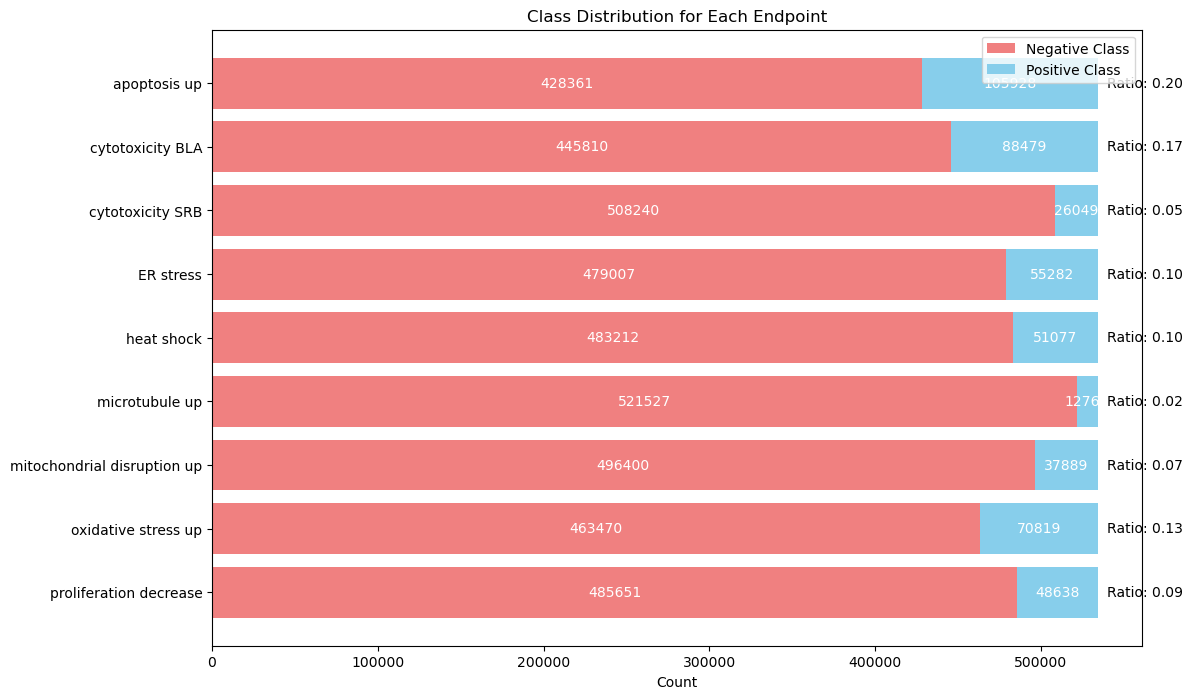

In [138]:
# get counts for positive and negative classes
positive_counts = endpoint_balance[1]
negative_counts = endpoint_balance[0]
endpoint_names = endpoint_balance.index

# plot the stacked horizontal bar chart
plt.figure(figsize=(12, 8))
plt.barh(endpoint_names, negative_counts, color='lightcoral', label='Negative Class')
plt.barh(endpoint_names, positive_counts, left=negative_counts, color='skyblue', label='Positive Class')

# labels and title
plt.xlabel('Count')
plt.title('Class Distribution for Each Endpoint')
plt.legend(loc='upper right')

# display values on bars
for index, (neg_count, pos_count) in enumerate(zip(negative_counts, positive_counts)):
    total_count = neg_count + pos_count
    plt.text(neg_count / 2, index, f"{neg_count}", va='center', ha='center', color='white')  # Negative class count
    plt.text(neg_count + pos_count / 2, index, f"{pos_count}", va='center', ha='center', color='white')  # Positive class count
    plt.text(total_count + 0.01 * total_count, index, f"Ratio: {(pos_count / total_count):.2f}", va='center', color='black')  # Ratio label

plt.gca().invert_yaxis()
plt.show()

- As it can be seen from the above endpoint label table, the true labels are ***heavily imbalanced***.

- Imbalanced classification tasks necessitates the use of ***F1-score***, which gives equal weight to ***precision*** (the proportion of correctly identified positives out of all predicted positives) and **recall** (the proportion of correctly identified positives out of actual positives).

- F1 is especially useful when ***positive cases are rare***, and you want to ***avoid*** false negatives (missing a positive case) while also limiting false positives (flagging negatives as positives). If you’re predicting cell behaviors or toxicities, a high F1 score indicates reliable detection of true positive cases (e.g., correctly identifying a toxicity effect).

- In biological settings, ***recall*** is often prioritized to avoid missing active endpoints, especially if detecting active cases is essential.

### Visualizing Folds

Source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html

In [159]:
print(f'Unique GroupID: {len(biomorph_cell_stats['GroupID'].unique())}')
print(f'Unique WellID: {len(biomorph_cell_stats['WellID'].unique())}')
print(f'Unique CPD_NAME: {len(biomorph_cell_stats['CPD_NAME'].unique())}')
print(f'Unique PlateID: {len(biomorph_cell_stats['PlateID'].unique())}')

Unique GroupID: 850
Unique WellID: 230
Unique CPD_NAME: 334
Unique PlateID: 10


Below code helps visualizing the grouping and stratifying structure, and also helps to comprehend why the high number of groups doesn't work for the nature of this dataset.

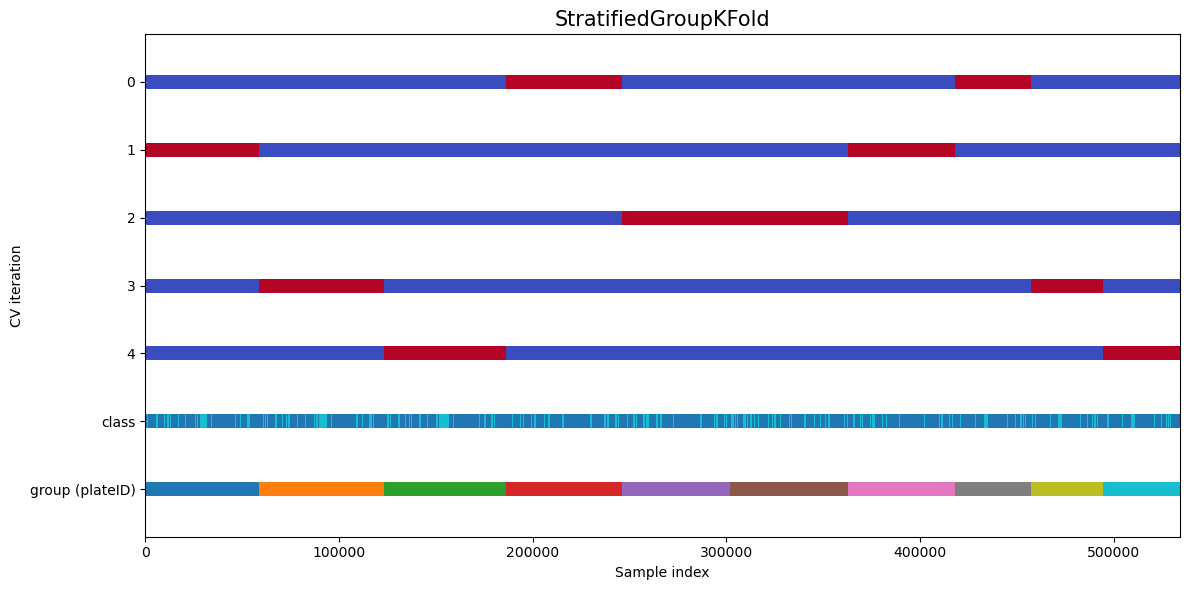

In [157]:
# Get unique groups and assign colors
unique_groups = biomorph_cell_stats['PlateID'].unique()
group_colors = {group: matplotlib.colormaps['tab10'](i / len(unique_groups)) for i, group in enumerate(unique_groups)}

def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""
    use_groups = "Group" in type(cv).__name__
    groups = group if use_groups else None
    
    # Generate the training/testing visualizations for each CV split
    for ii, (train_idx, test_idx) in enumerate(cv.split(X=X, y=y, groups=groups)):
        # Fill in indices with the training/test groups
        indices = np.full(len(X), np.nan)  # Start with NaNs for empty spots
        indices[test_idx] = 1  # Mark test indices as 1
        indices[train_idx] = 0  # Mark train indices as 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap="coolwarm",
            vmin=0, vmax=1,  # Specify limits for color mapping
        )

    # Plot the data classes at the end
    ax.scatter(
        range(len(X)), [n_splits + 0.5] * len(X), c=y, marker="_", lw=lw, cmap="tab10"
    )
    
    # Plot the groups at the end using a distinct color for each group
    group_colors_mapped = [group_colors[g] for g in group]  # Map each group to its assigned color
    ax.scatter(
        range(len(X)), [n_splits + 1.5] * len(X), c=group_colors_mapped, marker="_", lw=lw
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class", "group (plateID)"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, len(X)]
    )
    ax.set_title(f"{type(cv).__name__}", fontsize=15)
    return ax

# Initialize data for plotting
fig, ax = plt.subplots(figsize=(12, 6))
n_splits = 5
cv = StratifiedGroupKFold(n_splits=n_splits)
y = biomorph_cell_stats['apoptosis up']
X = biomorph_cell_stats[areashape_features]
groups = biomorph_cell_stats['PlateID']

# Plot cross-validation indices
plot_cv_indices(cv, X, y, groups, ax, n_splits)
plt.tight_layout()

### Visualizing Positive Instances

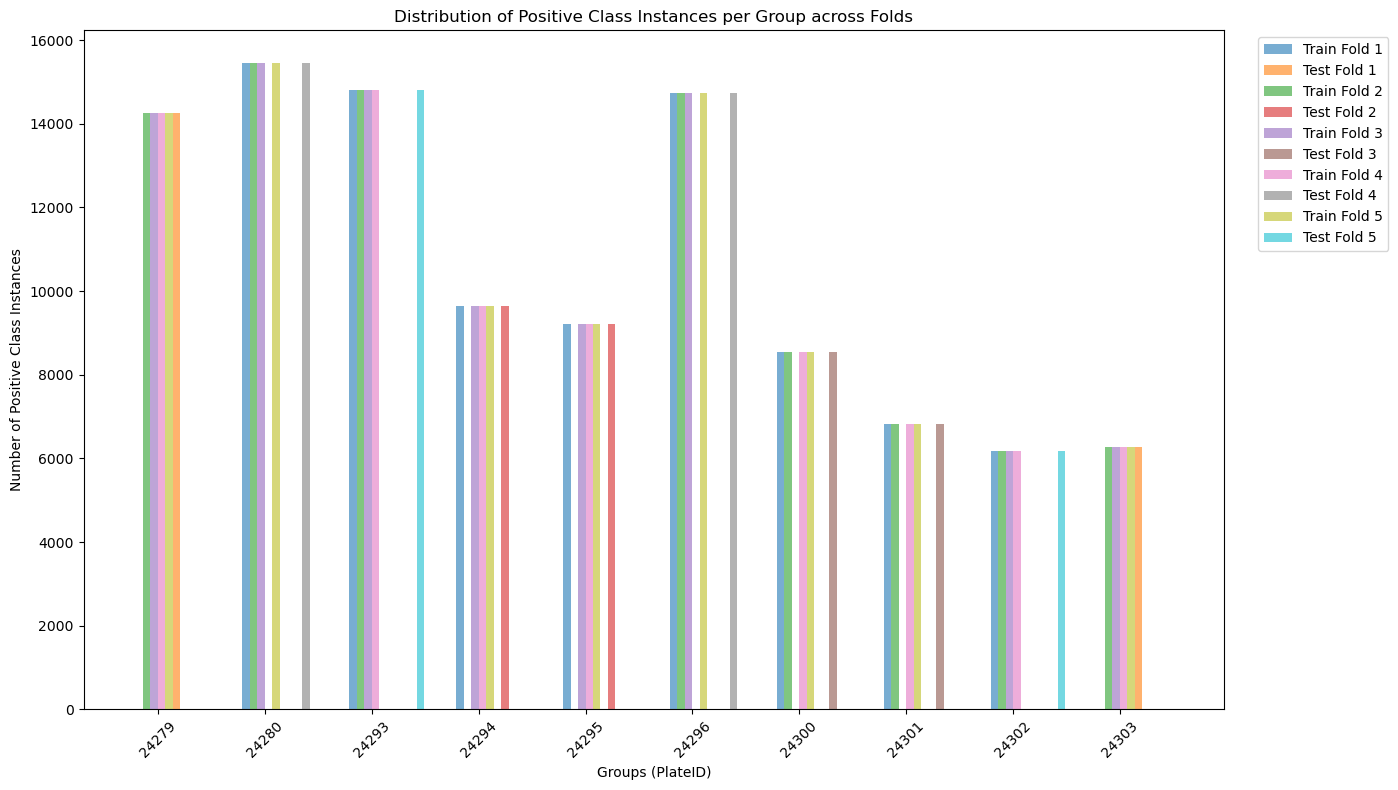

In [162]:
# Example data (replace these with your actual data variables)
X = biomorph_cell_stats[areashape_features[:1]]  # Predictor variables
y = biomorph_cell_stats['apoptosis up']  # Target variable
groups = biomorph_cell_stats['PlateID']  # Group identifiers (e.g., WellID + PlateID)

# Initialize StratifiedGroupKFold
n_splits = 5
stratified_group_kfold = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=97)

# Unique sorted groups for consistent order across folds
unique_groups = sorted(groups.unique())

# Dictionaries to hold positive class counts per fold for train and test
train_pos_counts = defaultdict(list)
test_pos_counts = defaultdict(list)

# Iterate through each fold to inspect class distributions
for fold, (train_idx, test_idx) in enumerate(stratified_group_kfold.split(X, y, groups), 1):
    # Extract train and test sets
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    groups_train, groups_test = groups.iloc[train_idx], groups.iloc[test_idx]
    
    # Count positive instances by group in the train and test sets for this fold
    train_fold_counts = Counter(groups_train[y_train == 1])
    test_fold_counts = Counter(groups_test[y_test == 1])
    
    # For each unique group, add the count or 0 if the group is missing in this fold
    train_pos_counts[fold] = [train_fold_counts.get(group, 0) for group in unique_groups]
    test_pos_counts[fold] = [test_fold_counts.get(group, 0) for group in unique_groups]

# Plot positive class distributions for each fold
fig, ax = plt.subplots(figsize=(14, 8))
width = 0.35  # Width of the bars

# Generate x-axis positions for each unique group
x_pos = np.arange(len(unique_groups))

# Loop through each fold to plot train and test positive class counts
for fold in range(1, n_splits + 1):
    ax.bar(x_pos - width/2 + (fold - 1) * width / n_splits, train_pos_counts[fold], width / n_splits, label=f'Train Fold {fold}', alpha=0.6)
    ax.bar(x_pos + width/2 + (fold - 1) * width / n_splits, test_pos_counts[fold], width / n_splits, label=f'Test Fold {fold}', alpha=0.6)

# Labeling and formatting
ax.set_xlabel("Groups (PlateID)")
ax.set_ylabel("Number of Positive Class Instances")
ax.set_title("Distribution of Positive Class Instances per Group across Folds")
ax.set_xticks(x_pos)
ax.set_xticklabels(unique_groups, rotation=45)
ax.legend(loc="upper right", bbox_to_anchor=(1.15, 1))

plt.tight_layout()
plt.show()

## 2.4. Feature Selection

### Correlation Thresholding

In [166]:
def feature_selection_corr(df: pd.DataFrame, threshold=0.95):
    # compute the correlation matrix of the dataframe
    corr_matrix = df.corr().abs()
    # select the upper triangle
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    # identify features with correlation greater than the threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    # drop identified features
    df_reduced = df.drop(columns=to_drop)
    print(f"Dropped {len(to_drop)} features due to correlation higher than {threshold}")
    return df_reduced

reduced_features_corr = feature_selection_corr(df=biomorph_cell_stats[areashape_features])

Dropped 21 features due to correlation higher than 0.95


### Variance Thresholding

In [167]:
def feature_selection_var(df: pd.DataFrame, threshold=0.01):
    selector = VarianceThreshold(threshold=threshold)
    df_reduced =  pd.DataFrame(selector.fit_transform(df), columns=df.columns[selector.get_support()])
    print(f"Dropped {len(df.columns) - len(df_reduced.columns)} features due to feature variation lower than {threshold}")
    return df

reduced_features_var = feature_selection_var(biomorph_cell_stats[areashape_features])
reduced_features_var

Dropped 9 features due to feature variation lower than 0.01


,Cells_AreaShape_Area,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_EulerNumber,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,Cells_AreaShape_MajorAxisLength,Cells_AreaShape_MaxFeretDiameter,...,Cytoplasm_AreaShape_MajorAxisLength,Cytoplasm_AreaShape_MaxFeretDiameter,Cytoplasm_AreaShape_MaximumRadius,Cytoplasm_AreaShape_MeanRadius,Cytoplasm_AreaShape_MedianRadius,Cytoplasm_AreaShape_MinFeretDiameter,Cytoplasm_AreaShape_MinorAxisLength,Cytoplasm_AreaShape_Orientation,Cytoplasm_AreaShape_Perimeter,Cytoplasm_AreaShape_Solidity
0,2794,121.0,0.0,2.308547,0.952278,1.0,0.540844,0.196944,122.384084,126.921235,...,132.113356,126.921235,16.278821,5.208891,4.472136,40.000000,39.290920,7.067082,503.820,0.655096
1,3864,365.0,0.0,1.206172,0.638567,1.0,0.583333,0.350644,86.225371,97.416631,...,92.718198,97.416631,15.132746,5.536788,5.000000,71.000000,70.607929,-13.927015,466.546,0.606196
2,953,414.0,28.0,1.246423,0.718658,1.0,0.566924,0.456650,45.150161,47.707442,...,52.497020,47.707442,5.656854,1.961349,1.414214,31.274055,36.786818,-25.140883,253.018,0.350082
3,2349,695.0,25.0,1.397739,0.856356,1.0,0.562500,0.452690,81.155383,90.426766,...,90.228382,90.426766,17.804494,4.684592,4.123106,45.815500,46.838102,-54.112353,355.674,0.643328
4,1802,311.0,34.0,1.260998,0.800166,1.0,0.484800,0.519521,65.183216,66.241981,...,80.327331,66.241981,6.708204,2.133990,2.000000,42.975843,45.966261,-41.848839,343.374,0.369829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534284,1123,165.0,495.0,1.100898,0.728624,1.0,0.702753,0.579036,46.285309,49.040799,...,55.233889,49.040799,5.656854,2.054158,2.000000,32.851351,36.275881,-84.987249,244.534,0.500991
534285,2387,536.0,496.0,1.108895,0.510906,1.0,0.672205,0.392252,62.203904,68.963759,...,69.863307,68.963759,10.770330,3.590967,3.162278,51.910267,59.023433,-9.293599,373.438,0.628099
534286,1232,198.0,501.0,1.163976,0.679647,1.0,0.623482,0.564820,48.710933,56.356011,...,50.251654,56.356011,11.401754,3.465339,3.000000,37.000000,34.816011,-53.382548,262.222,0.495643
534287,1287,498.0,519.0,1.181055,0.740574,1.0,0.643500,0.438198,51.619392,55.009090,...,62.964251,55.009090,10.198039,3.030611,2.236068,38.445314,39.837992,-77.981231,282.534,0.504642


### Variance Inflation Factor
- VIF quantifies the level of multicollinearity by measuring how much the variance of a regression coefficient increases due to the correlation between predictor variables.
- A high VIF value signals that multicollinearity is present, affecting the stability of the model.
- Multicollinearity is measured by selecting each feature and regressing it against all other features in the model. This process calculates how much the variance of a regression coefficient is inflated due to the correlations between independent variables.
- The VIF for each feature is given by: $$VIF = \frac{1}{1 - R^2}$$
- ${R^2}$ is the coefficient of determination in linear regression. It measures the proportion of variance in the dependent variable that is predictable from the independent variables, and it ranges between 0 and 1. A higher R-squared value suggests a stronger relationship between the feature and other predictors.
> **Complexity**: VIF calculation involves fitting a linear regression model for each feature against all other features. For each feature, it requires solving a regression problem, which can be computationally intensive. For each feature, it requires solving a regression problem, which can be computationally intensive: ${O(n^3)}$ for matrix inversion in regression.



In [159]:
def calculate_vif(X):
    vif = pd.DataFrame()
    vif['Feature'] = X.columns
    vif_values = []
    for i in range(X.shape[1]):
        try:
            vif_value = variance_inflation_factor(X.values, i)
        except np.linalg.LinAlgError:
            vif_value = np.inf  # assign infinite VIF if linear algebra error occurs
        if np.isnan(vif_value):
            vif_value = np.inf  # handle NaNs which can occur if R^2 is 1
        vif_values.append(vif_value)
    vif['VIF'] = vif_values
    return vif

def feature_selection_vif(df, thresh=5.0):
    # df = feature_selection_corr(df)
    # drop rows with missing values
    df = df.dropna()
    # subset the numeric features
    df = df.select_dtypes(include=[np.number])
    # identify and drop duplicate columns
    duplicate_columns = df.columns[df.columns.duplicated()]
    print(f"Duplicate columns: {duplicate_columns.tolist()}")
    df = df.loc[:, ~df.columns.duplicated()]
    # identify and drop constant columns
    constant_columns = [col for col in df.columns if df[col].nunique() == 1]
    print(f"Constant columns: {constant_columns}")
    df = df.drop(columns=constant_columns)
    # find pairs of features with correlation of 1 and drop one feature from each pair
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    perfect_corr = [(column, idx) for column in upper.columns for idx in upper.index if upper.loc[idx, column] == 1.0]
    print("Perfectly correlated feature pairs:")
    for pair in perfect_corr:
        print(pair)
    features_to_drop = set()
    for pair in perfect_corr:
        features_to_drop.add(pair[1])  # Choose one feature to drop
    df = df.drop(columns=list(features_to_drop))
    while True:
        vif_df = calculate_vif(df)
        max_vif = vif_df['VIF'].max()
        if max_vif > thresh:
            feature_to_drop = vif_df.sort_values('VIF', ascending=False)['Feature'].iloc[0]
            print(f"Dropping '{feature_to_drop}' with VIF = {max_vif:.2f}")
            df = df.drop(columns=[feature_to_drop])
        else:
            print("All features have VIF below the threshold.")
            break
    return df

# feature_selection_vif(biomorph_cell_stats[areashape_features])

Applying feature selection by VIF combined with pre-correlation elimination speeds up the process, and the final number of columns actually doesn't change.

In [169]:
reduced_features_vif_corr = feature_selection_vif(feature_selection_corr(biomorph_cell_stats[areashape_features]))
reduced_features_vif_corr

Dropped 21 features due to correlation higher than 0.95
Duplicate columns: []
Constant columns: []
Perfectly correlated feature pairs:
Dropping 'Cells_AreaShape_Solidity' with VIF = 6375.08
Dropping 'Nuclei_AreaShape_Solidity' with VIF = 3508.08
Dropping 'Cells_AreaShape_Extent' with VIF = 1486.82
Dropping 'Nuclei_AreaShape_MajorAxisLength' with VIF = 890.47
Dropping 'Cytoplasm_AreaShape_Solidity' with VIF = 586.25
Dropping 'Nuclei_AreaShape_MaximumRadius' with VIF = 461.27
Dropping 'Nuclei_AreaShape_Extent' with VIF = 312.67
Dropping 'Cells_AreaShape_MajorAxisLength' with VIF = 294.06
Dropping 'Nuclei_AreaShape_Compactness' with VIF = 238.91
Dropping 'Nuclei_AreaShape_MinFeretDiameter' with VIF = 237.44
Dropping 'Cells_AreaShape_Eccentricity' with VIF = 200.12
Dropping 'Cells_AreaShape_EulerNumber' with VIF = 196.98
Dropping 'Nuclei_AreaShape_EulerNumber' with VIF = 127.91
Dropping 'Cells_AreaShape_Perimeter' with VIF = 113.86
Dropping 'Cells_AreaShape_MaximumRadius' with VIF = 104.55

,Cells_AreaShape_Area,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,Cells_AreaShape_Orientation,Nuclei_AreaShape_Orientation,Cytoplasm_AreaShape_Compactness,Cytoplasm_AreaShape_EulerNumber,Cytoplasm_AreaShape_Orientation
0,2794,121.0,0.0,7.328998,29.737063,3.172947,0.0,7.067082
1,3864,365.0,0.0,-14.133373,-9.549096,1.636543,0.0,-13.927015
2,953,414.0,28.0,-39.174569,-37.929103,3.800218,0.0,-25.140883
3,2349,695.0,25.0,-55.128014,-58.478322,2.380708,0.0,-54.112353
4,1802,311.0,34.0,-44.067412,-50.190880,4.166914,0.0,-41.848839
...,...,...,...,...,...,...,...,...
534284,1123,165.0,495.0,-82.250039,-81.339286,2.716075,0.0,-84.987249
534285,2387,536.0,496.0,-11.532190,-58.458009,1.843011,0.0,-9.293599
534286,1232,198.0,501.0,-39.625541,-89.609927,2.065627,0.0,-53.382548
534287,1287,498.0,519.0,-77.131537,-57.716555,2.869032,0.0,-77.981231


### Principal Component Analysis
- Reduces dimensionality by transforming features into a smaller set of uncorrelated components.
- PCA algorithm is highly sensitive to the scale of data, thus needs some standardization.
- PCA components are not easily interpretable in terms of original features.
> **Complexity:** PCA primarily involves performing Singular Value Decomposition (SVD) or Eigenvalue Decomposition on the covariance matrix of the data. These decompositions are optimized and can handle large matrices efficiently, and allows for a ***single decomposition*** operation, regardless of the number of features.

In [170]:
def feature_transformation_pca(df, retained_variance=0.9):
    # standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df)
    # apply PCA
    pca = PCA(n_components=0.95)  # retain 95% of variance
    X_pca = pca.fit_transform(X_scaled)
    print(f"Number of components selected: {pca.n_components_}")
    # create a dataFrame with principal components
    df_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(pca.n_components_)])
    # reconstruct the data from the principal components and measure the difference from the original data
    X_reconstructed = pca.inverse_transform(X_pca)
    reconstruction_error = ((X_scaled - X_reconstructed) ** 2).mean()
    print(f"Reconstruction Error: {reconstruction_error:.2f}")
    return df_pca

reduced_features_pca = feature_transformation_pca(biomorph_cell_stats[areashape_features])
reduced_features_pca

Number of components selected: 16
Reconstruction Error: 0.04


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16
0,2.642273,0.558610,5.268168,-2.884524,-1.800995,-3.018707,0.842985,0.613529,0.137849,-1.419670,-0.136761,-0.035271,0.444767,1.299703,1.801312,-1.785572
1,3.792674,4.277408,1.093276,-0.727766,0.364284,-3.118450,-1.974195,-0.582100,0.523165,0.306260,0.664929,-0.295448,-0.007968,-0.137049,0.926913,1.206573
2,-5.274406,-2.001467,-1.990287,-1.353140,0.764240,-2.870661,-0.392833,-1.095044,0.228779,-0.537393,1.362403,-0.483659,-0.294175,-0.131203,0.018159,0.385682
3,1.600256,1.947220,1.065756,0.457503,3.122087,-2.838874,2.442413,-1.576498,-0.238007,-0.809247,0.249304,0.312547,-0.381070,-0.920891,-0.528381,-0.252332
4,-0.506192,-4.377152,-3.021063,0.326078,-0.415403,-2.767101,1.200660,-1.281449,-0.094023,-0.221427,1.235368,0.142369,-0.392894,-1.660081,-0.765661,0.324066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534284,-4.944161,0.791869,-1.679533,0.433903,-1.883775,2.886374,1.618950,-2.542238,-0.134246,-0.052039,0.411283,-0.326185,-0.416128,0.245832,0.622468,0.409202
534285,0.047082,4.046417,-2.419704,-0.692331,1.603803,3.012648,-1.374970,-0.953244,0.333653,-1.062305,-1.314329,0.544346,-0.910204,0.644373,1.055529,-1.712593
534286,-3.439538,0.332188,-0.857018,2.366898,-1.672090,2.885487,0.676793,-1.798835,-0.061439,-0.851895,0.390432,0.183696,-0.993575,-0.039722,0.016291,0.972688
534287,-3.389850,0.964724,-1.585772,-1.046011,1.240239,3.158467,0.455650,-2.375028,0.081110,-1.335508,-0.455767,0.155573,-0.090983,0.850114,0.310841,-0.268134


# 3. Classifier Modeling

- Since each endpoint represents a separate type of activity, building ***separate classifiers*** for each endpoint (like apoptosis up) is a reasonable approach. This way, each classifier can be optimized for the characteristics of its specific endpoint. However, if these endpoints are often activated together, a multi-label classification model could be beneficial, as it learns patterns across the endpoints simultaneously. **Next: The potential for multi-label will be investigated.**

- Including ***compound names*** could be useful since certain compounds are known to induce specific responses, but encoding must be done carefully. **Next: Categorical data encoding will be investigated.**
- Scaling using ***StandardScaler*** is done to mitigate potential sensitivity problems that might occur in feature-scale-sensitive model types. Random forest is not one of them, but still it is good practice.
- Since each WellID has multiple FieldIDs, treating them as groups using ***StratifiedGroupKFold*** ensures that fields from the same well don’t appear in both training and test sets, preventing data leakage and preserving the independence of samples.

## Baseline v1

- One target endpoint
- Two predictor features
- One model (random forest)
- Stratified Cross-Validation
- No Grouped-Folding
- No hyperparemeter tuning

The model is able to successfully run with `F1 = 0.15` performance.

In [309]:
# # logging configuration
# logging.basicConfig(
#     level=logging.INFO,
#     format='%(asctime)s - %(levelname)s - %(message)s',
#     handlers=[logging.FileHandler("simplified_model.log"), logging.StreamHandler()])

# # set up variables
# random_state = 97
# data = biomorph_cell_stats
# predictors = areashape_features[:2]
# targets = endpoint_columns[:1]
# prediction_results = []

# # initialize cross-validation with StratifiedKFold (no grouping)
# n_splits = 5
# strat_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

# # initialize a RandomForest pipeline with scaling
# pipeline = Pipeline([
#     ('scaler', StandardScaler()),
#     ('classifier', RandomForestClassifier(random_state=random_state, class_weight='balanced', n_jobs=-1))
# ])

# # train a separate model for each endpoint
# for endpoint in tqdm(targets, desc="Processing Endpoints", unit="endpoint"):

#     # set the variables
#     y = biomorph_cell_stats[endpoint]
#     X = biomorph_cell_stats[predictors]

#     # initiate an error-handler and run cross-validation to train and test the model
#     try:
#         scoring_metrics = ['accuracy', 'roc_auc', 'f1', 'precision', 'recall']
#         cv_results = cross_validate(
#             pipeline,
#             X,
#             y,
#             cv=strat_kfold,
#             scoring=scoring_metrics,
#             return_train_score=False,
#             n_jobs=-1
#         )

#         # aggregate metrics using np.nanmean to handle potential NaNs
#         mean_accuracy = np.nanmean(cv_results['test_accuracy'])
#         mean_roc_auc = np.nanmean(cv_results['test_roc_auc']) if 'test_roc_auc' in cv_results else np.nan
#         mean_f1 = np.nanmean(cv_results['test_f1'])
#         mean_precision = np.nanmean(cv_results['test_precision'])
#         mean_recall = np.nanmean(cv_results['test_recall'])

#         # append the results
#         prediction_results.append({
#             'Endpoint': endpoint,
#             'Mean_Accuracy': mean_accuracy,
#             'Mean_ROC_AUC': mean_roc_auc,
#             'Mean_F1_Score': mean_f1,
#             'Mean_Precision': mean_precision,
#             'Mean_Recall': mean_recall
#         })

#         logging.info(
#             f"Endpoint '{endpoint}' - Accuracy: {mean_accuracy:.4f}, "
#             f"ROC AUC: {mean_roc_auc:.4f}, F1: {mean_f1:.4f}, "
#             f"Precision: {mean_precision:.4f}, Recall: {mean_recall:.4f}"
#         )

#     except Exception as e:
#         logging.error(f"An error occurred during modeling for endpoint '{endpoint}': {e}")
#         prediction_results.append({
#             'Endpoint': endpoint,
#             'Mean_Accuracy': np.nan,
#             'Mean_ROC_AUC': np.nan,
#             'Mean_F1_Score': np.nan,
#             'Mean_Precision': np.nan,
#             'Mean_Recall': np.nan
#         })

# prediction_results_df = pd.DataFrame(prediction_results)
# prediction_results_df

In [85]:
# # logging configuration
# logging.basicConfig(
#     level=logging.INFO,
#     format='%(asctime)s - %(levelname)s - %(message)s',
#     handlers=[logging.FileHandler("simplified_model.log"), logging.StreamHandler()])

# # set up variables
# random_state = 97
# data = biomorph_cell_stats
# predictors = areashape_features[:2]
# targets = endpoint_columns
# prediction_results = []

# # initialize cross-validation with StratifiedKFold (no grouping)
# n_splits = 5
# strat_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

# # initialize a RandomForest pipeline with scaling
# pipeline = Pipeline([
#     ('scaler', StandardScaler()),
#     ('classifier', RandomForestClassifier(random_state=random_state, class_weight='balanced', n_jobs=-1))
# ])

# # train a separate model for each endpoint
# for endpoint in tqdm(targets, desc="Processing Endpoints", unit="endpoint"):

#     # set the variables
#     y = biomorph_cell_stats[endpoint]
#     X = biomorph_cell_stats[predictors]

#     # initiate an error-handler and run cross-validation to train and test the model
#     try:
#         scoring_metrics = ['accuracy', 'roc_auc', 'f1', 'precision', 'recall']
#         cv_results = cross_validate(
#             pipeline,
#             X,
#             y,
#             cv=strat_kfold,
#             scoring=scoring_metrics,
#             return_train_score=False,
#             n_jobs=-1
#         )

#         # aggregate metrics using np.nanmean to handle potential NaNs
#         mean_accuracy = np.nanmean(cv_results['test_accuracy'])
#         mean_roc_auc = np.nanmean(cv_results['test_roc_auc']) if 'test_roc_auc' in cv_results else np.nan
#         mean_f1 = np.nanmean(cv_results['test_f1'])
#         mean_precision = np.nanmean(cv_results['test_precision'])
#         mean_recall = np.nanmean(cv_results['test_recall'])

#         # append the results
#         prediction_results.append({
#             'Endpoint': endpoint,
#             'Mean_Accuracy': mean_accuracy.round(4),
#             'Mean_ROC_AUC': mean_roc_auc.round(4),
#             'Mean_F1_Score': mean_f1.round(4),
#             'Mean_Precision': mean_precision.round(4),
#             'Mean_Recall': mean_recall.round(4)
#         })

#         logging.info(
#             f"Endpoint '{endpoint}' - Accuracy: {mean_accuracy:.4f}, "
#             f"ROC AUC: {mean_roc_auc:.4f}, F1: {mean_f1:.4f}, "
#             f"Precision: {mean_precision:.4f}, Recall: {mean_recall:.4f}"
#         )

#     except Exception as e:
#         logging.error(f"An error occurred during modeling for endpoint '{endpoint}': {e}")
#         prediction_results.append({
#             'Endpoint': endpoint,
#             'Mean_Accuracy': np.nan,
#             'Mean_ROC_AUC': np.nan,
#             'Mean_F1_Score': np.nan,
#             'Mean_Precision': np.nan,
#             'Mean_Recall': np.nan
#         })

# prediction_results_df = pd.DataFrame(prediction_results)
# prediction_results_df

Processing Endpoints: 100%|██████████| 9/9 [08:41<00:00, 57.90s/endpoint]


,Endpoint,Mean_Accuracy,Mean_ROC_AUC,Mean_F1_Score,Mean_Precision,Mean_Recall
0,apoptosis up,0.726610,0.501202,0.152564,0.197943,0.124120
1,cytotoxicity BLA,0.770595,0.498475,0.119179,0.163652,0.093722
2,cytotoxicity SRB,0.936327,0.498899,0.022295,0.044362,0.014894
3,ER stress,0.861292,0.500602,0.060828,0.101606,0.043410
4,heat shock,0.864440,0.499110,0.065034,0.095488,0.049332
5,microtubule up,0.969901,0.502178,0.008383,0.019672,0.005328
6,mitochondrial disruption up,0.902689,0.500749,0.040830,0.067816,0.029215
7,oxidative stress up,0.816833,0.501061,0.091921,0.134042,0.069949
8,proliferation decrease,0.878490,0.497635,0.050730,0.087823,0.035670


## Baseline v2

- One target endpoint
- Two predictor features
- `Multiple models (Random forest, logistic regression, gradient boosting)`
- Stratified Cross-Validation
- No Grouped-Folding
- No hyperparemeter tuning

The best performing model is logistic regression with `F1 = 0.27` score.

In [52]:
# # logging configuration
# logging.basicConfig(
#     level=logging.INFO,
#     format='%(asctime)s - %(levelname)s - %(message)s',
#     handlers=[logging.FileHandler("simplified_model.log"), logging.StreamHandler()])

# # set up variables
# random_state = 97
# data = biomorph_cell_stats
# predictors = areashape_features[:2]
# targets = endpoint_columns[:1]
# prediction_results = []

# # initialize cross-validation with StratifiedKFold (no grouping)
# n_splits = 5
# strat_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

# # define the models
# models = {
#     'RandomForest': RandomForestClassifier(random_state=random_state, class_weight='balanced', n_jobs=-1),
#     'LogisticRegression': LogisticRegression(random_state=random_state, class_weight='balanced', max_iter=1000),
#     'GradientBoosting': GradientBoostingClassifier(random_state=random_state)
# }

# # parse through each endpoint
# for endpoint in targets:

#     # set the variables
#     y = biomorph_cell_stats[endpoint]
#     X = biomorph_cell_stats[predictors]

#     # parse through each model object
#     for model_name, model in tqdm(models.items(), desc="Testing Models", unit="model"):

#         # initialize the pipeline with scaling and the next available model
#         pipeline = Pipeline([
#             ('scaler', StandardScaler()),
#             ('classifier', model)
#         ])

#         # initiate an error-handler and run cross-validation to train and test the model
#         try:
#             scoring_metrics = ['accuracy', 'roc_auc', 'f1', 'precision', 'recall']
#             cv_results = cross_validate(
#                 pipeline,
#                 X,
#                 y,
#                 cv=strat_kfold,
#                 scoring=scoring_metrics,
#                 return_train_score=False,
#                 n_jobs=-1
#             )

#             # aggregate metrics using np.nanmean to handle potential NaNs
#             mean_accuracy = np.nanmean(cv_results['test_accuracy'])
#             mean_roc_auc = np.nanmean(cv_results['test_roc_auc']) if 'test_roc_auc' in cv_results else np.nan
#             mean_f1 = np.nanmean(cv_results['test_f1'])
#             mean_precision = np.nanmean(cv_results['test_precision'])
#             mean_recall = np.nanmean(cv_results['test_recall'])

#             # append the results
#             prediction_results.append({
#                 'Endpoint': endpoint,
#                 'Model': model_name,
#                 'Mean_Accuracy': mean_accuracy,
#                 'Mean_ROC_AUC': mean_roc_auc,
#                 'Mean_F1_Score': mean_f1,
#                 'Mean_Precision': mean_precision,
#                 'Mean_Recall': mean_recall
#             })

#             logging.info(
#                 f"Endpoint '{endpoint}', Model '{model_name}' - "
#                 f"Accuracy: {mean_accuracy:.4f}, ROC AUC: {mean_roc_auc:.4f}, "
#                 f"F1: {mean_f1:.4f}, Precision: {mean_precision:.4f}, Recall: {mean_recall:.4f}"
#             )

#         except Exception as e:
#             logging.error(f"An error occurred during modeling for endpoint '{endpoint}', model '{model_name}': {e}")
#             prediction_results.append({
#                 'Endpoint': endpoint,
#                 'Model': model_name,
#                 'Mean_Accuracy': np.nan,
#                 'Mean_ROC_AUC': np.nan,
#                 'Mean_F1_Score': np.nan,
#                 'Mean_Precision': np.nan,
#                 'Mean_Recall': np.nan
#             })

# prediction_results_df = pd.DataFrame(prediction_results)
# prediction_results_df

Testing Models: 100%|██████████| 3/3 [01:31<00:00, 30.43s/model]


,Endpoint,Model,Mean_Accuracy,Mean_ROC_AUC,Mean_F1_Score,Mean_Precision,Mean_Recall
0,apoptosis up,RandomForest,0.726610,0.501202,0.152564,0.197943,0.124120
1,apoptosis up,LogisticRegression,0.570389,0.516127,0.275245,0.206795,0.411448
2,apoptosis up,GradientBoosting,0.801701,0.515337,0.000189,0.280000,0.000094


## Baseline v3

- `All nine target endpoints`
- Two predictor features
- Multiple models (Random forest, logistic regression, gradient boosting)
- Stratified Cross-Validation
- No Grouped-Folding
- No hyperparemeter tuning

In all of the endpoints the best performing model is **logistic regression**.

In [86]:
# # logging configuration
# logging.basicConfig(
#     level=logging.INFO,
#     format='%(asctime)s - %(levelname)s - %(message)s',
#     handlers=[logging.FileHandler("simplified_model.log"), logging.StreamHandler()])

# # set up variables
# random_state = 97
# data = biomorph_cell_stats
# predictors = areashape_features[:2]
# targets = endpoint_columns
# prediction_results = []

# # initialize cross-validation with StratifiedKFold (no grouping)
# n_splits = 5
# strat_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

# # define the models
# models = {
#     'RandomForest': RandomForestClassifier(random_state=random_state, 
#                                            class_weight='balanced',
#                                            n_jobs=-1),
#     'LogisticRegression': LogisticRegression(random_state=random_state, 
#                                              class_weight='balanced', 
#                                              max_iter=1000),
#     'GradientBoosting': GradientBoostingClassifier(random_state=random_state)
# }

# # parse through each endpoint
# for endpoint in targets:

#     # set the variables
#     y = biomorph_cell_stats[endpoint]
#     X = biomorph_cell_stats[predictors]

#     # parse through each model object
#     for model_name, model in tqdm(models.items(), desc="Testing Models", unit="model"):

#         # initialize the pipeline with scaling and the next available model
#         pipeline = Pipeline([
#             ('scaler', StandardScaler()),
#             ('classifier', model)
#         ])

#         # initiate an error-handler and run cross-validation to train and test the model
#         try:
#             scoring_metrics = ['accuracy', 'roc_auc', 'f1', 'precision', 'recall']
#             cv_results = cross_validate(
#                 pipeline,
#                 X,
#                 y,
#                 cv=strat_kfold,
#                 scoring=scoring_metrics,
#                 return_train_score=False,
#                 n_jobs=-1
#             )

#             # aggregate metrics using np.nanmean to handle potential NaNs
#             mean_accuracy = np.nanmean(cv_results['test_accuracy'])
#             mean_roc_auc = np.nanmean(cv_results['test_roc_auc']) if 'test_roc_auc' in cv_results else np.nan
#             mean_f1 = np.nanmean(cv_results['test_f1'])
#             mean_precision = np.nanmean(cv_results['test_precision'])
#             mean_recall = np.nanmean(cv_results['test_recall'])

#             # append the results
#             prediction_results.append({
#                 'Endpoint': endpoint,
#                 'Model': model_name,
#                 'Mean_Accuracy': mean_accuracy,
#                 'Mean_ROC_AUC': mean_roc_auc,
#                 'Mean_F1_Score': mean_f1,
#                 'Mean_Precision': mean_precision,
#                 'Mean_Recall': mean_recall
#             })

#             logging.info(
#                 f"Endpoint '{endpoint}', Model '{model_name}' - "
#                 f"Accuracy: {mean_accuracy:.4f}, ROC AUC: {mean_roc_auc:.4f}, "
#                 f"F1: {mean_f1:.4f}, Precision: {mean_precision:.4f}, Recall: {mean_recall:.4f}"
#             )

#         except Exception as e:
#             logging.error(f"An error occurred during modeling for endpoint '{endpoint}', model '{model_name}': {e}")
#             prediction_results.append({
#                 'Endpoint': endpoint,
#                 'Model': model_name,
#                 'Mean_Accuracy': np.nan,
#                 'Mean_ROC_AUC': np.nan,
#                 'Mean_F1_Score': np.nan,
#                 'Mean_Precision': np.nan,
#                 'Mean_Recall': np.nan
#             })

# prediction_results_df = pd.DataFrame(prediction_results)
# prediction_results_df

Testing Models:  33%|███▎      | 1/3 [01:00<02:00, 60.48s/model]/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
2024-11-12 16:17:53,729 - INFO - Endpoint 'cytotoxicity BLA', Model 'LogisticRegression' - Accuracy: 0.5754, ROC AUC: 0.5155, F1: 0.2429, Precision: 0.1724, Recall: 0.4114
Testing Models:  67%|██████▋   | 2/3 [00:52<00:21, 21.90s/model]/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/metrics/_class

,Endpoint,Model,Mean_Accuracy,Mean_ROC_AUC,Mean_F1_Score,Mean_Precision,Mean_Recall
0,apoptosis up,RandomForest,0.726610,0.501202,0.152564,0.197943,0.124120
1,apoptosis up,LogisticRegression,0.570389,0.516127,0.275245,0.206795,0.411448
2,apoptosis up,GradientBoosting,0.801701,0.515337,0.000189,0.280000,0.000094
3,cytotoxicity BLA,RandomForest,0.770595,0.498475,0.119179,0.163652,0.093722
4,cytotoxicity BLA,LogisticRegression,0.575379,0.515525,0.242943,0.172366,0.411414
5,cytotoxicity BLA,GradientBoosting,0.834395,0.514306,0.000158,0.450000,0.000079
6,cytotoxicity SRB,RandomForest,0.936327,0.498899,0.022295,0.044362,0.014894
7,cytotoxicity SRB,LogisticRegression,0.616857,0.531537,0.095883,0.054174,0.416683
8,cytotoxicity SRB,GradientBoosting,0.951234,0.527901,0.000000,0.000000,0.000000
9,ER stress,RandomForest,0.861292,0.500602,0.060828,0.101606,0.043410


## Baseline v4

- All nine target endpoints
- Two predictor features
- Multiple models (Random forest, logistic regression, gradient boosting)
- Stratified Cross-Validation
- `Grouped by PlateID (to prevent model bias)`
- No hyperparemeter tuning

Grouping by PlateID works, compared to grouping by GroupID or WellID which causes too many splits to lack positive class instances. ***By grouping by PlateID we get rid of the model bias (by keeping the same-annotated cells together) while losing F1-score by only a small margin.***

In [124]:
# # logging configuration
# logging.basicConfig(
#     level=logging.INFO,
#     format='%(asctime)s - %(levelname)s - %(message)s',
#     handlers=[logging.FileHandler("simplified_model.log"), logging.StreamHandler()])

# # set up variables
# random_state = 97
# data = biomorph_cell_stats
# predictors = areashape_features[:2]
# targets = endpoint_columns
# prediction_results = []

# # initialize cross-validation with StratifiedGroupKFold (plateID as the grouping factor)
# groups = data['PlateID']
# n_splits = 3
# strat_group_kfold = StratifiedGroupKFold(n_splits=n_splits,
#                                          shuffle=True,
#                                          random_state=random_state)

# # define the models
# models = {
#     'RandomForest': RandomForestClassifier(random_state=random_state, 
#                                            class_weight='balanced',
#                                            n_jobs=-1),
#     'LogisticRegression': LogisticRegression(random_state=random_state, 
#                                              class_weight='balanced', 
#                                              max_iter=1000),
#     'GradientBoosting': GradientBoostingClassifier(random_state=random_state)
# }

# # parse through each endpoint
# for endpoint in targets:

#     # set the variables
#     y = data[endpoint]
#     X = data[predictors]

#     # parse through each model object
#     for model_name, model in tqdm(models.items(), desc="Testing Models", unit="model"):

#         # initialize the pipeline with scaling and the next available model
#         pipeline = Pipeline([
#             ('scaler', StandardScaler()),
#             ('classifier', model)
#         ])

#         # initiate an error-handler and run cross-validation to train and test the model
#         try:
#             scoring_metrics = ['accuracy', 'roc_auc', 'f1', 'precision', 'recall']
#             cv_results = cross_validate(
#                 pipeline,
#                 X,
#                 y,
#                 cv=strat_group_kfold.split(X, y, groups=groups), # use PlateID as grouping variable
#                 scoring=scoring_metrics,
#                 return_train_score=False,
#                 n_jobs=-1
#             )

#             # aggregate metrics using np.nanmean to handle potential NaNs
#             mean_accuracy = np.nanmean(cv_results['test_accuracy'])
#             mean_roc_auc = np.nanmean(cv_results['test_roc_auc']) if 'test_roc_auc' in cv_results else np.nan
#             mean_f1 = np.nanmean(cv_results['test_f1'])
#             mean_precision = np.nanmean(cv_results['test_precision'])
#             mean_recall = np.nanmean(cv_results['test_recall'])

#             # append the results
#             prediction_results.append({
#                 'Endpoint': endpoint,
#                 'Model': model_name,
#                 'Mean_Accuracy': mean_accuracy,
#                 'Mean_ROC_AUC': mean_roc_auc,
#                 'Mean_F1_Score': mean_f1,
#                 'Mean_Precision': mean_precision,
#                 'Mean_Recall': mean_recall
#             })

#             logging.info(
#                 f"Endpoint '{endpoint}', Model '{model_name}' - "
#                 f"Accuracy: {mean_accuracy:.4f}, ROC AUC: {mean_roc_auc:.4f}, "
#                 f"F1: {mean_f1:.4f}, Precision: {mean_precision:.4f}, Recall: {mean_recall:.4f}"
#             )

#         except Exception as e:
#             logging.error(f"An error occurred during modeling for endpoint '{endpoint}', model '{model_name}': {e}")
#             prediction_results.append({
#                 'Endpoint': endpoint,
#                 'Model': model_name,
#                 'Mean_Accuracy': np.nan,
#                 'Mean_ROC_AUC': np.nan,
#                 'Mean_F1_Score': np.nan,
#                 'Mean_Precision': np.nan,
#                 'Mean_Recall': np.nan
#             })

# prediction_results_df = pd.DataFrame(prediction_results)
# prediction_results_df

Testing Models:  67%|██████▋   | 2/3 [00:28<00:11, 11.88s/model]/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2024-11-13 16:50:14,144 - INFO - Endpoint 'cytotoxicity SRB', Model 'GradientBoosting' - Accuracy: 0.9517, ROC AUC: 0.5293, F1: 0.0000, Precision: 0.0000, Recall: 0.0000
Testing Models:  67%|██████▋   | 2/3 [00:33<00:13, 13.88s/model]/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2024-11-13 16:51:57,201 - INFO

,Endpoint,Model,Mean_Accuracy,Mean_ROC_AUC,Mean_F1_Score,Mean_Precision,Mean_Recall
0,apoptosis up,RandomForest,0.729428,0.500334,0.149665,0.198770,0.120297
1,apoptosis up,LogisticRegression,0.570353,0.515776,0.274584,0.206408,0.410541
2,apoptosis up,GradientBoosting,0.801753,0.513702,0.000287,0.395623,0.000143
3,cytotoxicity BLA,RandomForest,0.773655,0.499794,0.117236,0.165558,0.092066
4,cytotoxicity BLA,LogisticRegression,0.574317,0.514971,0.241758,0.171472,0.412654
5,cytotoxicity BLA,GradientBoosting,0.835060,0.514449,0.000101,0.177778,0.000051
6,cytotoxicity SRB,RandomForest,0.938465,0.499562,0.021737,0.047100,0.014273
7,cytotoxicity SRB,LogisticRegression,0.616869,0.532652,0.094800,0.053560,0.417286
8,cytotoxicity SRB,GradientBoosting,0.951681,0.529259,0.000000,0.000000,0.000000
9,ER stress,RandomForest,0.864955,0.499538,0.057355,0.100930,0.040552


## Baseline v5

- All nine target endpoints
- `Ten predictor features`
- `Single model (logistic regression)`
- Stratified Cross-Validation
- Grouped by PlateID (to prevent model bias)
- No hyperparemeter tuning

Introducing more features into logistic regression increased its F1-score by keeping the precision at the same level and increasing its recall performance by .07-.09 points.

In [126]:
# # logging configuration
# logging.basicConfig(
#     level=logging.INFO,
#     format='%(asctime)s - %(levelname)s - %(message)s',
#     handlers=[logging.FileHandler("simplified_model.log"), logging.StreamHandler()])

# # set up variables
# random_state = 97
# data = biomorph_cell_stats
# predictors = areashape_features[:11]
# targets = endpoint_columns
# prediction_results = []

# # initialize cross-validation with StratifiedGroupKFold (plateID as the grouping factor)
# groups = data['PlateID']
# n_splits = 3
# strat_group_kfold = StratifiedGroupKFold(n_splits=n_splits,
#                                          shuffle=True,
#                                          random_state=random_state)

# # define the models
# models = {
#     # 'RandomForest': RandomForestClassifier(random_state=random_state, 
#     #                                        class_weight='balanced',
#     #                                        n_jobs=-1),
#     'LogisticRegression': LogisticRegression(random_state=random_state, 
#                                              class_weight='balanced', 
#                                              max_iter=1000),
#     # 'GradientBoosting': GradientBoostingClassifier(random_state=random_state)
# }

# # parse through each endpoint
# for endpoint in targets:

#     # set the variables
#     y = data[endpoint]
#     X = data[predictors]

#     # parse through each model object
#     for model_name, model in tqdm(models.items(), desc="Testing Models", unit="model"):

#         # initialize the pipeline with scaling and the next available model
#         pipeline = Pipeline([
#             ('scaler', StandardScaler()),
#             ('classifier', model)
#         ])

#         # initiate an error-handler and run cross-validation to train and test the model
#         try:
#             scoring_metrics = ['accuracy', 'roc_auc', 'f1', 'precision', 'recall']
#             cv_results = cross_validate(
#                 pipeline,
#                 X,
#                 y,
#                 cv=strat_group_kfold.split(X, y, groups=groups), # use PlateID as grouping variable
#                 scoring=scoring_metrics,
#                 return_train_score=False,
#                 n_jobs=-1
#             )

#             # aggregate metrics using np.nanmean to handle potential NaNs
#             mean_accuracy = np.nanmean(cv_results['test_accuracy'])
#             mean_roc_auc = np.nanmean(cv_results['test_roc_auc']) if 'test_roc_auc' in cv_results else np.nan
#             mean_f1 = np.nanmean(cv_results['test_f1'])
#             mean_precision = np.nanmean(cv_results['test_precision'])
#             mean_recall = np.nanmean(cv_results['test_recall'])

#             # append the results
#             prediction_results.append({
#                 'Endpoint': endpoint,
#                 'Model': model_name,
#                 'Mean_Accuracy': mean_accuracy,
#                 'Mean_ROC_AUC': mean_roc_auc,
#                 'Mean_F1_Score': mean_f1,
#                 'Mean_Precision': mean_precision,
#                 'Mean_Recall': mean_recall
#             })

#             logging.info(
#                 f"Endpoint '{endpoint}', Model '{model_name}' - "
#                 f"Accuracy: {mean_accuracy:.4f}, ROC AUC: {mean_roc_auc:.4f}, "
#                 f"F1: {mean_f1:.4f}, Precision: {mean_precision:.4f}, Recall: {mean_recall:.4f}"
#             )

#         except Exception as e:
#             logging.error(f"An error occurred during modeling for endpoint '{endpoint}', model '{model_name}': {e}")
#             prediction_results.append({
#                 'Endpoint': endpoint,
#                 'Model': model_name,
#                 'Mean_Accuracy': np.nan,
#                 'Mean_ROC_AUC': np.nan,
#                 'Mean_F1_Score': np.nan,
#                 'Mean_Precision': np.nan,
#                 'Mean_Recall': np.nan
#             })

# prediction_results_df = pd.DataFrame(prediction_results)
# prediction_results_df

Testing Models: 100%|██████████| 1/1 [00:00<00:00,  1.05model/s]


,Endpoint,Model,Mean_Accuracy,Mean_ROC_AUC,Mean_F1_Score,Mean_Precision,Mean_Recall
0,apoptosis up,LogisticRegression,0.528742,0.524776,0.295917,0.210133,0.500327
1,cytotoxicity BLA,LogisticRegression,0.537016,0.521506,0.256424,0.174592,0.485225
2,cytotoxicity SRB,LogisticRegression,0.559623,0.549082,0.100227,0.055657,0.510951
3,ER stress,LogisticRegression,0.548967,0.531192,0.181800,0.111611,0.490976
4,heat shock,LogisticRegression,0.526229,0.508856,0.168851,0.102735,0.484766
5,microtubule up,LogisticRegression,0.569925,0.546516,0.052029,0.027481,0.492716
6,mitochondrial disruption up,LogisticRegression,0.520057,0.517009,0.121534,0.069534,0.503706
7,oxidative stress up,LogisticRegression,0.538725,0.518237,0.214896,0.138697,0.478100
8,proliferation decrease,LogisticRegression,0.538079,0.536673,0.167153,0.100002,0.510649


## Baseline v6

- All nine target endpoints
- Ten predictor features
- `Multiple models (Random forest, logistic regression, gradient boosting)`
- Stratified Cross-Validation
- Grouped by PlateID (to prevent model bias)
- No hyperparemeter tuning

When more features are also introduced to random forest and gradient boosting, they had better precision but severely worse recall performance due to:
- Their complex tree-based nature overfitting the models
- Lack of feature importance algorithm
- Class imbalance causing prioritization in the (negative) majority class

Which inevidently tanks their F1-score, and that's more important.

In [128]:
# # logging configuration
# logging.basicConfig(
#     level=logging.INFO,
#     format='%(asctime)s - %(levelname)s - %(message)s',
#     handlers=[logging.FileHandler("simplified_model.log"), logging.StreamHandler()])

# # set up variables
# random_state = 97
# data = biomorph_cell_stats
# predictors = areashape_features[:11]
# targets = endpoint_columns
# prediction_results = []

# # initialize cross-validation with StratifiedGroupKFold (plateID as the grouping factor)
# groups = data['PlateID']
# n_splits = 3
# strat_group_kfold = StratifiedGroupKFold(n_splits=n_splits,
#                                          shuffle=True,
#                                          random_state=random_state)

# # define the models
# models = {
#     'RandomForest': RandomForestClassifier(random_state=random_state, 
#                                            class_weight='balanced',
#                                            n_jobs=-1),
#     'LogisticRegression': LogisticRegression(random_state=random_state, 
#                                              class_weight='balanced', 
#                                              max_iter=1000),
#     'GradientBoosting': GradientBoostingClassifier(random_state=random_state)
# }

# # parse through each endpoint
# for endpoint in targets:

#     # set the variables
#     y = data[endpoint]
#     X = data[predictors]

#     # parse through each model object
#     for model_name, model in tqdm(models.items(), desc="Testing Models", unit="model"):

#         # initialize the pipeline with scaling and the next available model
#         pipeline = Pipeline([
#             ('scaler', StandardScaler()),
#             ('classifier', model)
#         ])

#         # initiate an error-handler and run cross-validation to train and test the model
#         try:
#             scoring_metrics = ['accuracy', 'roc_auc', 'f1', 'precision', 'recall']
#             cv_results = cross_validate(
#                 pipeline,
#                 X,
#                 y,
#                 cv=strat_group_kfold.split(X, y, groups=groups), # use PlateID as grouping variable
#                 scoring=scoring_metrics,
#                 return_train_score=False,
#                 n_jobs=-1
#             )

#             # aggregate metrics using np.nanmean to handle potential NaNs
#             mean_accuracy = np.nanmean(cv_results['test_accuracy'])
#             mean_roc_auc = np.nanmean(cv_results['test_roc_auc']) if 'test_roc_auc' in cv_results else np.nan
#             mean_f1 = np.nanmean(cv_results['test_f1'])
#             mean_precision = np.nanmean(cv_results['test_precision'])
#             mean_recall = np.nanmean(cv_results['test_recall'])

#             # append the results
#             prediction_results.append({
#                 'Endpoint': endpoint,
#                 'Model': model_name,
#                 'Mean_Accuracy': mean_accuracy,
#                 'Mean_ROC_AUC': mean_roc_auc,
#                 'Mean_F1_Score': mean_f1,
#                 'Mean_Precision': mean_precision,
#                 'Mean_Recall': mean_recall
#             })

#             logging.info(
#                 f"Endpoint '{endpoint}', Model '{model_name}' - "
#                 f"Accuracy: {mean_accuracy:.4f}, ROC AUC: {mean_roc_auc:.4f}, "
#                 f"F1: {mean_f1:.4f}, Precision: {mean_precision:.4f}, Recall: {mean_recall:.4f}"
#             )

#         except Exception as e:
#             logging.error(f"An error occurred during modeling for endpoint '{endpoint}', model '{model_name}': {e}")
#             prediction_results.append({
#                 'Endpoint': endpoint,
#                 'Model': model_name,
#                 'Mean_Accuracy': np.nan,
#                 'Mean_ROC_AUC': np.nan,
#                 'Mean_F1_Score': np.nan,
#                 'Mean_Precision': np.nan,
#                 'Mean_Recall': np.nan
#             })

# prediction_results_df = pd.DataFrame(prediction_results)
# prediction_results_df

Testing Models:   0%|          | 0/3 [00:00<?, ?model/s]/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2024-11-13 17:45:57,664 - INFO - Endpoint 'heat shock', Model 'RandomForest' - Accuracy: 0.9004, ROC AUC: 0.5020, F1: 0.0000, Precision: 0.0000, Recall: 0.0000
Testing Models:   0%|          | 0/3 [00:00<?, ?model/s]/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/sit

,Endpoint,Model,Mean_Accuracy,Mean_ROC_AUC,Mean_F1_Score,Mean_Precision,Mean_Recall
0,apoptosis up,RandomForest,0.801722,0.506489,0.001448,0.429262,0.000725
1,apoptosis up,LogisticRegression,0.528742,0.524776,0.295917,0.210133,0.500327
2,apoptosis up,GradientBoosting,0.801781,0.524867,0.001269,0.520899,0.000636
3,cytotoxicity BLA,RandomForest,0.835050,0.506139,0.000090,0.185185,0.000045
4,cytotoxicity BLA,LogisticRegression,0.537016,0.521506,0.256424,0.174592,0.485225
5,cytotoxicity BLA,GradientBoosting,0.835076,0.521314,0.000351,0.577778,0.000176
6,cytotoxicity SRB,RandomForest,0.951677,0.512413,0.000000,0.000000,0.000000
7,cytotoxicity SRB,LogisticRegression,0.559623,0.549082,0.100227,0.055657,0.510951
8,cytotoxicity SRB,GradientBoosting,0.951641,0.546574,0.000135,0.073260,0.000068
9,ER stress,RandomForest,0.897729,0.507596,0.000212,0.466667,0.000106


## Baseline v7

- All nine target endpoints
- `All 54 area_shape features`
- `Multiple models (Random forest, logistic regression, gradient boosting)`
- Stratified Cross-Validation
- Grouped by PlateID (to prevent model bias)
- No hyperparemeter tuning
- `Feature selection: Multiple algorithms (VarianceThreshold, SelectKBest, SelectFromModel_RF, RFE_DecisionTree)`

Without any tuning to the models or feature selectors, the performance of the models were somewhat marginally better, and RFE tree selector delivered none of the performance increase while having a drastically longer runtime and thus, won't be considered anymore.

Also, this code ran for 8 hours and didn't complete, which makes it practically useless.

In [135]:
# # logging configuration
# logging.basicConfig(
#     level=logging.INFO,
#     format='%(asctime)s - %(levelname)s - %(message)s',
#     handlers=[logging.FileHandler("simplified_model.log"), logging.StreamHandler()])

# # set up variables
# random_state = 97
# data = biomorph_cell_stats
# predictors = areashape_features[:]
# targets = endpoint_columns
# prediction_results = []

# # initialize cross-validation with StratifiedGroupKFold (plateID as the grouping factor)
# groups = data['PlateID']
# n_splits = 3
# strat_group_kfold = StratifiedGroupKFold(n_splits=n_splits,
#                                          shuffle=True,
#                                          random_state=random_state)

# # define the models and feature selectors
# models = {
#     'RandomForest': RandomForestClassifier(random_state=random_state, 
#                                            class_weight='balanced',
#                                            n_jobs=-1),
#     'LogisticRegression': LogisticRegression(random_state=random_state, 
#                                              class_weight='balanced', 
#                                              max_iter=1000),
#     'GradientBoosting': GradientBoostingClassifier(random_state=random_state)
# }

# feature_selectors = {
#     'VarianceThreshold': VarianceThreshold(threshold=0.1),
#     'SelectKBest': SelectKBest(k=5),  # Adjust 'k' as needed
#     'SelectFromModel_RF': SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=random_state, n_jobs=-1))
# }

# # parse through each endpoint
# for endpoint in targets:

#     # set the variables
#     y = data[endpoint]
#     X = data[predictors]

#     # parse through each model object
#     for model_name, model in tqdm(models.items(), desc="Testing Models", unit="model"):
#         for selector_name, selector in feature_selectors.items():

#             # start timer
#             t1 = time.time()

#             # initialize the pipeline
#             pipeline = Pipeline([
#                 ('scaler', StandardScaler()),
#                 ('feature_selection', selector), # add feature selector into the pipeline
#                 ('classifier', model)
#             ])

#             # initiate an error-handler and run cross-validation to train and test the model
#             try:
#                 scoring_metrics = ['accuracy', 'roc_auc', 'f1', 'precision', 'recall']
#                 cv_results = cross_validate(
#                     pipeline,
#                     X,
#                     y,
#                     cv=strat_group_kfold.split(X, y, groups=groups), # use PlateID as grouping variable
#                     scoring=scoring_metrics,
#                     return_train_score=False,
#                     n_jobs=-1
#                 )

#                 # calculate elapsed time
#                 t2 = time.time() - t1

#                 # aggregate metrics using np.nanmean to handle potential NaNs
#                 mean_accuracy = np.nanmean(cv_results['test_accuracy'])
#                 mean_roc_auc = np.nanmean(cv_results['test_roc_auc']) if 'test_roc_auc' in cv_results else np.nan
#                 mean_f1 = np.nanmean(cv_results['test_f1'])
#                 mean_precision = np.nanmean(cv_results['test_precision'])
#                 mean_recall = np.nanmean(cv_results['test_recall'])

#                 # append the results
#                 prediction_results.append({
#                     'Endpoint': endpoint,
#                     'Model': model_name,
#                     'Feature_Selector': selector_name,
#                     'Mean_Accuracy': mean_accuracy,
#                     'Mean_ROC_AUC': mean_roc_auc,
#                     'Mean_F1_Score': mean_f1,
#                     'Mean_Precision': mean_precision,
#                     'Mean_Recall': mean_recall,
#                     'Time': t2  # Record the elapsed time
#                 })

#                 logging.info(
#                     f"Endpoint '{endpoint}', Model '{model_name}', Feature Selector '{selector_name}' - "
#                     f"Accuracy: {mean_accuracy:.4f}, ROC AUC: {mean_roc_auc:.4f}, "
#                     f"F1: {mean_f1:.4f}, Precision: {mean_precision:.4f}, Recall: {mean_recall:.4f}, "
#                     f"Time: {t2:.2f}s"
#                 )

#             except Exception as e:
#                 logging.error(f"An error occurred during modeling for endpoint '{endpoint}', model '{model_name}', feature selector '{selector_name}': {e}")
#                 prediction_results.append({
#                     'Endpoint': endpoint,
#                     'Model': model_name,
#                     'Feature_Selector': selector_name,
#                     'Mean_Accuracy': np.nan,
#                     'Mean_ROC_AUC': np.nan,
#                     'Mean_F1_Score': np.nan,
#                     'Mean_Precision': np.nan,
#                     'Mean_Recall': np.nan,
#                     'Time': np.nan  # Record NaN if an error occurred
#                 })

# prediction_results_df = pd.DataFrame(prediction_results)
# prediction_results_df

Testing Models:   0%|          | 0/3 [00:00<?, ?model/s]2024-11-14 00:03:29,917 - INFO - Endpoint 'apoptosis up', Model 'RandomForest', Feature Selector 'VarianceThreshold' - Accuracy: 0.8017, ROC AUC: 0.5113, F1: 0.0010, Precision: 0.4459, Recall: 0.0005, Time: 190.27s
2024-11-14 00:04:40,703 - INFO - Endpoint 'apoptosis up', Model 'RandomForest', Feature Selector 'SelectKBest' - Accuracy: 0.7983, ROC AUC: 0.5065, F1: 0.0124, Precision: 0.2145, Recall: 0.0064, Time: 70.78s
2024-11-14 00:11:26,252 - INFO - Endpoint 'apoptosis up', Model 'RandomForest', Feature Selector 'SelectFromModel_RF' - Accuracy: 0.8017, ROC AUC: 0.5110, F1: 0.0012, Precision: 0.5349, Recall: 0.0006, Time: 405.55s
2024-11-14 00:47:05,812 - INFO - Endpoint 'apoptosis up', Model 'RandomForest', Feature Selector 'RFE_DecisionTree' - Accuracy: 0.8014, ROC AUC: 0.5067, F1: 0.0039, Precision: 0.3491, Recall: 0.0020, Time: 2139.56s
Testing Models:  33%|███▎      | 1/3 [46:46<1:33:32, 2806.16s/model]2024-11-14 00:47:10,28

KeyboardInterrupt: 

## Baseline v8

- All nine target endpoints
- `10 area_shape features`
- `Multiple models (Random forest, logistic regression, gradient boosting, XGBoosting, lightGBM)`
- Stratified Cross-Validation
- Grouped by PlateID (to prevent model bias)
- `Feature selection: Multiple algorithms (VarianceThreshold, SelectKBest, SelectFromModel_RF)`
- `Tuning for both model parameters and feature selectors`

Although the code wasn't able to complete in time, the first log outputs of the model loops showed RF increasing its F1 score from 0.001 to 0.27, which is a nice improvement.

In [183]:
# # logging setup
# logging.basicConfig(
#     level=logging.INFO,
#     format="%(asctime)s - %(levelname)s - %(message)s",
#     handlers=[logging.FileHandler("modeling_with_feature_selection.log"), logging.StreamHandler()])

# # model function
# def run_modeling_pipeline(data, predictors, targets, groups, n_splits, models, feature_selectors, random_state=97):
    
#     # results list
#     prediction_results = []
    
#     # initialize cross-validation with grouping
#     strat_group_kfold = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

#     # iterate each endpoint
#     for target in tqdm(targets, desc="Processing Endpoints", unit="endpoint"):
#         y = data[target]
#         X = data[predictors]

#         # iterate each model and feature selector
#         for model_name, model_info in models.items():
#             model, param_grid = model_info

#             for selector_name, selector_info in feature_selectors.items():
#                 selector, selector_params = selector_info

#                 try:
#                     t1 = time.time()

#                     # set up the pipeline
#                     pipeline = Pipeline([
#                         ("scaler", StandardScaler()),
#                         ("feature_selection", selector),
#                         ("classifier", model)])

#                     # gridsearch for hyperparameter tuning
#                     grid_search = GridSearchCV(estimator=pipeline,
#                                                param_grid={**selector_params,
#                                                            **param_grid},
#                                                 cv=strat_group_kfold.split(X, y, groups=groups),
#                                                 scoring="f1",
#                                                 n_jobs=-1,
#                                                 verbose=1)

#                     grid_search.fit(X, y)
#                     best_pipeline = grid_search.best_estimator_
#                     best_params = grid_search.best_params_

#                     # cross-validate with the best pipeline
#                     scoring_metrics = ['accuracy', 'roc_auc', 'f1', 'precision', 'recall']
#                     cv_results = cross_validate(best_pipeline,
#                                                 X,
#                                                 y,
#                                                 cv=strat_group_kfold.split(X, y, groups=groups),
#                                                 scoring=scoring_metrics,
#                                                 return_train_score=False,
#                                                 n_jobs=-1)

#                     # elapsed time for the run
#                     t2 = time.time() - t1

#                     # aggregate metrics
#                     mean_accuracy = np.nanmean(cv_results['test_accuracy'])
#                     mean_roc_auc = np.nanmean(cv_results['test_roc_auc']) if 'test_roc_auc' in cv_results else np.nan
#                     mean_f1 = np.nanmean(cv_results['test_f1'])
#                     mean_precision = np.nanmean(cv_results['test_precision'])
#                     mean_recall = np.nanmean(cv_results['test_recall'])

#                     # append results
#                     run_results = pd.DataFrame([{"Endpoint": target,
#                                                  "Model": model_name,
#                                                  "Feature_Selector": selector_name,
#                                                  "Best_Params": best_params,
#                                                  "Mean_Accuracy": mean_accuracy,
#                                                  "Mean_ROC_AUC": mean_roc_auc,
#                                                  "Mean_F1_Score": mean_f1,
#                                                  "Mean_Precision": mean_precision,
#                                                  "Mean_Recall": mean_recall,
#                                                  "Time": t2}])

#                     if 'prediction_results_df' in locals() and isinstance(prediction_results_df, pd.DataFrame):
#                         prediction_results_df = pd.concat([prediction_results_df, run_results], ignore_index=True)
#                     else:
#                         prediction_results_df = run_results

#                     # Log progress
#                     logging.info(f"Endpoint '{target}', Model '{model_name}', Feature Selector '{selector_name}' - "
#                                  f"Best Params: {best_params}, "
#                                  f"Accuracy: {mean_accuracy:.4f}, ROC AUC: {mean_roc_auc:.4f}, "
#                                  f"F1: {mean_f1:.4f}, Precision: {mean_precision:.4f}, Recall: {mean_recall:.4f}, "
#                                  f"Time: {t2:.2f}s")

#                 except Exception as e:
#                     logging.error(f"Error for endpoint '{target}', model '{model_name}', selector '{selector_name}': {e}")
#                     prediction_results.append({"Endpoint": target,
#                                                "Model": model_name,
#                                                "Feature_Selector": selector_name,
#                                                "Best_Params": None,
#                                                "Mean_Accuracy": np.nan,
#                                                "Mean_ROC_AUC": np.nan,
#                                                "Mean_F1_Score": np.nan,
#                                                "Mean_Precision": np.nan,
#                                                "Mean_Recall": np.nan,
#                                                "Time": np.nan})

#     return prediction_results_df

# # models with hyperparameter grids
# models = {
#     "RandomForest": (
#         RandomForestClassifier(random_state=97, class_weight="balanced"),
#         {"classifier__n_estimators": [100, 200], "classifier__max_depth": [None, 10, 20]}),
#     "LogisticRegression": (
#         LogisticRegression(random_state=97, class_weight="balanced", max_iter=1000),
#         {"classifier__C": [0.1, 1, 10]}),
#     "GradientBoosting": (
#         GradientBoostingClassifier(random_state=97),
#         {"classifier__n_estimators": [100, 200], "classifier__learning_rate": [0.05, 0.1]})
#     # "XGBoost": (
#     #     XGBClassifier(random_state=97, use_label_encoder=False, eval_metric="logloss"),
#     #     {"classifier__n_estimators": [100, 200], "classifier__max_depth": [3, 5]}),
#     # "LightGBM": (
#     #     LGBMClassifier(random_state=97),
#     #     {"classifier__n_estimators": [100, 200], "classifier__max_depth": [10, 20]})
#     }

# # feature selectors with hyperparameter grids
# feature_selectors = {
#     "VarianceThreshold": (
#         VarianceThreshold(),
#         {"feature_selection__threshold": [0.05, 0.1, 0.2]}),
#     "SelectKBest": (
#         SelectKBest(),
#         {"feature_selection__k": [5, 10, 15]}),
#     "SelectFromModel_RF": (
#         SelectFromModel(RandomForestClassifier(random_state=97)),
#         {"feature_selection__threshold": ["mean", "median"]})}

# # run the pipeline
# prediction_results_df = run_modeling_pipeline(
#     data=biomorph_cell_stats,
#     predictors=areashape_features[:11],
#     targets=endpoint_columns,
#     groups=biomorph_cell_stats['PlateID'],
#     n_splits=3,
#     models=models,
#     feature_selectors=feature_selectors)

Processing Endpoints:   0%|          | 0/9 [00:00<?, ?endpoint/s]

Fitting 3 folds for each of 18 candidates, totalling 54 fits


/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
2024-11-16 00:57:22,374 - INFO - Endpoint 'apoptosis up', Model 'RandomForest', Feature Selector 'VarianceThreshold' - Best Params: {'classifier__max_depth': 10, 'classifier__n_estimators': 100, 'feature_selection__threshold': 0.05}, Accuracy: 0.6134, ROC AUC: 0.5229, F1: 0.2705, Precision: 0.2159, Recall: 0.3621, Time: 1683.02s


Fitting 3 folds for each of 18 candidates, totalling 54 fits


/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/

Fitting 3 folds for each of 12 candidates, totalling 36 fits


/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
2024-11-16 02:06:05,138 - INFO - Endpoint 'apoptosis up', Model 'RandomForest', Feature Selector 'SelectFromModel_RF' - Best Params: {'classifier__max_depth': 10, 'classifier__n_estimators': 100, 'feature_selection__threshold': 'median'}, Accuracy: 0.6080, ROC AUC: 0.5220, F1: 0.2724, Precision: 0.2154, Recall: 0.3704, Time: 2661.81s


Fitting 3 folds for each of 9 candidates, totalling 27 fits


2024-11-16 02:06:09,205 - INFO - Endpoint 'apoptosis up', Model 'LogisticRegression', Feature Selector 'VarianceThreshold' - Best Params: {'classifier__C': 0.1, 'feature_selection__threshold': 0.05}, Accuracy: 0.5288, ROC AUC: 0.5248, F1: 0.2959, Precision: 0.2102, Recall: 0.5004, Time: 3.95s


Fitting 3 folds for each of 9 candidates, totalling 27 fits


/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/feature_selection/_univariate

Fitting 3 folds for each of 6 candidates, totalling 18 fits


/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
2024-11-16 02:22:54,109 - INFO - Endpoint 'apoptosis up', Model 'LogisticRegression', Feature Selector 'SelectFromModel_RF' - Best Params: {'classifier__C': 1, 'feature_selection__threshold': 'mean'}, Accuracy: 0.5243, ROC AUC: 0.5240, F1: 0.2966, Precision: 0.2097, Recall: 0.5066, Time: 1001.36s


Fitting 3 folds for each of 12 candidates, totalling 36 fits


2024-11-16 02:46:50,589 - INFO - Endpoint 'apoptosis up', Model 'GradientBoosting', Feature Selector 'VarianceThreshold' - Best Params: {'classifier__learning_rate': 0.1, 'classifier__n_estimators': 200, 'feature_selection__threshold': 0.05}, Accuracy: 0.8018, ROC AUC: 0.5244, F1: 0.0018, Precision: 0.4835, Recall: 0.0009, Time: 1436.42s


Fitting 3 folds for each of 12 candidates, totalling 36 fits


/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/feature_selection/_univariate

Fitting 3 folds for each of 8 candidates, totalling 24 fits


/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
2024-11-16 03:40:33,635 - INFO - Endpoint 'apoptosis up', Model 'GradientBoosting', Feature Selector 'SelectFromModel_RF' - Best Params: {'classifier__learning_rate': 0.1, 'classifier__n_estimators': 200, 'feature_selection__threshold': 'median'}, Accuracy: 0.8018, ROC AUC: 0.5237, F1: 0.0020, Precision: 0.5064, Recall: 0.0010, Time: 2003.29s
Processing Endpoints:  11%|█         | 1/9 [3:11:14<25:29:54, 11474.30s/endpoint]

Fitting 3 folds for each of 18 candidates, totalling 54 fits


/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
2024-11-16 04:07:42,902 - INFO - Endpoint 'cytotoxicity BLA', Model 'RandomForest', Feature Selector 'VarianceThreshold' - Best Params: {'classifier__max_depth': 10, 'classifier__n_estimators': 100, 'feature_selection__threshold': 0.05}, Accuracy: 0.6073, ROC AUC: 0.5191, F1: 0.2401, Precision: 0.1767, Recall: 0.3778, Time: 1629.10s


Fitting 3 folds for each of 18 candidates, totalling 54 fits


/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/

Fitting 3 folds for each of 12 candidates, totalling 36 fits


/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
2024-11-16 05:14:42,516 - INFO - Endpoint 'cytotoxicity BLA', Model 'RandomForest', Feature Selector 'SelectFromModel_RF' - Best Params: {'classifier__max_depth': 10, 'classifier__n_estimators': 100, 'feature_selection__threshold': 'median'}, Accuracy: 0.6053, ROC AUC: 0.5187, F1: 0.2400, Precision: 0.1762, Recall: 0.3797, Time: 2540.70s


Fitting 3 folds for each of 9 candidates, totalling 27 fits


2024-11-16 05:14:46,721 - INFO - Endpoint 'cytotoxicity BLA', Model 'LogisticRegression', Feature Selector 'VarianceThreshold' - Best Params: {'classifier__C': 0.1, 'feature_selection__threshold': 0.05}, Accuracy: 0.5370, ROC AUC: 0.5215, F1: 0.2564, Precision: 0.1746, Recall: 0.4852, Time: 4.10s


Fitting 3 folds for each of 9 candidates, totalling 27 fits


/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/feature_selection/_univariate

Fitting 3 folds for each of 6 candidates, totalling 18 fits


/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
2024-11-16 05:31:17,260 - INFO - Endpoint 'cytotoxicity BLA', Model 'LogisticRegression', Feature Selector 'SelectFromModel_RF' - Best Params: {'classifier__C': 10, 'feature_selection__threshold': 'mean'}, Accuracy: 0.5374, ROC AUC: 0.5210, F1: 0.2556, Precision: 0.1742, Recall: 0.4826, Time: 986.86s


Fitting 3 folds for each of 12 candidates, totalling 36 fits


2024-11-16 05:54:51,385 - INFO - Endpoint 'cytotoxicity BLA', Model 'GradientBoosting', Feature Selector 'VarianceThreshold' - Best Params: {'classifier__learning_rate': 0.1, 'classifier__n_estimators': 200, 'feature_selection__threshold': 0.05}, Accuracy: 0.8351, ROC AUC: 0.5201, F1: 0.0004, Precision: 0.4185, Recall: 0.0002, Time: 1414.07s


Fitting 3 folds for each of 12 candidates, totalling 36 fits


/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/feature_selection/_univariate

Fitting 3 folds for each of 8 candidates, totalling 24 fits


/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
2024-11-16 06:49:30,989 - INFO - Endpoint 'cytotoxicity BLA', Model 'GradientBoosting', Feature Selector 'SelectFromModel_RF' - Best Params: {'classifier__learning_rate': 0.1, 'classifier__n_estimators': 200, 'feature_selection__threshold': 'mean'}, Accuracy: 0.8350, ROC AUC: 0.5207, F1: 0.0005, Precision: 0.3764, Recall: 0.0003, Time: 2049.78s
Processing Endpoints:  22%|██▏       | 2/9 [6:20:11<22:09:16, 11393.74s/endpoint]

Fitting 3 folds for each of 18 candidates, totalling 54 fits


/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
2024-11-16 07:17:06,486 - INFO - Endpoint 'cytotoxicity SRB', Model 'RandomForest', Feature Selector 'VarianceThreshold' - Best Params: {'classifier__max_depth': 10, 'classifier__n_estimators': 200, 'feature_selection__threshold': 0.05}, Accuracy: 0.7368, ROC AUC: 0.5373, F1: 0.0967, Precision: 0.0581, Recall: 0.2919, Time: 1655.30s


Fitting 3 folds for each of 18 candidates, totalling 54 fits


/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/feature_selection/_univariate

Fitting 3 folds for each of 12 candidates, totalling 36 fits


/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
2024-11-16 08:24:27,179 - INFO - Endpoint 'cytotoxicity SRB', Model 'RandomForest', Feature Selector 'SelectFromModel_RF' - Best Params: {'classifier__max_depth': 10, 'classifier__n_estimators': 100, 'feature_selection__threshold': 'median'}, Accuracy: 0.7216, ROC AUC: 0.5362, F1: 0.0963, Precision: 0.0573, Recall: 0.3074, Time: 2471.92s


Fitting 3 folds for each of 9 candidates, totalling 27 fits


2024-11-16 08:24:31,505 - INFO - Endpoint 'cytotoxicity SRB', Model 'LogisticRegression', Feature Selector 'VarianceThreshold' - Best Params: {'classifier__C': 0.1, 'feature_selection__threshold': 0.05}, Accuracy: 0.5597, ROC AUC: 0.5491, F1: 0.1003, Precision: 0.0557, Recall: 0.5111, Time: 4.30s


Fitting 3 folds for each of 9 candidates, totalling 27 fits


/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/feature_selection/_univariate

Fitting 3 folds for each of 6 candidates, totalling 18 fits


/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
2024-11-16 08:40:18,744 - INFO - Endpoint 'cytotoxicity SRB', Model 'LogisticRegression', Feature Selector 'SelectFromModel_RF' - Best Params: {'classifier__C': 10, 'feature_selection__threshold': 'mean'}, Accuracy: 0.5595, ROC AUC: 0.5473, F1: 0.0997, Precision: 0.0554, Recall: 0.5083, Time: 943.29s


Fitting 3 folds for each of 12 candidates, totalling 36 fits


/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
2024-11-16 09:04:06,933 - INFO - Endpoint 'cytotoxicity SRB', Model 'GradientBoosting', Feature Selector 'VarianceThreshold' - Best Params: {'classifier__learning_rate': 0.1, 'classifier__n_estimators': 200, 'feature_selection__threshold': 0.05}, Accuracy: 0.9516, ROC AUC: 0.5460, F1: 0.0005, Precision: 0.1306, Recall: 0.0003, Time: 1428.17s


Fitting 3 folds for each of 12 candidates, totalling 36 fits


/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/feature_selection/_univariate

Fitting 3 folds for each of 8 candidates, totalling 24 fits


/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Processing Endpoints:  22%|██▏       | 2/9 [9:19:22<32:37:49, 16781.42s/endpoint]


KeyboardInterrupt: 

## Baseline v9

- All nine target endpoints
- 10 area_shape features
- `Multiple models (Random forest, logistic regression, gradient boosting)`
- Stratified Cross-Validation
- Grouped by PlateID (to prevent model bias)
- `No feature selection`
- `No tuning`
- `Random undersampling with manual cross-validation`

In [182]:
# logging configuration
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.FileHandler("simplified_model.log"), logging.StreamHandler()])

# set up variables
random_state = 97
data = biomorph_cell_stats
predictors = areashape_features[:11]
targets = endpoint_columns
prediction_results = []

# initialize cross-validation with StratifiedGroupKFold (plateID as the grouping factor)
groups = data['PlateID']
n_splits = 3
strat_group_kfold = StratifiedGroupKFold(n_splits=n_splits,
                                         shuffle=True,
                                         random_state=random_state)

# define the models
models = {'RandomForest': RandomForestClassifier(random_state=random_state, class_weight='balanced', n_jobs=-1),
          'LogisticRegression': LogisticRegression(random_state=random_state, class_weight='balanced', max_iter=1000),
          'GradientBoosting': GradientBoostingClassifier(random_state=random_state)}

# parse through each endpoint
for endpoint in targets:

    # set the variables
    y = data[endpoint]
    X = data[predictors]

    # parse through each model object
    for model_name, model in tqdm(models.items(), desc="Testing Models", unit="model"):

        # initialize the pipeline with scaling and the next available model
        pipeline = Pipeline([('scaler', StandardScaler()),
                             ('classifier', model)])

        scoring_metrics = ['accuracy', 'roc_auc', 'f1', 'precision', 'recall']
        # manual cross-validation loop to apply undersampling in the training set
        for fold, (train_idx, test_idx) in enumerate(strat_group_kfold.split(X, y, groups=groups), 1):

            # initiate an error-handler and run cross-validation to train and test the model
            try:
                
                # split train/test sets using stratificated instance indexes
                X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
                y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

                # random undersampling to the training data
                rus = RandomUnderSampler(random_state=random_state)
                X_train_balanced, y_train_balanced = rus.fit_resample(X_train, y_train)

                # fit the pipeline on the undersampled training data
                pipeline.fit(X_train_balanced, y_train_balanced)

                # extract predictions on the test data
                y_pred = pipeline.predict(X_test)
                y_proba = pipeline.predict_proba(X_test)[:, 1] if len(set(y_test)) > 1 else [0] * len(y_test)

                # metrics
                accuracy = accuracy_score(y_test, y_pred)
                roc_auc = roc_auc_score(y_test, y_proba) if len(set(y_test)) > 1 else np.nan
                f1 = f1_score(y_test, y_pred, zero_division=0)
                precision = precision_score(y_test, y_pred, zero_division=0)
                recall = recall_score(y_test, y_pred, zero_division=0)

                # append the results
                prediction_results.append({
                    'Endpoint': endpoint,
                    'Model': model_name,
                    'Fold': fold,
                    'Mean_Accuracy': accuracy,
                    'Mean_ROC_AUC': roc_auc,
                    'Mean_F1_Score': f1,
                    'Mean_Precision': precision,
                    'Mean_Recall': recall
                })

                logging.info(
                    f"Endpoint '{endpoint}', Model '{model_name}', Fold {fold} - "
                    f"Accuracy: {accuracy:.4f}, ROC AUC: {roc_auc:.4f}, "
                    f"F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}"
                )

            except Exception as e:
                logging.error(f"An error occurred during modeling for endpoint '{endpoint}', model '{model_name}': {e}")
                prediction_results.append({
                    'Endpoint': endpoint,
                    'Model': model_name,
                    'Mean_Accuracy': np.nan,
                    'Mean_ROC_AUC': np.nan,
                    'Mean_F1_Score': np.nan,
                    'Mean_Precision': np.nan,
                    'Mean_Recall': np.nan
                })

prediction_results_df = pd.DataFrame(prediction_results)
prediction_results_df

Testing Models:   0%|          | 0/3 [00:00<?, ?model/s]2024-11-15 17:33:55,367 - INFO - Endpoint 'apoptosis up', Model 'RandomForest', Fold 1 - Accuracy: 0.5293, ROC AUC: 0.5095, F1: 0.2726, Precision: 0.1923, Recall: 0.4682
2024-11-15 17:34:05,419 - INFO - Endpoint 'apoptosis up', Model 'RandomForest', Fold 2 - Accuracy: 0.5185, ROC AUC: 0.5102, F1: 0.3014, Precision: 0.2187, Recall: 0.4844
2024-11-15 17:34:17,750 - INFO - Endpoint 'apoptosis up', Model 'RandomForest', Fold 3 - Accuracy: 0.5244, ROC AUC: 0.5056, F1: 0.2753, Precision: 0.1946, Recall: 0.4708
Testing Models:  33%|███▎      | 1/3 [00:33<01:06, 33.46s/model]2024-11-15 17:34:18,233 - INFO - Endpoint 'apoptosis up', Model 'LogisticRegression', Fold 1 - Accuracy: 0.5559, ROC AUC: 0.5243, F1: 0.2811, Precision: 0.2022, Recall: 0.4609
2024-11-15 17:34:18,541 - INFO - Endpoint 'apoptosis up', Model 'LogisticRegression', Fold 2 - Accuracy: 0.5072, ROC AUC: 0.5313, F1: 0.3227, Precision: 0.2288, Recall: 0.5476
2024-11-15 17:34:1

,Endpoint,Model,Fold,Mean_Accuracy,Mean_ROC_AUC,Mean_F1_Score,Mean_Precision,Mean_Recall
0,apoptosis up,RandomForest,1,0.529323,0.509485,0.272628,0.192303,0.468193
1,apoptosis up,RandomForest,2,0.518515,0.510170,0.301356,0.218715,0.484379
2,apoptosis up,RandomForest,3,0.524405,0.505616,0.275335,0.194555,0.470820
3,apoptosis up,LogisticRegression,1,0.555938,0.524303,0.281122,0.202245,0.460862
4,apoptosis up,LogisticRegression,2,0.507213,0.531294,0.322707,0.228757,0.547608
...,...,...,...,...,...,...,...,...
76,proliferation decrease,LogisticRegression,2,0.564946,0.522798,0.146975,0.087507,0.458683
77,proliferation decrease,LogisticRegression,3,0.539350,0.547790,0.163135,0.096473,0.527929
78,proliferation decrease,GradientBoosting,1,0.531162,0.536813,0.190707,0.116771,0.519880
79,proliferation decrease,GradientBoosting,2,0.571591,0.523268,0.146782,0.087656,0.450983


## Baseline v10

- All nine target endpoints
- `Features selected by correlation thresholding and VIF, coming from all area_shape features`
- `Multiple models (Random forest, logistic regression, gradient boosting)`
- Stratified Cross-Validation
- Grouped by PlateID (to prevent model bias)
- `No feature selection`
- `No tuning`
- `Random undersampling with manual cross-validation`

In [122]:
# Logging configuration
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.FileHandler("simplified_model.log"), logging.StreamHandler()])

param_grids = {
    'RandomForest': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [None, 10, 20],
    }
    # 'LogisticRegression': {
    #     'classifier__C': [0.1, 1, 10],
    #     'classifier__solver': ['liblinear', 'lbfgs'],
    # },
    # 'GradientBoosting': {
    #     'classifier__n_estimators': [100, 200],
    #     'classifier__learning_rate': [0.01, 0.1],
    #     'classifier__max_depth': [3, 5],
    # }
}

# Set up variables
random_state = 97
data = biomorph_cell_stats
targets = endpoint_columns
prediction_results = []

# Initialize cross-validation with StratifiedGroupKFold (PlateID as the grouping factor)
groups = data['PlateID']
n_splits = 3
strat_group_kfold = StratifiedGroupKFold(n_splits=n_splits,
                                         shuffle=True,
                                         random_state=random_state)

# Define the models
models = {
    'RandomForest': RandomForestClassifier(random_state=random_state, class_weight='balanced', n_jobs=-1)
    # 'LogisticRegression': LogisticRegression(random_state=random_state, class_weight='balanced', max_iter=1000),
    # 'GradientBoosting': GradientBoostingClassifier(random_state=random_state)
}

# Define feature selection methods
feature_selection_methods = {
    'VarianceThreshold': lambda X: VarianceThreshold(threshold=0.01).fit_transform(X),
    'SelectKBest': lambda X, y: SelectKBest(k=10).fit_transform(X, y),
    'FeatureSelectionCorr': feature_selection_corr,  # Assuming this is your function
    'FeatureSelectionVIF': feature_selection_vif,    # Assuming this is your function
    'FeatureTransformationPCA': feature_transformation_pca  # Assuming this is your function
}

# Parse through each endpoint
for endpoint in targets:

    # Set the target variable
    y = data[endpoint]
    X = data[areashape_features]  # Assuming all other columns are predictors

    # Parse through each feature selection method
    for fs_name, fs_function in feature_selection_methods.items():

        # Parse through each model
        for model_name, model in tqdm(models.items(), desc=f"Testing Models for Endpoint '{endpoint}'", unit="model"):

            scoring_metrics = ['accuracy', 'roc_auc', 'f1', 'precision', 'recall']

            # Manual cross-validation loop
            for fold, (train_idx, test_idx) in enumerate(strat_group_kfold.split(X, y, groups=groups), 1):
                    
                # Split train/test sets using stratified instance indexes
                X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
                y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

                # Apply feature selection/transformation
                if fs_name in ['FeatureSelectionCorr', 'FeatureSelectionVIF', 'FeatureTransformationPCA']:
                    # Custom feature selection methods (pass X_train and y_train if needed)
                    X_train_selected = fs_function(X_train)
                    selected_columns = X_train_selected.columns  # Keep column names
                    X_test_selected = X_test[selected_columns]
                elif fs_name == 'SelectKBest':
                    # Methods requiring both X and y
                    selector = SelectKBest(k=10).fit(X_train, y_train)
                    selected_columns = X_train.columns[selector.get_support()]  # Get selected feature names
                    X_train_selected = selector.transform(X_train)
                    X_test_selected = X_test[selected_columns]
                else:
                    # VarianceThreshold or similar methods
                    selector = VarianceThreshold(threshold=0.01).fit(X_train)
                    selected_columns = X_train.columns[selector.get_support()]  # Get selected feature names
                    X_train_selected = selector.transform(X_train)
                    X_test_selected = X_test[selected_columns]

                # Ensure X_train_selected and X_test_selected are DataFrames
                X_train_selected = pd.DataFrame(X_train_selected, columns=selected_columns)
                X_test_selected = pd.DataFrame(X_test_selected, columns=selected_columns)

                # Random undersampling on the training data
                rus = RandomUnderSampler(random_state=random_state)
                X_train_balanced, y_train_balanced = rus.fit_resample(X_train_selected, y_train)

                # Train the model
                pipeline = Pipeline([
                    ('scaler', StandardScaler()),
                    ('classifier', model)
                ])
                pipeline.fit(X_train_balanced, y_train_balanced)

                # Extract predictions on the test data
                y_pred = pipeline.predict(X_test_selected)
                y_proba = pipeline.predict_proba(X_test_selected)[:, 1] if len(set(y_test)) > 1 else [0] * len(y_test)

                # Calculate metrics
                accuracy = accuracy_score(y_test, y_pred)
                roc_auc = roc_auc_score(y_test, y_proba) if len(set(y_test)) > 1 else np.nan
                f1 = f1_score(y_test, y_pred, zero_division=0)
                precision = precision_score(y_test, y_pred, zero_division=0)
                recall = recall_score(y_test, y_pred, zero_division=0)

                # Append results
                prediction_results.append({
                    'Endpoint': endpoint,
                    'FeatureSelection': fs_name,
                    'Model': model_name,
                    'Fold': fold,
                    'Mean_Accuracy': accuracy,
                    'Mean_ROC_AUC': roc_auc,
                    'Mean_F1_Score': f1,
                    'Mean_Precision': precision,
                    'Mean_Recall': recall
                })

                logging.info(
                    f"Endpoint '{endpoint}', FeatureSelection '{fs_name}', Model '{model_name}', Fold {fold} - "
                    f"Accuracy: {accuracy:.4f}, ROC AUC: {roc_auc:.4f}, F1: {f1:.4f}, "
                    f"Precision: {precision:.4f}, Recall: {recall:.4f}"
                )

                # except Exception as e:
                #     logging.error(f"An error occurred during modeling for endpoint '{endpoint}', model '{model_name}': {e}")
                #     prediction_results.append({
                #         'Endpoint': endpoint,
                #         'FeatureSelection': fs_name,
                #         'Model': model_name,
                #         'Fold': fold,
                #         'Mean_Accuracy': np.nan,
                #         'Mean_ROC_AUC': np.nan,
                #         'Mean_F1_Score': np.nan,
                #         'Mean_Precision': np.nan,
                #         'Mean_Recall': np.nan
                #     })

# Convert results to DataFrame
prediction_results_df = pd.DataFrame(prediction_results)
prediction_results_df

Testing Models for Endpoint 'apoptosis up':   0%|          | 0/1 [00:00<?, ?model/s]2024-11-20 20:52:12,814 - INFO - Endpoint 'apoptosis up', FeatureSelection 'VarianceThreshold', Model 'RandomForest', Fold 1 - Accuracy: 0.5356, ROC AUC: 0.5100, F1: 0.2727, Precision: 0.1934, Recall: 0.4620
2024-11-20 20:52:33,359 - INFO - Endpoint 'apoptosis up', FeatureSelection 'VarianceThreshold', Model 'RandomForest', Fold 2 - Accuracy: 0.5298, ROC AUC: 0.5138, F1: 0.3024, Precision: 0.2217, Recall: 0.4754
2024-11-20 20:52:54,921 - INFO - Endpoint 'apoptosis up', FeatureSelection 'VarianceThreshold', Model 'RandomForest', Fold 3 - Accuracy: 0.5336, ROC AUC: 0.5063, F1: 0.2740, Precision: 0.1954, Recall: 0.4588
Testing Models for Endpoint 'apoptosis up':   0%|          | 0/1 [00:00<?, ?model/s]2024-11-20 20:53:06,344 - INFO - Endpoint 'apoptosis up', FeatureSelection 'SelectKBest', Model 'RandomForest', Fold 1 - Accuracy: 0.5242, ROC AUC: 0.5098, F1: 0.2744, Precision: 0.1925, Recall: 0.4776
2024-1

Dropped 21 features due to correlation higher than 0.95


2024-11-20 20:53:48,188 - INFO - Endpoint 'apoptosis up', FeatureSelection 'FeatureSelectionCorr', Model 'RandomForest', Fold 1 - Accuracy: 0.5411, ROC AUC: 0.5139, F1: 0.2746, Precision: 0.1956, Recall: 0.4612


Dropped 21 features due to correlation higher than 0.95


2024-11-20 20:54:06,737 - INFO - Endpoint 'apoptosis up', FeatureSelection 'FeatureSelectionCorr', Model 'RandomForest', Fold 2 - Accuracy: 0.5324, ROC AUC: 0.5150, F1: 0.3030, Precision: 0.2227, Recall: 0.4741


Dropped 21 features due to correlation higher than 0.95


2024-11-20 20:54:26,892 - INFO - Endpoint 'apoptosis up', FeatureSelection 'FeatureSelectionCorr', Model 'RandomForest', Fold 3 - Accuracy: 0.5368, ROC AUC: 0.5119, F1: 0.2757, Precision: 0.1969, Recall: 0.4594
Testing Models for Endpoint 'apoptosis up':   0%|          | 0/1 [00:00<?, ?model/s]

Duplicate columns: []
Constant columns: []
Perfectly correlated feature pairs:
('Cytoplasm_AreaShape_MaxFeretDiameter', 'Cells_AreaShape_MaxFeretDiameter')
('Cytoplasm_AreaShape_MinFeretDiameter', 'Cells_AreaShape_MinFeretDiameter')
Dropping 'Cytoplasm_AreaShape_Perimeter' with VIF = 127896.23
Dropping 'Cells_AreaShape_Area' with VIF = 20050.11
Dropping 'Cells_AreaShape_Solidity' with VIF = 6351.06
Dropping 'Nuclei_AreaShape_MeanRadius' with VIF = 5710.14
Dropping 'Nuclei_AreaShape_Solidity' with VIF = 4578.89
Dropping 'Cells_AreaShape_MeanRadius' with VIF = 3788.75
Dropping 'Cells_AreaShape_Center_X' with VIF = 3206.53
Dropping 'Nuclei_AreaShape_MinorAxisLength' with VIF = 3105.33
Dropping 'Nuclei_AreaShape_MajorAxisLength' with VIF = 2633.94
Dropping 'Cells_AreaShape_MajorAxisLength' with VIF = 1754.41
Dropping 'Cells_AreaShape_Center_Y' with VIF = 1707.91
Dropping 'Cells_AreaShape_MinorAxisLength' with VIF = 1638.85
Dropping 'Nuclei_AreaShape_Perimeter' with VIF = 1569.39
Dropping '

2024-11-20 21:06:40,105 - INFO - Endpoint 'apoptosis up', FeatureSelection 'FeatureSelectionVIF', Model 'RandomForest', Fold 1 - Accuracy: 0.5175, ROC AUC: 0.5040, F1: 0.2717, Precision: 0.1898, Recall: 0.4776


Duplicate columns: []
Constant columns: []
Perfectly correlated feature pairs:
('Cytoplasm_AreaShape_MaxFeretDiameter', 'Cells_AreaShape_MaxFeretDiameter')
('Cytoplasm_AreaShape_MinFeretDiameter', 'Cells_AreaShape_MinFeretDiameter')
Dropping 'Cytoplasm_AreaShape_Perimeter' with VIF = 102325.13
Dropping 'Cells_AreaShape_Area' with VIF = 24062.20
Dropping 'Cells_AreaShape_Solidity' with VIF = 6846.18
Dropping 'Nuclei_AreaShape_MeanRadius' with VIF = 5485.54
Dropping 'Nuclei_AreaShape_Solidity' with VIF = 4497.15
Dropping 'Cells_AreaShape_MeanRadius' with VIF = 3686.61
Dropping 'Cells_AreaShape_Center_X' with VIF = 3108.49
Dropping 'Nuclei_AreaShape_MinorAxisLength' with VIF = 3018.75
Dropping 'Nuclei_AreaShape_MajorAxisLength' with VIF = 2636.53
Dropping 'Cells_AreaShape_MajorAxisLength' with VIF = 1729.97
Dropping 'Cells_AreaShape_Center_Y' with VIF = 1662.96
Dropping 'Cells_AreaShape_MinorAxisLength' with VIF = 1630.56
Dropping 'Cells_AreaShape_Extent' with VIF = 1552.50
Dropping 'Nucl

2024-11-20 21:19:34,001 - INFO - Endpoint 'apoptosis up', FeatureSelection 'FeatureSelectionVIF', Model 'RandomForest', Fold 2 - Accuracy: 0.5203, ROC AUC: 0.5059, F1: 0.2979, Precision: 0.2171, Recall: 0.4747


Duplicate columns: []
Constant columns: []
Perfectly correlated feature pairs:
('Cytoplasm_AreaShape_MaxFeretDiameter', 'Cells_AreaShape_MaxFeretDiameter')
('Cytoplasm_AreaShape_MinFeretDiameter', 'Cells_AreaShape_MinFeretDiameter')
Dropping 'Cells_AreaShape_Area' with VIF = 246174.07
Dropping 'Cytoplasm_AreaShape_Perimeter' with VIF = 73140.41
Dropping 'Cells_AreaShape_Solidity' with VIF = 6706.76
Dropping 'Nuclei_AreaShape_MeanRadius' with VIF = 5859.50
Dropping 'Nuclei_AreaShape_Solidity' with VIF = 4831.55
Dropping 'Cells_AreaShape_MeanRadius' with VIF = 3791.74
Dropping 'Nuclei_AreaShape_MinorAxisLength' with VIF = 3225.83
Dropping 'Cells_AreaShape_Center_X' with VIF = 3163.49
Dropping 'Nuclei_AreaShape_MajorAxisLength' with VIF = 2722.83
Dropping 'Nuclei_AreaShape_Perimeter' with VIF = 1776.44
Dropping 'Cells_AreaShape_MajorAxisLength' with VIF = 1744.98
Dropping 'Cells_AreaShape_Center_Y' with VIF = 1670.92
Dropping 'Cells_AreaShape_MinorAxisLength' with VIF = 1634.55
Dropping '

Testing Models for Endpoint 'apoptosis up':   0%|          | 0/1 [37:39<?, ?model/s]


KeyboardInterrupt: 

## Modeling Function

In [175]:
def train_models(data, predictors, targets, groups, models, feature_selection_methods=None, hyperparam_grids=None, n_splits=3, random_state=97):
    
    # log configuration
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[logging.FileHandler("model_training.log"), logging.StreamHandler()]
    )

    # store the results
    results = []

    # initialize cross-validation
    strat_group_kfold = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # reduce the data predictors by subsetting the reduced features
    X = data[reduced_features_vif_corr.columns]

    # parse through each endpoint target
    for endpoint in targets:
        y = data[endpoint]

        # parse through each model
        for model_name, model in tqdm(models.items(), desc=f"Testing Models for Endpoint '{endpoint}'", unit="model"):
            
            # apply hyperparameter tuning ONLY IF grid is provided
            if hyperparam_grids and model_name in hyperparam_grids:
                pipeline = Pipeline([
                    ('scaler', StandardScaler()),
                    ('classifier', model)
                ])
                grid_search = GridSearchCV(
                    pipeline,
                    hyperparam_grids[model_name],
                    scoring='f1',
                    cv=3,
                    n_jobs=-1
                )
                model_pipeline = grid_search
            else:
                model_pipeline = Pipeline([
                    ('scaler', StandardScaler()),
                    ('classifier', model)
                ])

            # manual cross-validation loop
            for fold, (train_idx, test_idx) in enumerate(strat_group_kfold.split(X, y, groups=groups), 1):
                try:
                    # split train/test sets
                    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
                    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

                    # random undersampling
                    rus = RandomUnderSampler(random_state=random_state)
                    X_train_balanced, y_train_balanced = rus.fit_resample(X_train, y_train)

                    # fit the model
                    model_pipeline.fit(X_train_balanced, y_train_balanced)

                    # extract the best parameters if GridSearch was used
                    best_params = model_pipeline.best_params_ if isinstance(model_pipeline, GridSearchCV) else None

                    # extract predictions
                    y_pred = model_pipeline.predict(X_test)
                    y_proba = model_pipeline.predict_proba(X_test)[:, 1] if len(set(y_test)) > 1 else [0] * len(y_test)

                    # metrics
                    accuracy = accuracy_score(y_test, y_pred)
                    roc_auc = roc_auc_score(y_test, y_proba) if len(set(y_test)) > 1 else np.nan
                    f1 = f1_score(y_test, y_pred, zero_division=0)
                    precision = precision_score(y_test, y_pred, zero_division=0)
                    recall = recall_score(y_test, y_pred, zero_division=0)

                    # append results
                    results.append({
                    'Endpoint': endpoint,
                    'FeatureSelection': fs_name,
                    'Model': model_name,
                    'Fold': fold,
                    'Mean_Accuracy': accuracy,
                    'Mean_ROC_AUC': roc_auc,
                    'Mean_F1_Score': f1,
                    'Mean_Precision': precision,
                    'Mean_Recall': recall,
                    'Best_Params': best_params
                })

                    logging.info(
                        f"Endpoint '{endpoint}', FeatureSelection '{fs_name}', Model '{model_name}', Fold {fold}, Best Params: {best_params} - "
                        f"F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}"
                    )

                except Exception as e:
                    logging.error(f"Error['{endpoint}', '{model_name}']: {e}")
                    results.append({
                        'Endpoint': endpoint,
                        'FeatureSelection': fs_name,
                        'Model': model_name,
                        'Fold': fold,
                        'Mean_Accuracy': np.nan,
                        'Mean_ROC_AUC': np.nan,
                        'Mean_F1_Score': np.nan,
                        'Mean_Precision': np.nan,
                        'Mean_Recall': np.nan
                    })
    
    return pd.DataFrame(results)

def apply_feature_selection(method, X, y=None, **kwargs):
    if method == 'vif':
        return feature_selection_vif(X)
    elif method == 'select_from_model':
        model = kwargs.get('model', RandomForestClassifier(random_state=97))
        selector = SelectFromModel(estimator=model, prefit=False)
        X_reduced = selector.fit_transform(X, y)
        return pd.DataFrame(X_reduced, columns=X.columns[selector.get_support()])
    elif method == 'select_k_best':
        k = kwargs.get('k', 10)
        selector = SelectKBest(k=k)
        X_reduced = selector.fit_transform(X, y)
        return pd.DataFrame(X_reduced, columns=X.columns[selector.get_support()])
    else:
        raise ValueError(f"Unknown feature selection method: {method}")

# models
models = {
    'RandomForest': RandomForestClassifier(random_state=97, class_weight='balanced', n_jobs=-1)
    # 'LogisticRegression': LogisticRegression(random_state=97, class_weight='balanced', max_iter=1000)
}

# hyperparameter grids
param_grids = {
    'RandomForest': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [None, 10, 20],
    }
}

# feature selection methods
feature_selection_methods = {
    'vif': feature_selection_vif,
    'select_from_model': lambda X, y: apply_feature_selection('select_from_model', X, y),
    'select_k_best': lambda X, y: apply_feature_selection('select_k_best', X, y, k=10)}

# function call
training_results_df = train_models(
    data=biomorph_cell_stats,
    predictors=areashape_features,
    targets=endpoint_columns,
    groups=biomorph_cell_stats['PlateID'],
    models=models,
    feature_selection_methods=feature_selection_methods,
    hyperparam_grids=param_grids
)

training_results_df

Testing Models for Endpoint 'apoptosis up':   0%|          | 0/1 [00:00<?, ?model/s]2024-11-21 06:50:36,697 - INFO - Endpoint 'apoptosis up', FeatureSelection 'FeatureSelectionVIF', Model 'RandomForest', Fold 1, Best Params: {'classifier__max_depth': 20, 'classifier__n_estimators': 100} - F1: 0.2732, Precision: 0.1905, Recall: 0.4827
2024-11-21 07:11:46,283 - INFO - Endpoint 'apoptosis up', FeatureSelection 'FeatureSelectionVIF', Model 'RandomForest', Fold 2, Best Params: {'classifier__max_depth': 10, 'classifier__n_estimators': 100} - F1: 0.3117, Precision: 0.2232, Recall: 0.5164
2024-11-21 07:13:38,805 - INFO - Endpoint 'apoptosis up', FeatureSelection 'FeatureSelectionVIF', Model 'RandomForest', Fold 3, Best Params: {'classifier__max_depth': None, 'classifier__n_estimators': 200} - F1: 0.2745, Precision: 0.1925, Recall: 0.4783
Testing Models for Endpoint 'cytotoxicity BLA':   0%|          | 0/1 [00:00<?, ?model/s]2024-11-21 07:14:56,483 - INFO - Endpoint 'cytotoxicity BLA', FeatureS

,Endpoint,FeatureSelection,Model,Fold,Mean_Accuracy,Mean_ROC_AUC,Mean_F1_Score,Mean_Precision,Mean_Recall,Best_Params
0,apoptosis up,FeatureSelectionVIF,RandomForest,1,0.516121,0.505333,0.273190,0.190506,0.482691,"{'classifier__max_depth': 20, 'classifier__n_e..."
1,apoptosis up,FeatureSelectionVIF,RandomForest,2,0.511008,0.518700,0.311681,0.223194,0.516417,"{'classifier__max_depth': 10, 'classifier__n_e..."
2,apoptosis up,FeatureSelectionVIF,RandomForest,3,0.514878,0.501442,0.274514,0.192501,0.478277,"{'classifier__max_depth': None, 'classifier__n..."
3,cytotoxicity BLA,FeatureSelectionVIF,RandomForest,1,0.499254,0.520987,0.247106,0.160361,0.538281,"{'classifier__max_depth': 10, 'classifier__n_e..."
4,cytotoxicity BLA,FeatureSelectionVIF,RandomForest,2,0.494324,0.511856,0.251027,0.164478,0.529821,"{'classifier__max_depth': 10, 'classifier__n_e..."
5,cytotoxicity BLA,FeatureSelectionVIF,RandomForest,3,0.499547,0.515368,0.276951,0.187941,0.526128,"{'classifier__max_depth': 10, 'classifier__n_e..."
6,cytotoxicity SRB,FeatureSelectionVIF,RandomForest,1,0.471168,0.533680,0.104651,0.057464,0.585150,"{'classifier__max_depth': 10, 'classifier__n_e..."
7,cytotoxicity SRB,FeatureSelectionVIF,RandomForest,2,0.534858,0.504782,0.094195,0.052359,0.468629,"{'classifier__max_depth': 20, 'classifier__n_e..."
8,cytotoxicity SRB,FeatureSelectionVIF,RandomForest,3,0.556642,0.537488,0.081428,0.044445,0.485010,"{'classifier__max_depth': 10, 'classifier__n_e..."
9,ER stress,FeatureSelectionVIF,RandomForest,1,0.522515,0.508974,0.163029,0.097901,0.487012,"{'classifier__max_depth': None, 'classifier__n..."


In [177]:
training_results_df.sort_values(by='Mean_F1_Score', ascending=False)

,Endpoint,FeatureSelection,Model,Fold,Mean_Accuracy,Mean_ROC_AUC,Mean_F1_Score,Mean_Precision,Mean_Recall,Best_Params
1,apoptosis up,FeatureSelectionVIF,RandomForest,2,0.511008,0.518700,0.311681,0.223194,0.516417,"{'classifier__max_depth': 10, 'classifier__n_e..."
5,cytotoxicity BLA,FeatureSelectionVIF,RandomForest,3,0.499547,0.515368,0.276951,0.187941,0.526128,"{'classifier__max_depth': 10, 'classifier__n_e..."
2,apoptosis up,FeatureSelectionVIF,RandomForest,3,0.514878,0.501442,0.274514,0.192501,0.478277,"{'classifier__max_depth': None, 'classifier__n..."
0,apoptosis up,FeatureSelectionVIF,RandomForest,1,0.516121,0.505333,0.273190,0.190506,0.482691,"{'classifier__max_depth': 20, 'classifier__n_e..."
4,cytotoxicity BLA,FeatureSelectionVIF,RandomForest,2,0.494324,0.511856,0.251027,0.164478,0.529821,"{'classifier__max_depth': 10, 'classifier__n_e..."
3,cytotoxicity BLA,FeatureSelectionVIF,RandomForest,1,0.499254,0.520987,0.247106,0.160361,0.538281,"{'classifier__max_depth': 10, 'classifier__n_e..."
21,oxidative stress up,FeatureSelectionVIF,RandomForest,1,0.514098,0.507637,0.218717,0.140542,0.492875,"{'classifier__max_depth': 20, 'classifier__n_e..."
22,oxidative stress up,FeatureSelectionVIF,RandomForest,2,0.516105,0.505910,0.213309,0.136336,0.489896,"{'classifier__max_depth': 20, 'classifier__n_e..."
23,oxidative stress up,FeatureSelectionVIF,RandomForest,3,0.517320,0.503779,0.199253,0.125577,0.482105,"{'classifier__max_depth': None, 'classifier__n..."
14,heat shock,FeatureSelectionVIF,RandomForest,3,0.469032,0.506635,0.194714,0.118167,0.552833,"{'classifier__max_depth': 10, 'classifier__n_e..."


# 4. Spatial Feature Engineering

## The Premise of Spatial Statistics
* Spatial statistics can provide the generation of spatially resolved metrics in tissue imaging, enabling the mapping of statistical variations across the tissue.
* These local statistics of cell association provide a visualization of the cell neighborhood that is so important in determining the biology of the tissue microenvironment, e.g., identifying cell clustering or spatial patterning due to signaling gradients.
* The basic spatial concept in constructing local metrics is the cell neighborhood: an area ***a***, centered on cell ***i***, the cell of interest, and defined by a radius, ***r***. The construction of a test statistic involves calculation of distance-dependent indices, relating cell ***i*** to other chosen cells within area, ***a***.
* These may be all other cells in the neighborhood, e.g., in measures of cell clustering, or involve specific sub-sets of cells, e.g., in **assessing colocation of different phenotypes**.

## Spatial Concepts
1. Spatial Lag:
    - Refers to the influences of neighboring observations on a particular observation in spatial data.
    - It captures dependency or **influence that nearby locations have** on a variable of interest at a specific location.
2. Global Spatial Autocorrelation:
    - Provides an overall measure of spatial autocorrelation across the entire study area.
    - Determines whether the spatial distribution of a variable is random, clustered, or dispersed on a global scale. It achieves that by testing the null hypothesis of spatial randomness (no spatial autocorrelation) against the alternative of spatial dependence.
3. Local Spatial Autocorrelation:
    - Examines the degree of spatial autocorrelation at individual locations, identifying specific areas where values are clustered or dispersed.
    - It is a set of statistics (one per location) showing where significant spatial patterns exist.

* Spatial Lag is about incorporating the influence of neighboring observations into models, acknowledging that nearby values may affect the value at a location.
* Global Spatial Autocorrelation provides a summary measure of the overall spatial autocorrelation in the dataset, indicating whether similar values are generally clustered together or dispersed.
* Local Spatial Autocorrelation dives deeper, identifying specific locations where values are clustered or dispersed, revealing spatial heterogeneity.

## Understanding the Spatial Metrics
1. **Moran’s I** is a measure of spatial autocorrelation. It quantifies the degree to which similar values of a variable are clustered together in space.
    - **Global Moran’s I** provides an overall measure of spatial autocorrelation for the entire dataset.
    - **Local Moran’s I** provides a measure of spatial autocorrelation at each observation (cell).
    - When Moran’s I is computed, the value indicates the degree of spatial autocorrelation. However, to determine whether this value is ***significant***, a ***hypothesis test*** is needed. The significance test involves calculating a **p-value**, which indicates the probability of observing the computed Moran’s I value under the null hypothesis.
2. **Geary’s C** is also a measure of spatial autocorrelation but is more sensitive to local spatial patterns than Moran’s I.
3. **Ripley’s K** function is used to analyze spatial point patterns by measuring the clustering or dispersion of points at different scales (distances).

> **Necessary Considerations**:
> * Since the cell-level data comes from discrete plates and wells, which contains multiple sites without any cooperating coordinate information. Without knowing where fields are located relative to each other within a well, it’s difficult to define meaningful spatial relationships between cells in different fields.
> * Therefore for this dataset, Moran's I and other spatial statistics will be calculated within each field where cell coordinates are accurate. Mimetas' in-house data won't be this problem, and therefore their corresponding analyses will have more statistical power.

> **Potential Steps:**
> 1. Apply feature selection/transformation before spatial feature engineering.
> 2. For each image-feature combination, apply global autocorrelation testing.
> 3. For features with significant global autocorrelation, generate spatial lag (which is the weight matrix multiplied by feature)

## Global Autocorrelation by Plate & Feature

In [112]:
global_morans_results_df

,PlateID,WellID,FieldID,Feature,Moran_I,p_value
0,24279,a03,s1,Cells_AreaShape_Area,0.177715,0.002
1,24279,a03,s1,Cells_AreaShape_Center_X,0.929764,0.001
2,24279,a03,s1,Cells_AreaShape_Center_Y,0.893485,0.001
3,24279,a03,s1,Cells_AreaShape_Compactness,0.099627,0.032
4,24279,a03,s1,Cells_AreaShape_Eccentricity,0.021577,0.270
...,...,...,...,...,...,...
273937,24303,p18,s6,Cytoplasm_AreaShape_MinFeretDiameter,-0.062990,0.139
273938,24303,p18,s6,Cytoplasm_AreaShape_MinorAxisLength,-0.018435,0.457
273939,24303,p18,s6,Cytoplasm_AreaShape_Orientation,0.067949,0.082
273940,24303,p18,s6,Cytoplasm_AreaShape_Perimeter,0.028020,0.247


In [111]:
global_morans_results_df[global_morans_results_df['p_value'] < 0.05]

,PlateID,WellID,FieldID,Feature,Moran_I,p_value
0,24279,a03,s1,Cells_AreaShape_Area,0.177715,0.002
1,24279,a03,s1,Cells_AreaShape_Center_X,0.929764,0.001
2,24279,a03,s1,Cells_AreaShape_Center_Y,0.893485,0.001
3,24279,a03,s1,Cells_AreaShape_Compactness,0.099627,0.032
6,24279,a03,s1,Cells_AreaShape_Extent,0.132403,0.007
...,...,...,...,...,...,...
273915,24303,p18,s6,Nuclei_AreaShape_MaxFeretDiameter,0.089587,0.042
273916,24303,p18,s6,Nuclei_AreaShape_MaximumRadius,0.103565,0.029
273921,24303,p18,s6,Nuclei_AreaShape_Orientation,0.232409,0.001
273925,24303,p18,s6,Cytoplasm_AreaShape_Center_X,0.942719,0.001


In [ ]:
def calculate_morans_i(df_site, coords, features, weights_type='knn', k=5, threshold=None):

    results = {}
    coords = df_site[['X', 'Y']].values

    # Check for minimum number of observations
    if len(df_site) < 4:
        print(f"Not enough observations for Site: {df_site.iloc[0]['SiteID']}")
        return None

    # Create spatial weights
    if weights_type == 'knn':
        k_neighbors = min(k, len(df_site) - 1)
        weights = KNN(coords, k=k_neighbors)
    elif weights_type == 'distance':
        if threshold is None:
            print("Distance threshold must be provided for distance-based weights.")
            return None
        weights = DistanceBand(coords, threshold=threshold, binary=True, silent_island_warning=True)
    else:
        print("Invalid weights_type. Choose 'knn' or 'distance'.")
        return None

    # Check if weights matrix is connected
    if weights.n_components > 1:
        print(f"Weights matrix is not fully connected for Site: {df_site.iloc[0]['SiteID']}")

    for feature in features:
        values = df_site[feature].values
        variance = np.var(values)
        if variance < 1e-8:
            print(f"Near-zero variance for Feature: {feature} in Site: {df_site.iloc[0]['SiteID']}")
            results[feature] = {'Moran_I': np.nan, 'p_value': np.nan}
            continue
        try:
            with warnings.catch_warnings():
                warnings.filterwarnings('error')
                mi = Moran(values, weights, permutations=999)
                # Check for negative variance
                if mi.VI_rand < 0:
                    print(f"Negative variance (VIR) for Feature: {feature} in Site: {df_site.iloc[0]['SiteID']}")
                    results[feature] = {'Moran_I': mi.I, 'p_value': mi.p_sim, 'Note': 'Negative variance'}
                else:
                    results[feature] = {'Moran_I': mi.I, 'p_value': mi.p_sim}
        except Warning as w:
            print(f"Warning during Moran's I calculation for Feature: {feature} in Site: {df_site.iloc[0]['SiteID']}")
            print(f"Warning message: {w}")
            results[feature] = {'Moran_I': np.nan, 'p_value': np.nan}
        except Exception as e:
            print(f"Exception during Moran's I calculation for Feature: {feature} in Site: {df_site.iloc[0]['SiteID']}")
            print(f"Exception message: {e}")
            results[feature] = {'Moran_I': np.nan, 'p_value': np.nan}
    return results

In [106]:
def calculate_morans_i(df, features, weights_type='knn', k=5, threshold=None):

    results = {}
    coords = df[['Cells_AreaShape_Center_X', 'Cells_AreaShape_Center_Y']].values

    # check if there are enough observations
    if len(df) < 3:
        print("Not enough observations for site:", df.iloc[0]['GroupID'])
        return None

    # create spatial weights
    if weights_type == 'knn':
        if len(df) <= k:
            k_neighbors = len(df) - 1
        else:
            k_neighbors = k
        weights = KNN(coords, k=k_neighbors)
    elif weights_type == 'distance':
        if threshold is None:
            print("Distance threshold must be provided for distance-based weights.")
            return None
        weights = DistanceBand(coords, threshold=threshold, binary=True, silent_island_warning=True)
    else:
        print("Invalid weights_type. Choose 'knn' or 'distance'.")
        return None

    # iterate over features
    for feature in features:
        values = df[feature].values
        # check if the feature has variance
        if np.var(values) == 0:
            results[feature] = {'Moran_I': np.nan, 'p_value': np.nan}
            continue
        # calculate Moran's I
        mi = Moran(values, weights)
        results[feature] = {'Moran_I': mi.I, 'p_value': mi.p_sim}
    return results

global_morans_results = []

for plate in biomorph_cell_stats['PlateID'].unique():
    print(f"Plate: {plate}")
    df_plate = biomorph_cell_stats[biomorph_cell_stats['PlateID'] == plate]
    well_ids = df_plate['WellID'].unique()
    for well in well_ids:
        print(f"Well: {well}")
        df_well = df_plate[df_plate['WellID'] == well]
        site_ids = df_well['FieldID'].unique()
        for site in site_ids:
            print(f"Site: {site}")
            df_site = df_well[df_well['FieldID'] == site]
            morans_results = calculate_morans_i(df_site, areashape_features, weights_type='knn', k=5)
            if morans_results is not None:
                for feature, result in morans_results.items():
                    global_morans_results.append({
                        'PlateID': plate,
                        'WellID': well,
                        'FieldID': site,
                        'Feature': feature,
                        'Moran_I': result['Moran_I'],
                        'p_value': result['p_value']})

global_morans_results_df = pd.DataFrame(global_morans_results)
global_morans_results_df

Plate: 24279
Well: a03
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: a06
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: a09
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: a10
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: a11
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: a18
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: a20
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: a21
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: b01
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: b05
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: b09
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: b12
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: b15
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: b16
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: b17
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: b21
Site: s1
Site: s2

/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


Well: p02
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: p04
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: p05
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: p06
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: p07
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: p13
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: p14
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: p17
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: p21
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: p24
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Plate: 24280
Well: a03
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: a06
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: a09
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: a10
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: a11
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: a18
Site: s1
Site: s2

/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


Site: s3
Site: s4
Site: s5
Site: s6
Well: m08
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: m15
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: m16
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: m18
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: n01
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: n02
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: n07
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6


/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


Well: n16
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: o16
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: o17
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: o19
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: o20
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: p01
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: p02
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: p04
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: p05
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: p06
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: p07
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: p13
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: p14
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: p17
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: p21
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: p24
Site: s1
Site: s2
Site: s3
Sit

/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


Site: s3
Site: s4
Site: s5


/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


Site: s6
Well: a21
Site: s1


/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:260: RuntimeWarning: invalid value encountered in scalar power
  self.seI_rand = VIR ** (1 / 2.0)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:188: RuntimeWarning: divide by zero encountered in scalar divide
  self.z_norm = (self.I - self.EI) / self.seI_norm
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:188: RuntimeWarning: invalid value encountered in scalar divide
  self.z_norm = (self.I - self.EI) / self.seI_norm


Site: s2
Site: s3
Site: s4


/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:188: RuntimeWarning: invalid value encountered in scalar divide
  self.z_norm = (self.I - self.EI) / self.seI_norm
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:188: RuntimeWarning: divide by zero encountered in scalar divide
  self.z_norm = (self.I - self.EI) / self.seI_norm


Site: s5
Not enough observations for site: 24293_a21
Site: s6
Well: b01
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: b05
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6


/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


Well: b09
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: b12
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: b15
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: b16
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: b17
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: b21
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: c14
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: c20
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: c22
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: c24
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: d02
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: d03
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: d04
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: d09
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: d13
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: d20
Site: s1
Site: s2
Site: s3
Sit

/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: i08
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: i11
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: i16
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: i17
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: i24
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: j02
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: j04
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: j09
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: j15
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: k02
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5


/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


Site: s6
Well: k03
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: k17
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: k18
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: k19
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: k20
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: k21
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: k22
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: l05
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: l10
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: l12
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: l13
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: l17
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: l19
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: l21
Site: s1
Not enough observations for site: 24293_l21
Site: s2
Not enough observations for site: 24293_l21
Site: s3
Site: s4
Site: s5
Site: s6
Well: l

/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


Site: s5
Site: s6
Well: o17
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: o19
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: o20
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: p01
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: p02
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: p04
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: p05
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: p06
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: p07
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: p13
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: p14
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: p17
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: p21
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: p24
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Plate: 24294
Well: a01
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: a04

/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


Well: g06
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: g08
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: g12
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: g18
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: g23
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: h01
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: h09
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: h11
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: h12
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: h15
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: h21
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: i02
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: i04
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: i10
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: i11
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: i13
Site: s1
Site: s2
Site: s3
Sit

/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


Site: s5
Site: s6
Well: l03
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: l09
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: l12
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: l13
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: l17
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: l19
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: m01
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: m16
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: m18
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: m20
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: m21
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: n04
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: n16
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: n21
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: n24
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: o14
Site: s1
Sit

/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:258: RuntimeWarning: invalid value encountered in scalar divide
  VIR = (A - B) / ((n - 1) * (n - 2) * (n - 3) * s02) - EI * EI
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:188: RuntimeWarning: invalid value encountered in scalar divide
  self.z_norm = (self.I - self.EI) / self.seI_norm
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:188: RuntimeWarning: divide by zero encountered in scalar divide
  self.z_norm = (self.I - self.EI) / self.seI_norm
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:215: RuntimeWarning: invalid value encountered in scalar divide
  self.z_sim = (self.I - self.EI_sim) / self.seI_sim


Site: s3
Site: s5
Not enough observations for site: 24296_a06
Site: s6
Not enough observations for site: 24296_a06
Well: a09
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: a16
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: a18
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: a19
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: a20
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: b02
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: b19
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: b21
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: b22
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: b24
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: c03
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: c05
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: c06
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: c07
Site: s1
Site: s2
Site: s3
Site: s4
Site: s

/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


Well: c09
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: c17
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: c21
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: d02
Site: s1
Not enough observations for site: 24296_d02
Site: s2
Not enough observations for site: 24296_d02
Site: s3
Not enough observations for site: 24296_d02
Site: s4


/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:258: RuntimeWarning: invalid value encountered in scalar divide
  VIR = (A - B) / ((n - 1) * (n - 2) * (n - 3) * s02) - EI * EI
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:188: RuntimeWarning: invalid value encountered in scalar divide
  self.z_norm = (self.I - self.EI) / self.seI_norm
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:215: RuntimeWarning: invalid value encountered in scalar divide
  self.z_sim = (self.I - self.EI_sim) / self.seI_sim
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:188: RuntimeWarning: divide by zero encountered in scalar divide
  self.z_norm = (self.I - self.EI) / self.seI_norm


Site: s5
Site: s6
Not enough observations for site: 24296_d02
Well: d04
Site: s1


/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:260: RuntimeWarning: invalid value encountered in scalar power
  self.seI_rand = VIR ** (1 / 2.0)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:188: RuntimeWarning: invalid value encountered in scalar divide
  self.z_norm = (self.I - self.EI) / self.seI_norm
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:188: RuntimeWarning: divide by zero encountered in scalar divide
  self.z_norm = (self.I - self.EI) / self.seI_norm


Site: s2
Site: s3
Site: s4
Site: s5
Site: s6


/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


Well: d07
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: d09
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: d10
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: d20
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: d21
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: e05
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: e07
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: e11
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: f04
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: f08
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: f14
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: f16
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: f21
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: f22
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: g11
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: g13
Site: s1
Site: s2
Site: s3
Sit

/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


Site: s4
Site: s5
Site: s6
Well: m05
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: m06
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: m08
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: m11
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: m16
Site: s1
Not enough observations for site: 24296_m16
Site: s2
Site: s3
Site: s4


/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:258: RuntimeWarning: invalid value encountered in scalar divide
  VIR = (A - B) / ((n - 1) * (n - 2) * (n - 3) * s02) - EI * EI
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:188: RuntimeWarning: invalid value encountered in scalar divide
  self.z_norm = (self.I - self.EI) / self.seI_norm
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:215: RuntimeWarning: invalid value encountered in scalar divide
  self.z_sim = (self.I - self.EI_sim) / self.seI_sim
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:188: RuntimeWarning: divide by zero encountered in scalar divide
  self.z_norm = (self.I - self.EI) / self.seI_norm
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:258: RuntimeWarning: invalid value encountered in scalar divide
  VIR = (A - B) / ((n - 1) * (n - 2) * (n - 3) * s02) -

Site: s5


/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:260: RuntimeWarning: invalid value encountered in scalar power
  self.seI_rand = VIR ** (1 / 2.0)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:188: RuntimeWarning: divide by zero encountered in scalar divide
  self.z_norm = (self.I - self.EI) / self.seI_norm
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:188: RuntimeWarning: invalid value encountered in scalar divide
  self.z_norm = (self.I - self.EI) / self.seI_norm


Site: s6


/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:188: RuntimeWarning: divide by zero encountered in scalar divide
  self.z_norm = (self.I - self.EI) / self.seI_norm
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:188: RuntimeWarning: invalid value encountered in scalar divide
  self.z_norm = (self.I - self.EI) / self.seI_norm


Well: m17
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: m18
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: m24
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: n05
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: n08
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: n11
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: n15
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: n18
Site: s2
Site: s3
Site: s5
Site: s6
Well: n19
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: n21
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: n24
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: o01
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: o03
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: o09
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: o14
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: o15
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Sit

/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


Site: s4
Site: s5
Site: s6
Well: p08
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: p09
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: p18
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: p19
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Plate: 24300
Well: a01
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: a04
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: a05
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: a06
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: a09
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: a11
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: a15
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: a16
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: a21
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: b09
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: b16
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6


/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:188: RuntimeWarning: divide by zero encountered in scalar divide
  self.z_norm = (self.I - self.EI) / self.seI_norm
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:188: RuntimeWarning: invalid value encountered in scalar divide
  self.z_norm = (self.I - self.EI) / self.seI_norm


Site: s5
Site: s6


/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:260: RuntimeWarning: invalid value encountered in scalar power
  self.seI_rand = VIR ** (1 / 2.0)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:188: RuntimeWarning: invalid value encountered in scalar divide
  self.z_norm = (self.I - self.EI) / self.seI_norm
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:188: RuntimeWarning: divide by zero encountered in scalar divide
  self.z_norm = (self.I - self.EI) / self.seI_norm


Well: a09
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: a24
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: b02
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: b11
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: b12
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: b21
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: c22
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: d06
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: d20
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: e03
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: e06
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: e07
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: e12
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: e14
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: e16
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: f04
Site: s1
Site: s2
Site: s3
Sit

/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:258: RuntimeWarning: invalid value encountered in scalar divide
  VIR = (A - B) / ((n - 1) * (n - 2) * (n - 3) * s02) - EI * EI
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:188: RuntimeWarning: invalid value encountered in scalar divide
  self.z_norm = (self.I - self.EI) / self.seI_norm
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:215: RuntimeWarning: invalid value encountered in scalar divide
  self.z_sim = (self.I - self.EI_sim) / self.seI_sim
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:188: RuntimeWarning: divide by zero encountered in scalar divide
  self.z_norm = (self.I - self.EI) / self.seI_norm


Site: s3
Not enough observations for site: 24301_h07
Site: s4
Not enough observations for site: 24301_h07
Site: s5


/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:258: RuntimeWarning: invalid value encountered in scalar divide
  VIR = (A - B) / ((n - 1) * (n - 2) * (n - 3) * s02) - EI * EI
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:188: RuntimeWarning: invalid value encountered in scalar divide
  self.z_norm = (self.I - self.EI) / self.seI_norm
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:215: RuntimeWarning: invalid value encountered in scalar divide
  self.z_sim = (self.I - self.EI_sim) / self.seI_sim
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:188: RuntimeWarning: divide by zero encountered in scalar divide
  self.z_norm = (self.I - self.EI) / self.seI_norm


Site: s6


/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:260: RuntimeWarning: invalid value encountered in scalar power
  self.seI_rand = VIR ** (1 / 2.0)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:188: RuntimeWarning: invalid value encountered in scalar divide
  self.z_norm = (self.I - self.EI) / self.seI_norm
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:188: RuntimeWarning: divide by zero encountered in scalar divide
  self.z_norm = (self.I - self.EI) / self.seI_norm


Well: h15
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: h17
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: h21
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: h23
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: i10
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: i13
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: i14
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: i18
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: j02
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: j07
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: j11
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: k17
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: k19
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: k20
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: l10
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: l18
Site: s1
Site: s2
Site: s3
Sit

/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:188: RuntimeWarning: invalid value encountered in scalar divide
  self.z_norm = (self.I - self.EI) / self.seI_norm
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:189: RuntimeWarning: invalid value encountered in scalar divide
  self.z_rand = (self.I - self.EI) / self.seI_rand
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:188: RuntimeWarning: divide by zero encountered in scalar divide
  self.z_norm = (self.I - self.EI) / self.seI_norm
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:189: RuntimeWarning: divide by zero encountered in scalar divide
  self.z_rand = (self.I - self.EI) / self.seI_rand
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:215: RuntimeWarning: invalid value encountered in scalar divide
  self.z_sim = (self.I - self.EI_sim) / self.seI_sim


Site: s6
Well: o10
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: o18
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: o20
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: o22
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: p02
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: p06
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: p07
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: p10
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: p17
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: p18
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Plate: 24302
Well: a04
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: a06
Site: s1
Site: s2


/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:258: RuntimeWarning: invalid value encountered in scalar divide
  VIR = (A - B) / ((n - 1) * (n - 2) * (n - 3) * s02) - EI * EI
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:188: RuntimeWarning: divide by zero encountered in scalar divide
  self.z_norm = (self.I - self.EI) / self.seI_norm
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:188: RuntimeWarning: invalid value encountered in scalar divide
  self.z_norm = (self.I - self.EI) / self.seI_norm
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:215: RuntimeWarning: invalid value encountered in scalar divide
  self.z_sim = (self.I - self.EI_sim) / self.seI_sim


Site: s3
Site: s4
Site: s5


/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:188: RuntimeWarning: divide by zero encountered in scalar divide
  self.z_norm = (self.I - self.EI) / self.seI_norm
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:188: RuntimeWarning: invalid value encountered in scalar divide
  self.z_norm = (self.I - self.EI) / self.seI_norm


Site: s6
Well: a09
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: a24
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: b02
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: b11
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: b12
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: b21
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: c22
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: d06
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: d20
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: e03
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: e06
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: e07
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: e12
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: e14
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: e16
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: f04
Site: s1
Site: s2
Sit

/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:260: RuntimeWarning: invalid value encountered in scalar power
  self.seI_rand = VIR ** (1 / 2.0)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:188: RuntimeWarning: invalid value encountered in scalar divide
  self.z_norm = (self.I - self.EI) / self.seI_norm
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:188: RuntimeWarning: divide by zero encountered in scalar divide
  self.z_norm = (self.I - self.EI) / self.seI_norm


Site: s2
Site: s3
Site: s4
Not enough observations for site: 24302_h07
Site: s5


/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:188: RuntimeWarning: invalid value encountered in scalar divide
  self.z_norm = (self.I - self.EI) / self.seI_norm
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:189: RuntimeWarning: invalid value encountered in scalar divide
  self.z_rand = (self.I - self.EI) / self.seI_rand
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:215: RuntimeWarning: invalid value encountered in scalar divide
  self.z_sim = (self.I - self.EI_sim) / self.seI_sim
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:188: RuntimeWarning: divide by zero encountered in scalar divide
  self.z_norm = (self.I - self.EI) / self.seI_norm
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:189: RuntimeWarning: divide by zero encountered in scalar divide
  self.z_rand = (self.I - self.EI) / self.seI_rand


Site: s6
Well: h15
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: h17
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: h21
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: h23
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: i10
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: i13
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: i14
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: i18
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: j02
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: j07
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: j11
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: k17
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: k19
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: k20
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: l10
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: l18
Site: s1
Site: s2
Sit

/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


Site: s6
Well: d06
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: d20
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: e03
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: e06
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: e07
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: e12
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: e14
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: e16
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: f04
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: f06
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: f07
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: f19
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: g06
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: g08
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: g09
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: g12
Site: s1
Site: s2
Sit

/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:258: RuntimeWarning: invalid value encountered in scalar divide
  VIR = (A - B) / ((n - 1) * (n - 2) * (n - 3) * s02) - EI * EI
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:188: RuntimeWarning: invalid value encountered in scalar divide
  self.z_norm = (self.I - self.EI) / self.seI_norm
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:215: RuntimeWarning: invalid value encountered in scalar divide
  self.z_sim = (self.I - self.EI_sim) / self.seI_sim
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:188: RuntimeWarning: divide by zero encountered in scalar divide
  self.z_norm = (self.I - self.EI) / self.seI_norm


Site: s5
Not enough observations for site: 24303_h07
Site: s6
Well: h15


/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:188: RuntimeWarning: invalid value encountered in scalar divide
  self.z_norm = (self.I - self.EI) / self.seI_norm
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:189: RuntimeWarning: invalid value encountered in scalar divide
  self.z_rand = (self.I - self.EI) / self.seI_rand
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:188: RuntimeWarning: divide by zero encountered in scalar divide
  self.z_norm = (self.I - self.EI) / self.seI_norm
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:189: RuntimeWarning: divide by zero encountered in scalar divide
  self.z_rand = (self.I - self.EI) / self.seI_rand
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/esda/moran.py:215: RuntimeWarning: invalid value encountered in scalar divide
  self.z_sim = (self.I - self.EI_sim) / self.seI_sim


Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: h17
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: h21
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: h23
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: i10
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: i13
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: i14
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: i18
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: j02
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: j07
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: j11
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: k17
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: k19
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: k20
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: l10
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: l18
Site: s1
Site: s2
Site: s3
Site: s4
Site

/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


Site: s3
Site: s4
Site: s5
Site: s6
Well: n07
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: n08
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: n11
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: o03
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: o04
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: o06
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: o10
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: o18
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: o20
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: o22
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: p02
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: p06
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: p07
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: p10
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well: p17
Site: s1
Site: s2
Site: s3
Site: s4
Site: s5
Site: s6
Well

,PlateID,WellID,FieldID,Feature,Moran_I,p_value
0,24279,a03,s1,Cells_AreaShape_Area,0.177715,0.002
1,24279,a03,s1,Cells_AreaShape_Center_X,0.929764,0.001
2,24279,a03,s1,Cells_AreaShape_Center_Y,0.893485,0.001
3,24279,a03,s1,Cells_AreaShape_Compactness,0.099627,0.032
4,24279,a03,s1,Cells_AreaShape_Eccentricity,0.021577,0.270
...,...,...,...,...,...,...
273937,24303,p18,s6,Cytoplasm_AreaShape_MinFeretDiameter,-0.062990,0.139
273938,24303,p18,s6,Cytoplasm_AreaShape_MinorAxisLength,-0.018435,0.457
273939,24303,p18,s6,Cytoplasm_AreaShape_Orientation,0.067949,0.082
273940,24303,p18,s6,Cytoplasm_AreaShape_Perimeter,0.028020,0.247


In [41]:
from esda import Moran, Moran_Local
from libpysal.weights import DistanceBand, KNN, spatial_lag

data = biomorph_cell_stats[biomorph_cell_stats['GroupID'] == '24279_a03']

# extract cell coordinates
coords = list(zip(data['Cells_AreaShape_Center_X'], data['Cells_AreaShape_Center_Y']))

# build spatial weights matrix
k = 5  # Adjust as needed
weights_knn = KNN(coords, k=k)

# Choose a morphological feature to analyze
attribute = data['Cells_AreaShape_Area']

# compute global moran's I
mi = esda.Moran(attribute, weights_knn)
print(f"Global Moran's I for feature: {mi.I}, p-value: {mi.p_sim}")

# Compute Local Moran's I
local_mi = esda.Moran_Local(attribute, weights_knn)

# Add Local Moran's I values to your DataFrame
data['Local_Moran_I'] = local_mi.Is

# Add p-values to your DataFrame
data['Local_Moran_p'] = local_mi.p_sim

# Adjust p-values for multiple comparisons (optional)
# from statsmodels.stats.multitest import multipletests
# _, adjusted_p_values, _, _ = multipletests(local_mi.p_sim, alpha=0.05, method='fdr_bh')
# data['Local_Moran_p_adj'] = adjusted_p_values
# data[['Local_Moran_I', 'Local_Moran_p', 'Local_Moran_p_adj']]

Global Moran's I for feature: 0.00341023530494411, p-value: 0.395


/var/folders/vr/dsp7vw_n6rn1hrtlct_1zg9w0000gn/T/ipykernel_34951/2007585129.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Local_Moran_I'] = local_mi.Is
/var/folders/vr/dsp7vw_n6rn1hrtlct_1zg9w0000gn/T/ipykernel_34951/2007585129.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Local_Moran_p'] = local_mi.p_sim


/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 22 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


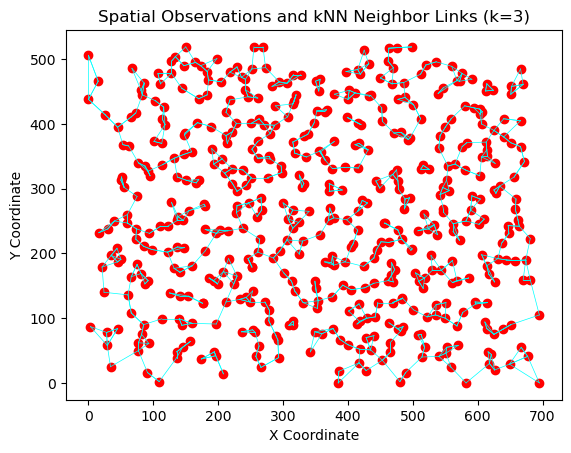

In [65]:
# Assuming 'coords' contains your X and Y coordinates
coords = df_obj[['Cells_AreaShape_Center_X', 'Cells_AreaShape_Center_Y']].values

# Create kNN weights with k=3
knn_weights = KNN(coords, k=2)

# Plot the observations
plt.scatter(coords[:, 0], coords[:, 1], c='red', label='Observations')

# Plot neighbor links
for i, neighbors in knn_weights.neighbors.items():
    for neighbor in neighbors:
        x_values = [coords[i, 0], coords[neighbor, 0]]
        y_values = [coords[i, 1], coords[neighbor, 1]]
        plt.plot(x_values, y_values, c='cyan', linewidth=0.5)

plt.title('Spatial Observations and kNN Neighbor Links (k=3)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


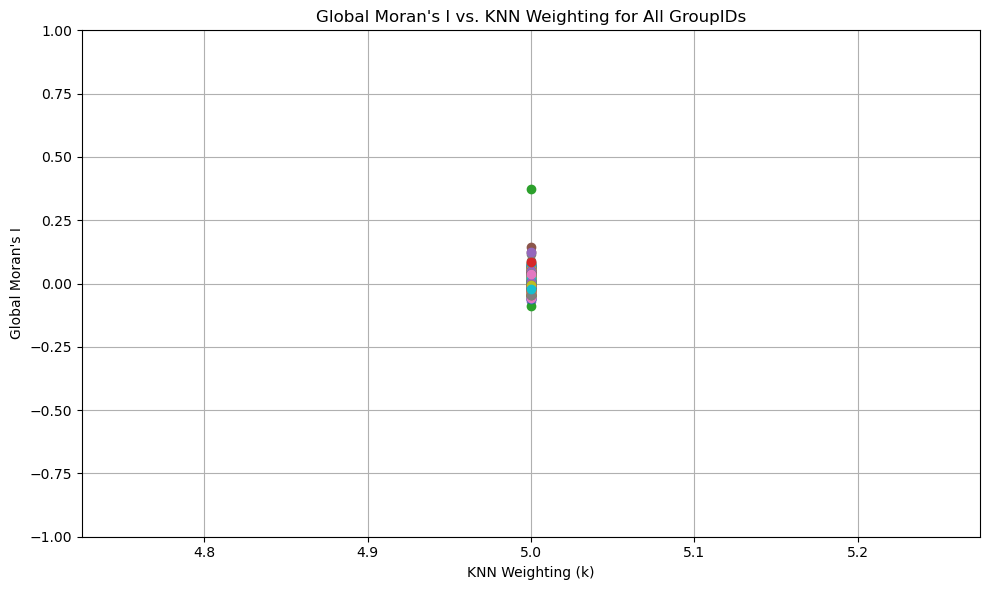

In [57]:
# To store Global Moran's I values for each k and ObjectID
results = {}

# list of different ranges of neighbors
# ks = [3, 6, 12, 25, 50, 100]
# ks = [5, 7, 9, 13, 30, 50, 100]
ks = [5]

# Iterate over each ObjectID
for obj_id in biomorph_cell_stats['GroupID'].unique():
    # Filter data for the current ObjectID
    df_obj = biomorph_cell_stats[biomorph_cell_stats['GroupID'] == obj_id]
    
    # Extract coordinates and feature values
    coords = df_obj[['Cells_AreaShape_Center_X', 'Cells_AreaShape_Center_Y']].values
    feature_values = df_obj['Cells_AreaShape_Area'].values
    
    # Initialize a list to store Moran's I for different ks
    global_is = []
    
    # Iterate over each k value
    for k in ks:
        # Check if there are enough observations
        if len(df_obj) >= k + 1:
            # Create kNN weights
            knn_weights = KNN(coords, k=k)
            
            # Compute Global Moran's I
            mi = esda.Moran(feature_values, knn_weights)
            
            # Append the Moran's I value
            global_is.append(mi.I)
        else:
            # Not enough observations for this k, append NaN
            global_is.append(np.nan)
    
    # Store the results for the current ObjectID
    results[obj_id] = global_is

# Create a DataFrame from the results dictionary
results_df = pd.DataFrame(results, index=ks)

# Transpose the DataFrame so that ObjectIDs are columns
results_df = results_df.T

# Reset index to turn ObjectIDs into a column
results_df.reset_index(inplace=True)

# Rename columns
results_df.rename(columns={'index': 'GroupID'}, inplace=True)

plt.figure(figsize=(10, 6))

for idx, row in results_df.iterrows():
    plt.plot(ks, row[1:], marker='o', label=row['GroupID'])

plt.xlabel('KNN Weighting (k)')
plt.ylabel("Global Moran's I")
plt.title("Global Moran's I vs. KNN Weighting for All GroupIDs")
plt.ylim(-1, 1)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside plot
plt.grid(True)
plt.tight_layout()
plt.show()